# General Approach

- Single Seed: 132
- Split digits dataset in 90% training split and 10% test split
- Different layer setups
    - MLPs:
        - 1, 4, 8 * 16 
        - 1, 4, 8 * 32
        - 1, 4, 6 * 64
        - 1 * 128
    - SwiGLUs:
        - 1, 4, 8 * [5, 5, 6]
        - 1, 4, 8 * [11, 11, 10]
        - 1, 4, 6 * [21, 21, 22]
        - 1 * [43, 43, 42]
- Hyperparameter grid search over learning rate (0.01, 0.05, 0.1) and weight decays (0, 0.0001, 0.001), using stochastic gradient descent
- Select best model for each layer setup and compute Hessian estimation based on the 90% train split
    - Damping: Average FIM Eigenvalue * 0.1
    - Note: Since the digits dataset consists of "only" 1797 samples 


- **Important**: Currently there is a bug in the script which computed FIM Block and FIM similarly, so FIM Block is missing so far.


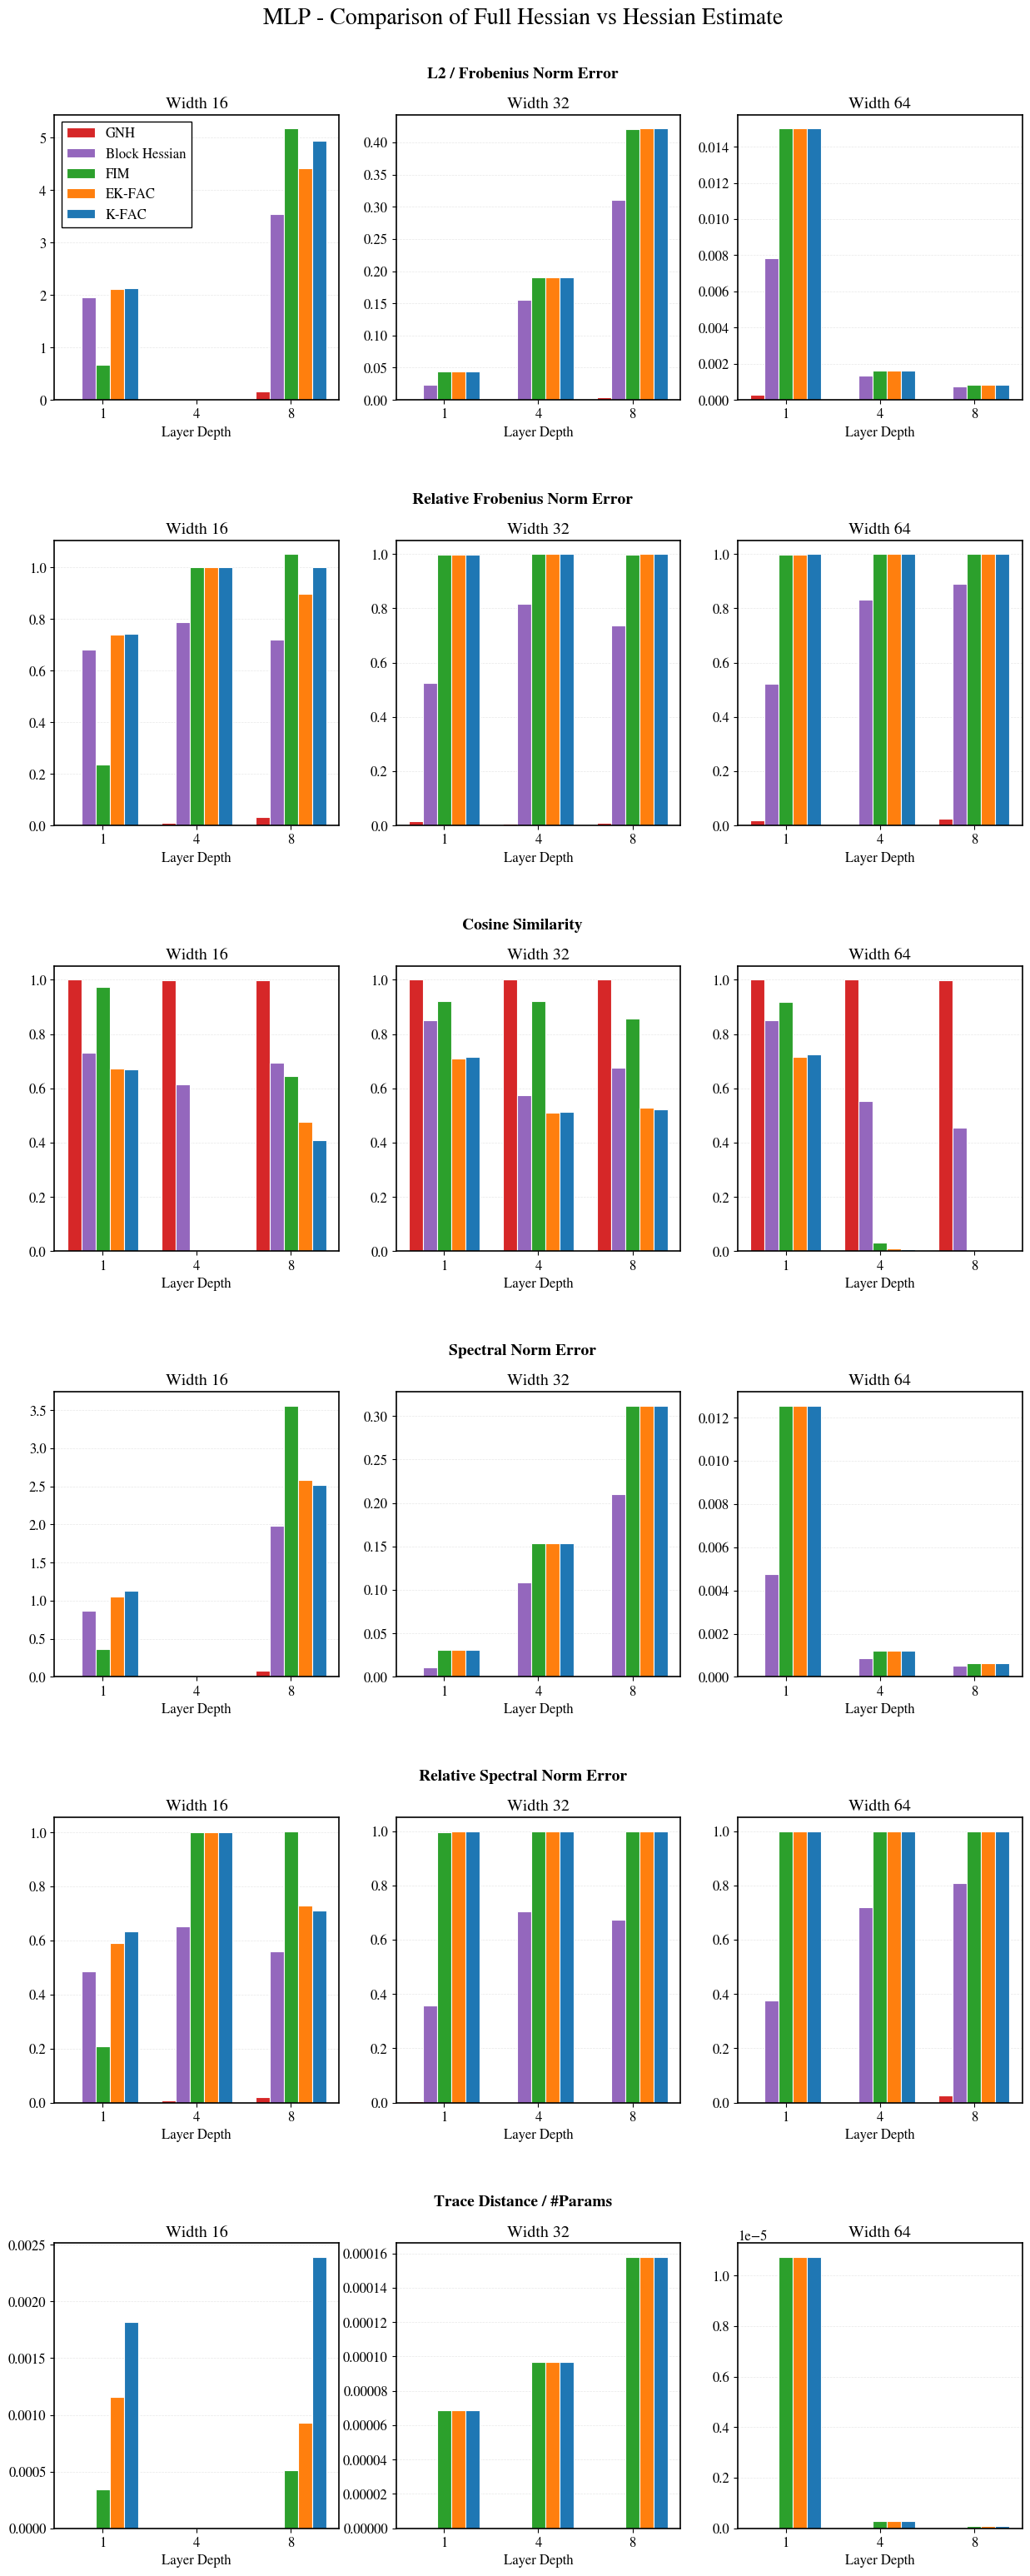

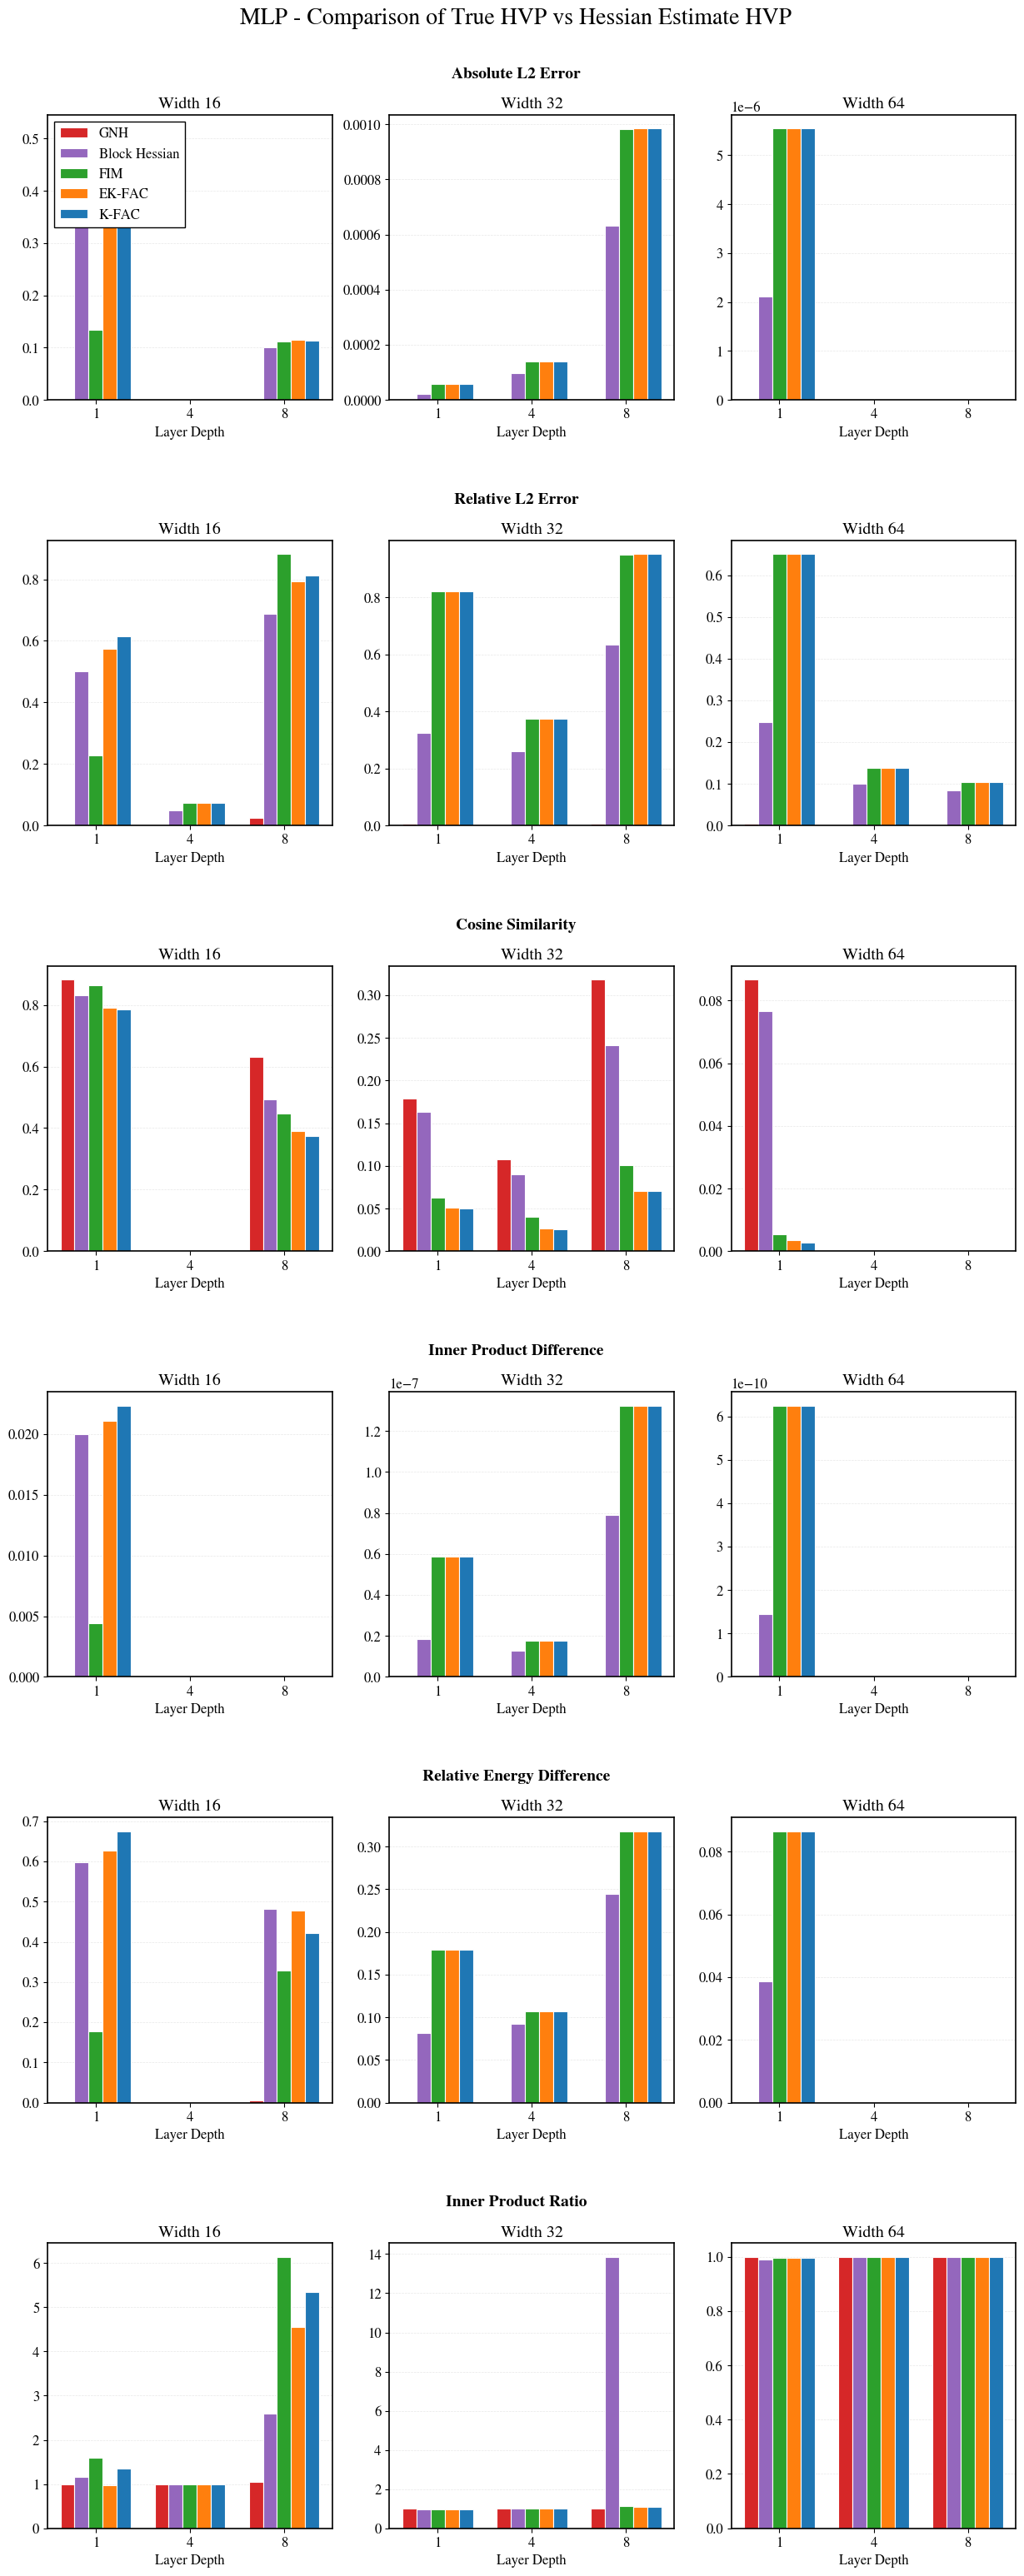

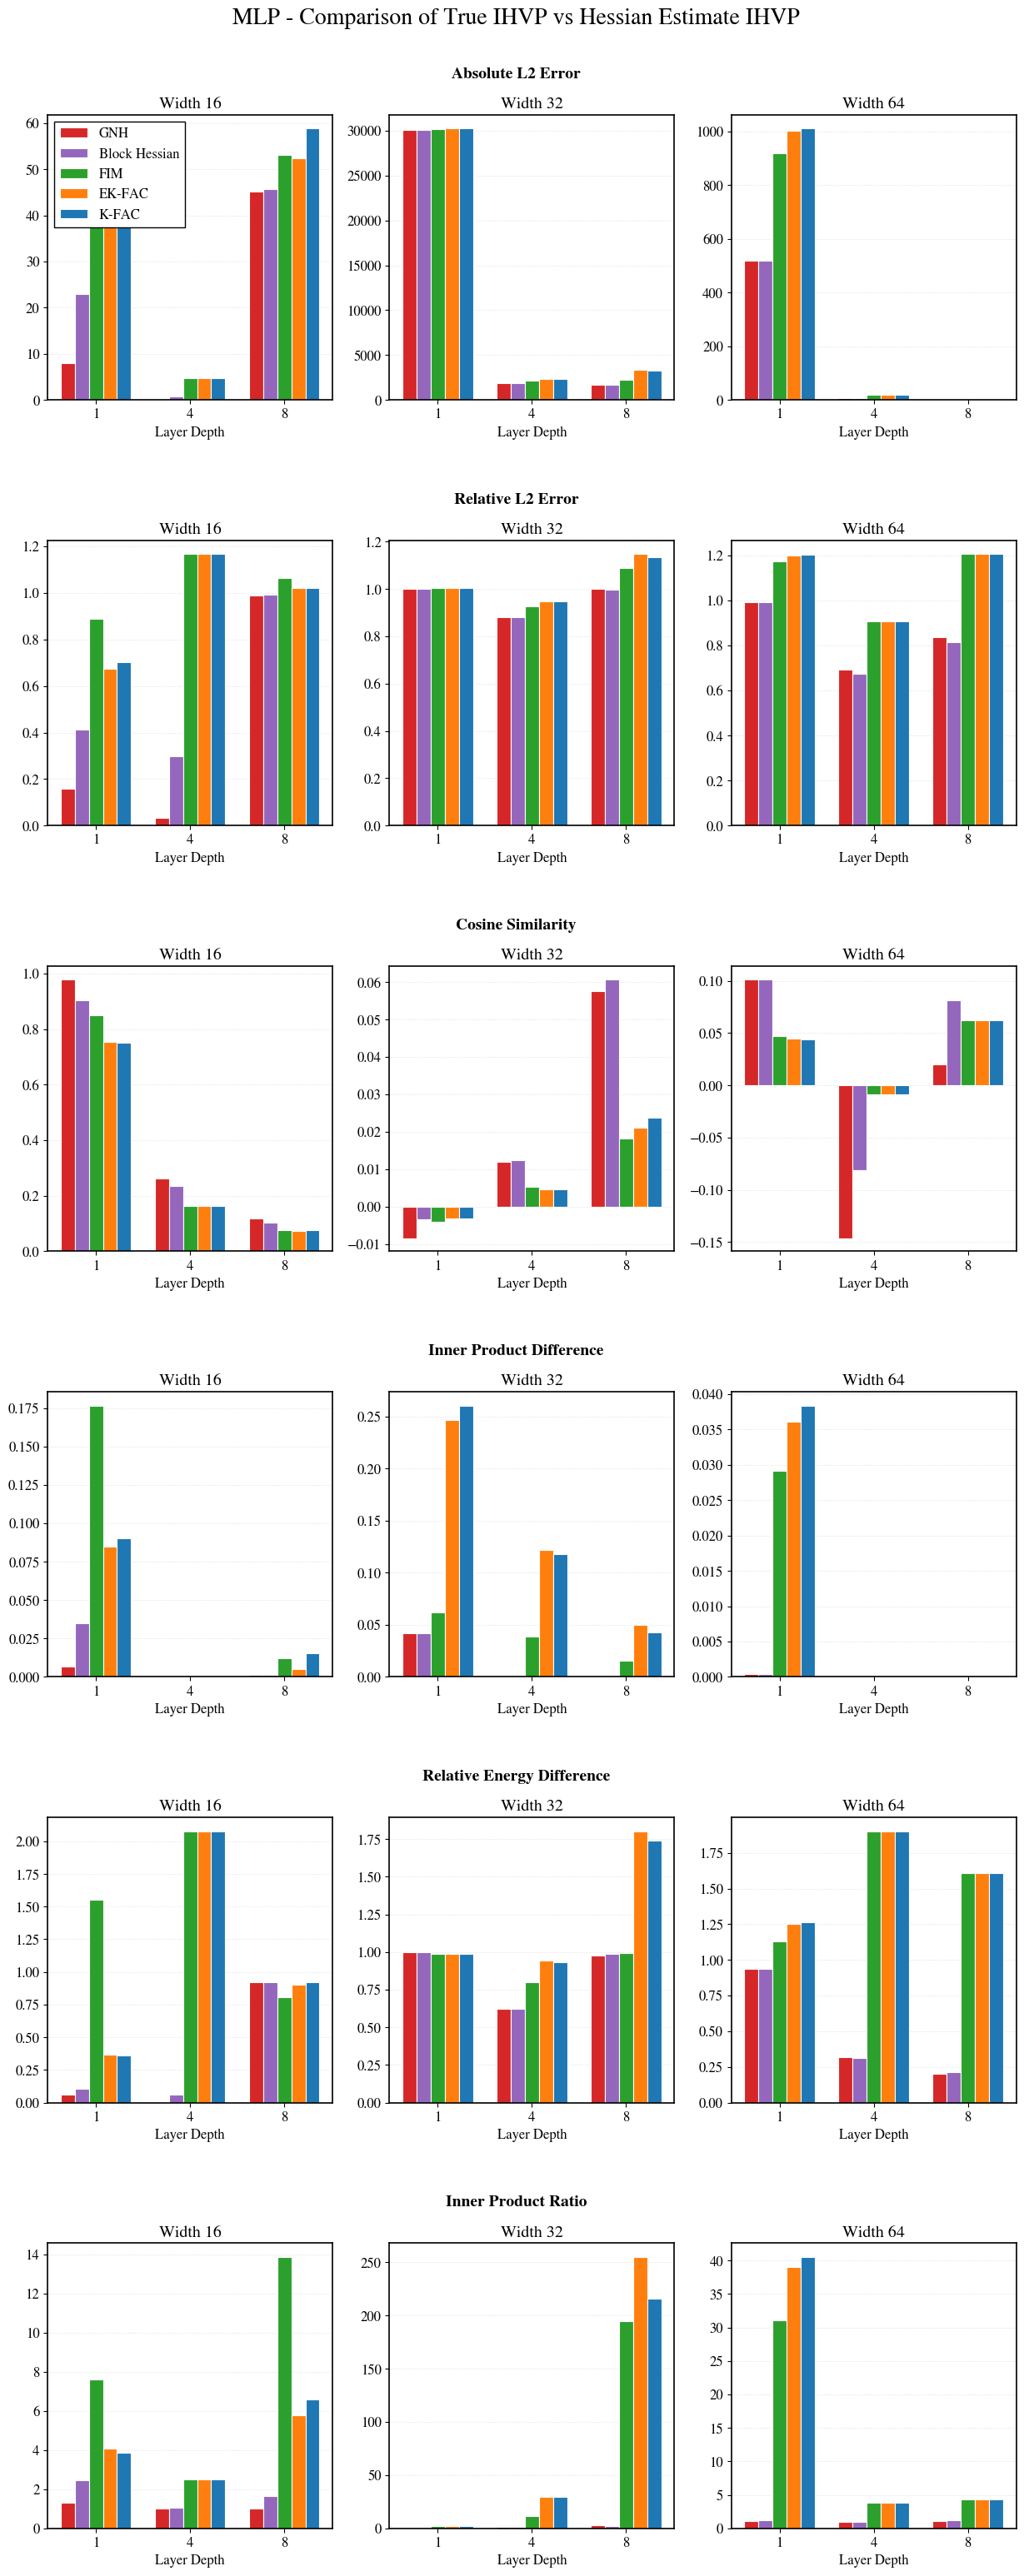

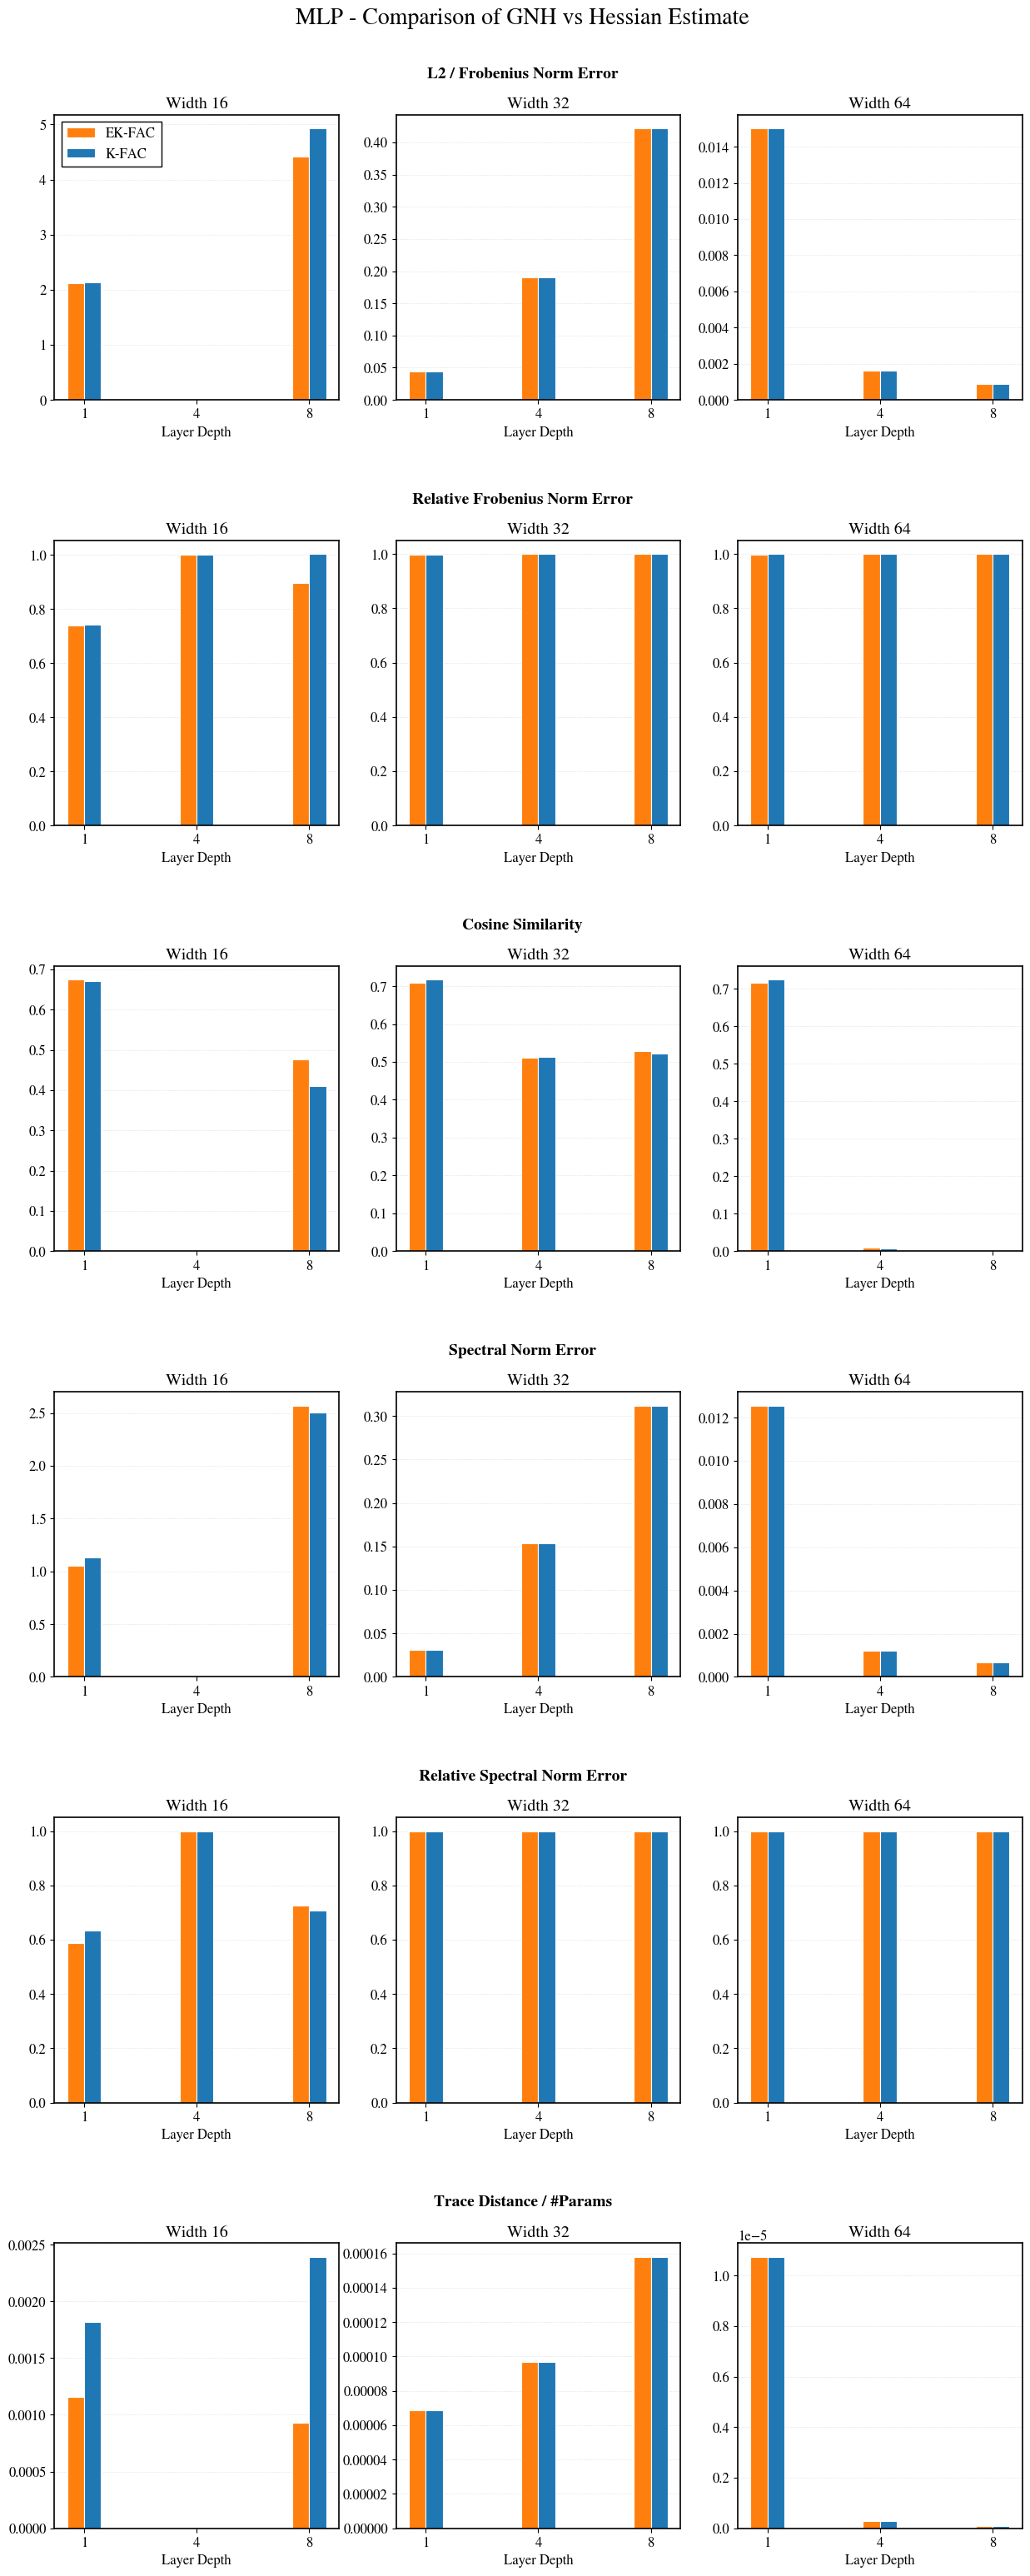

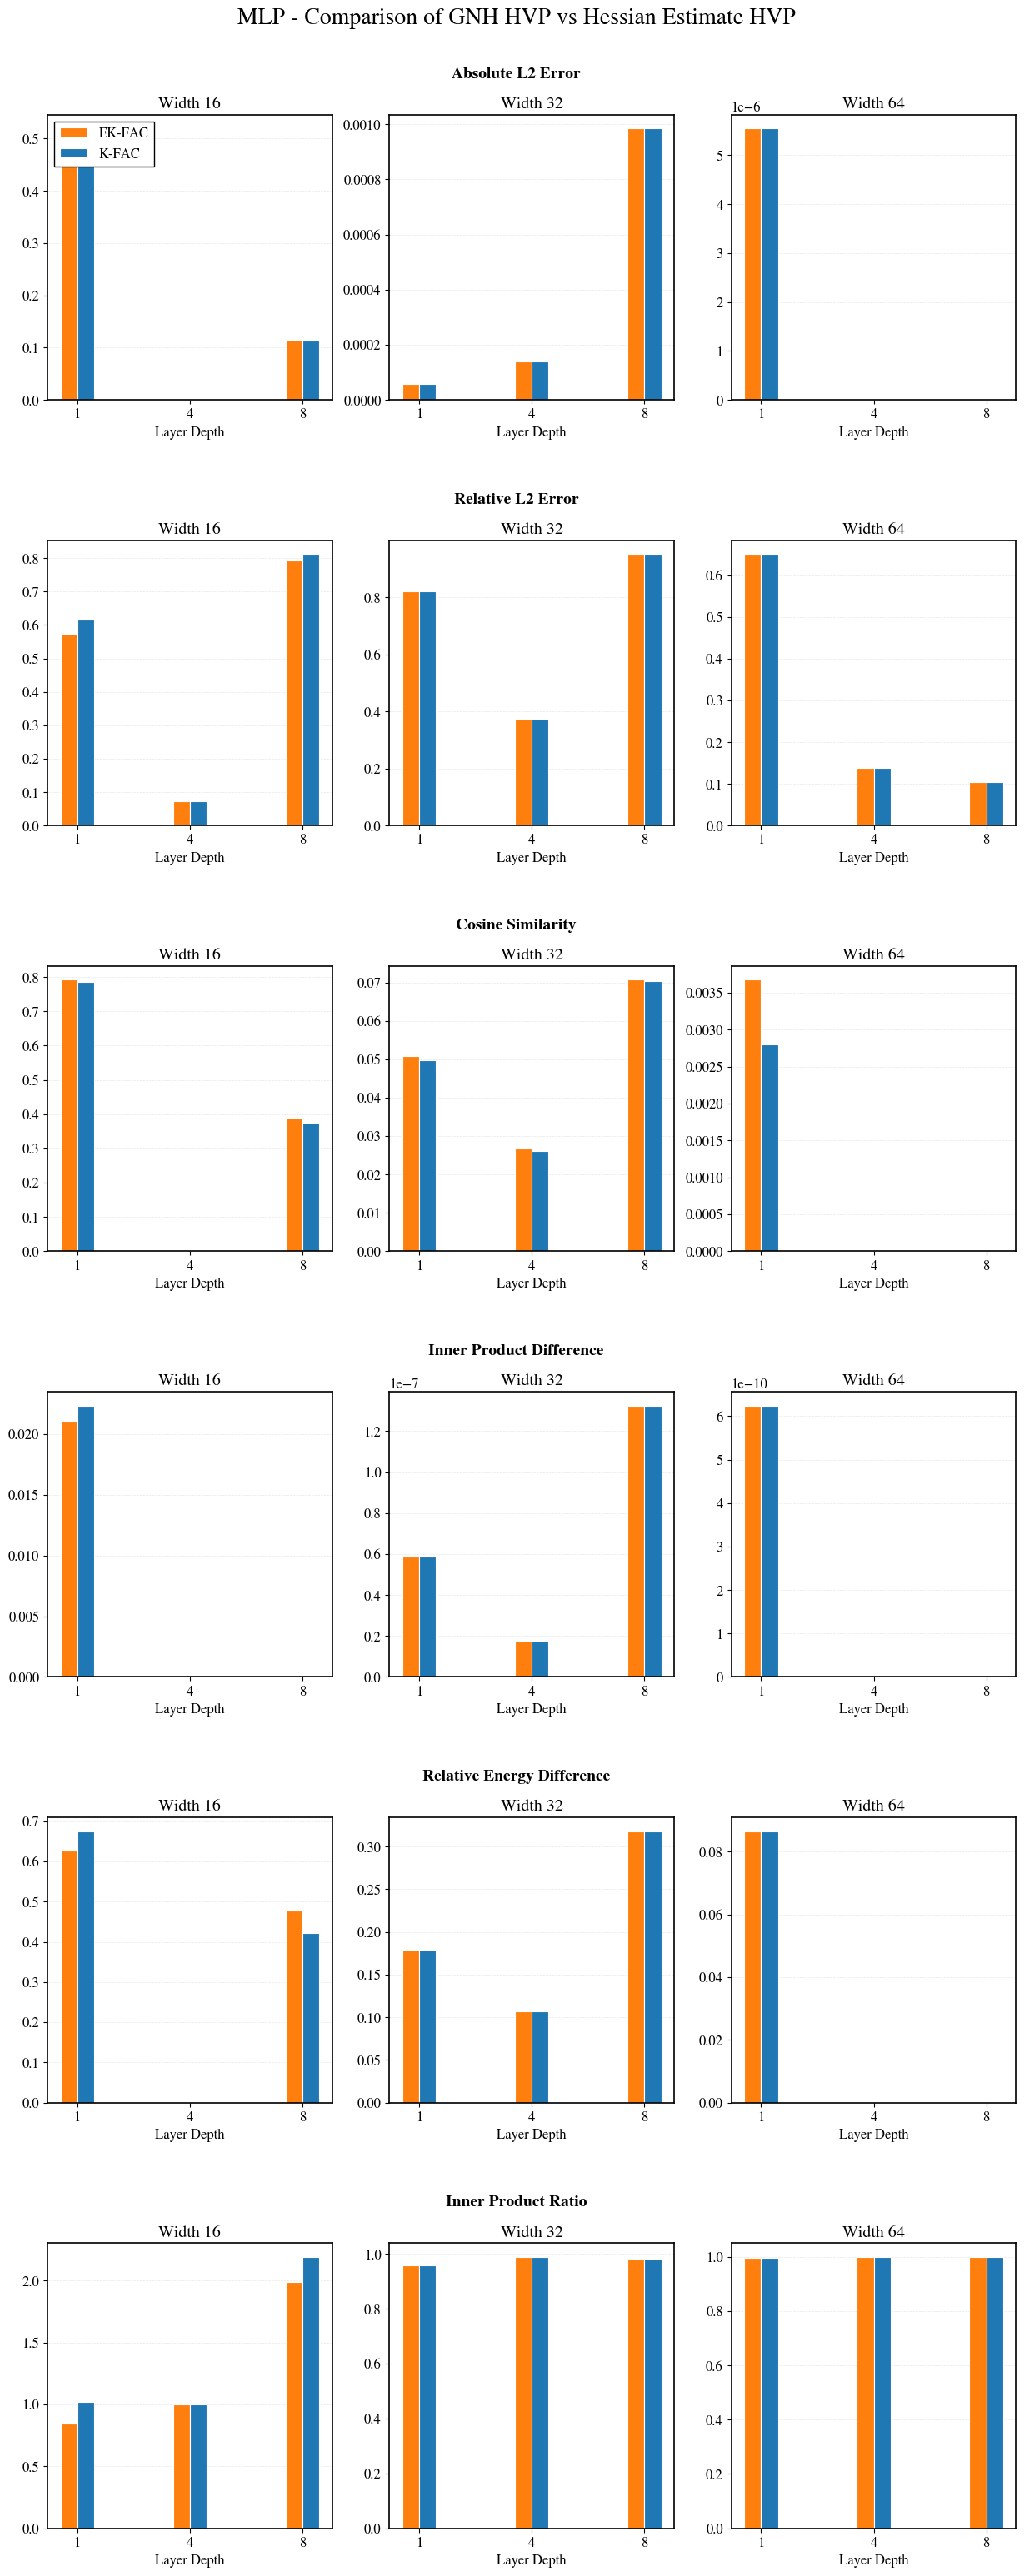

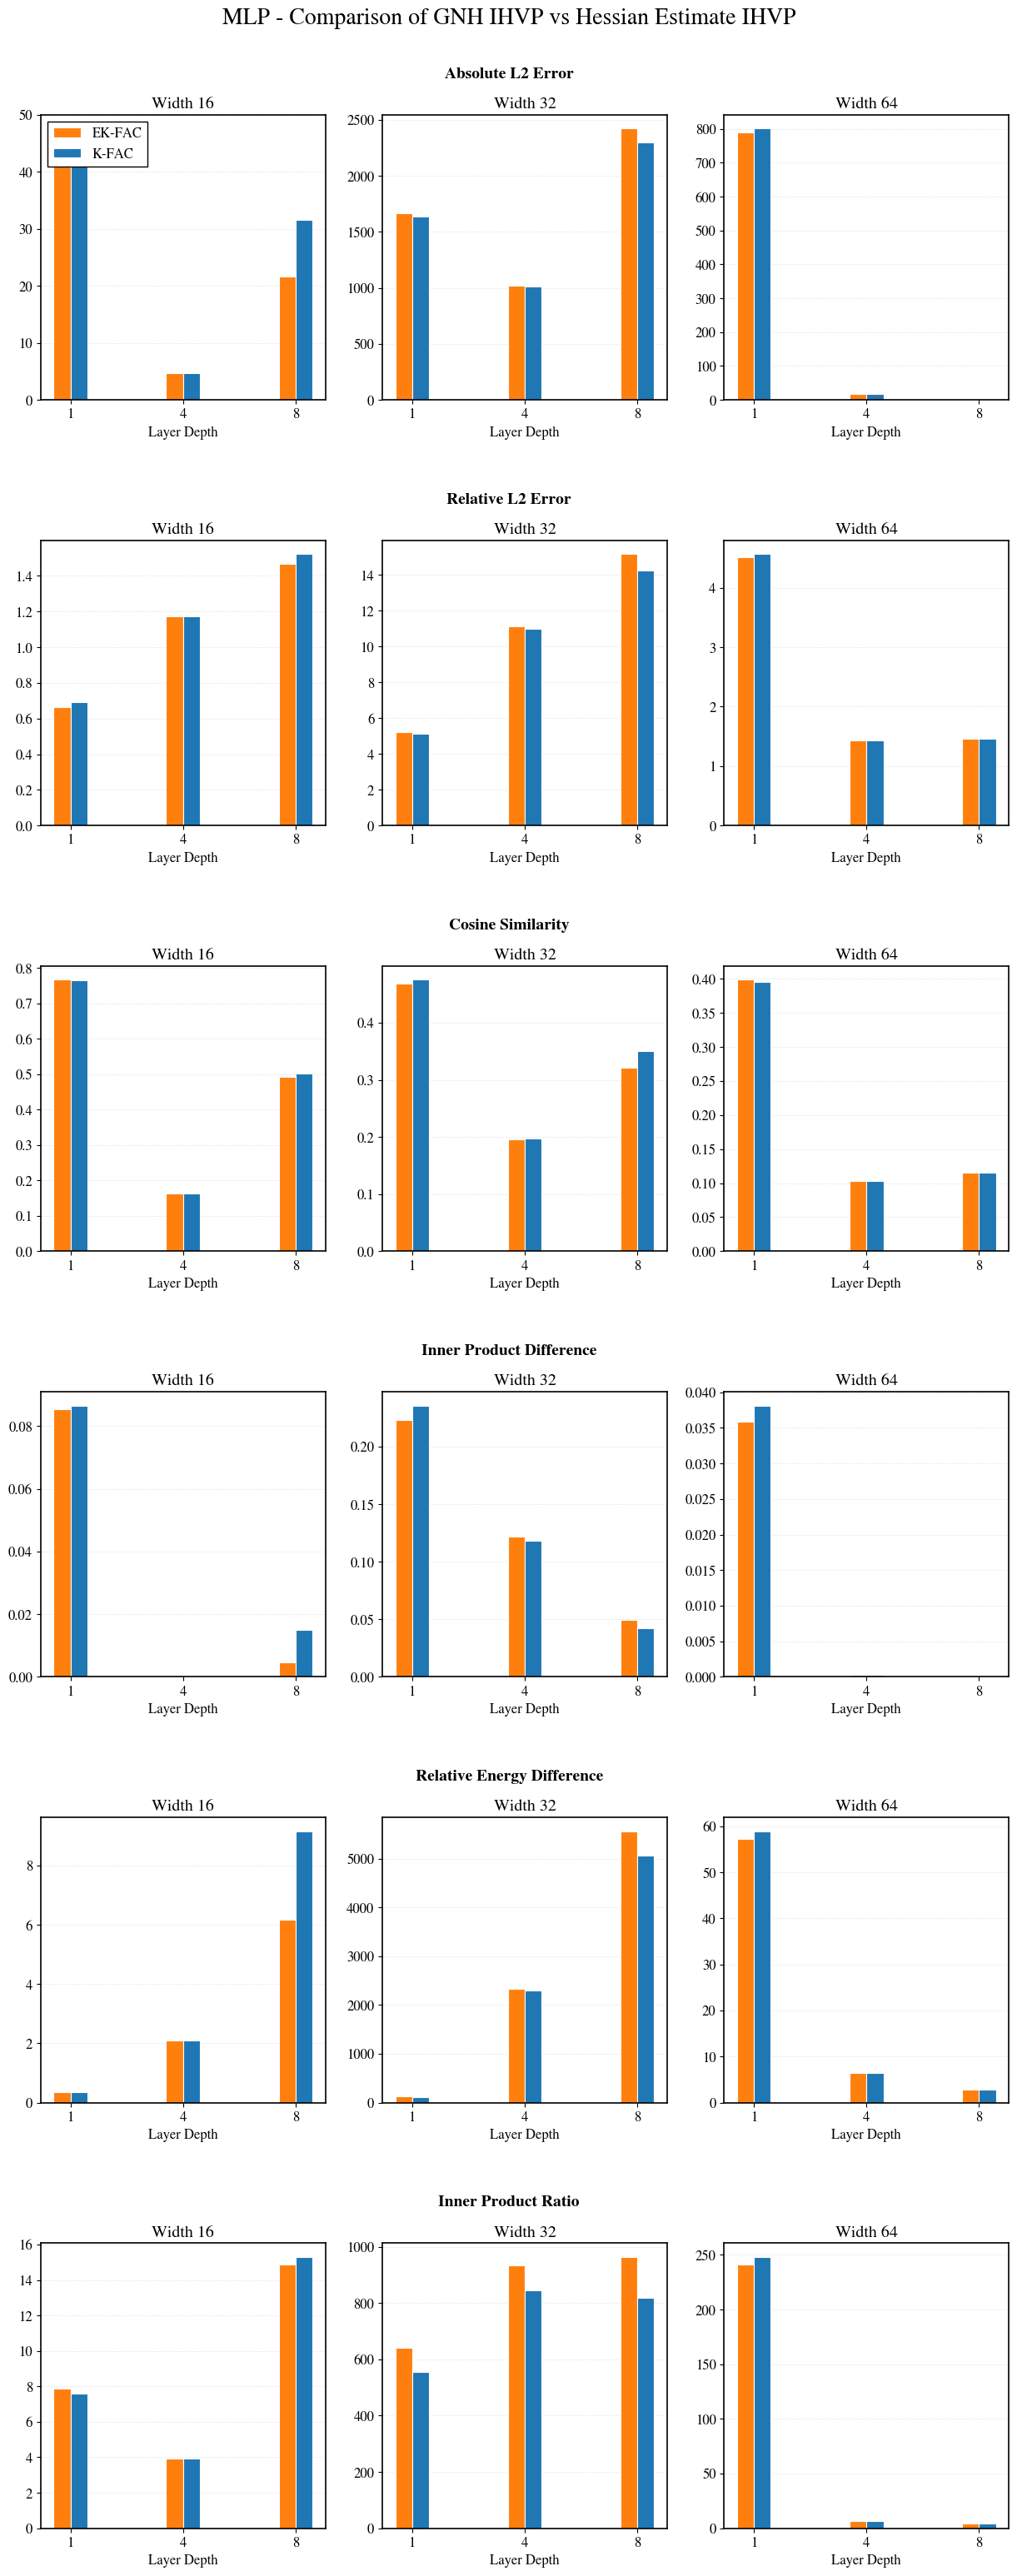

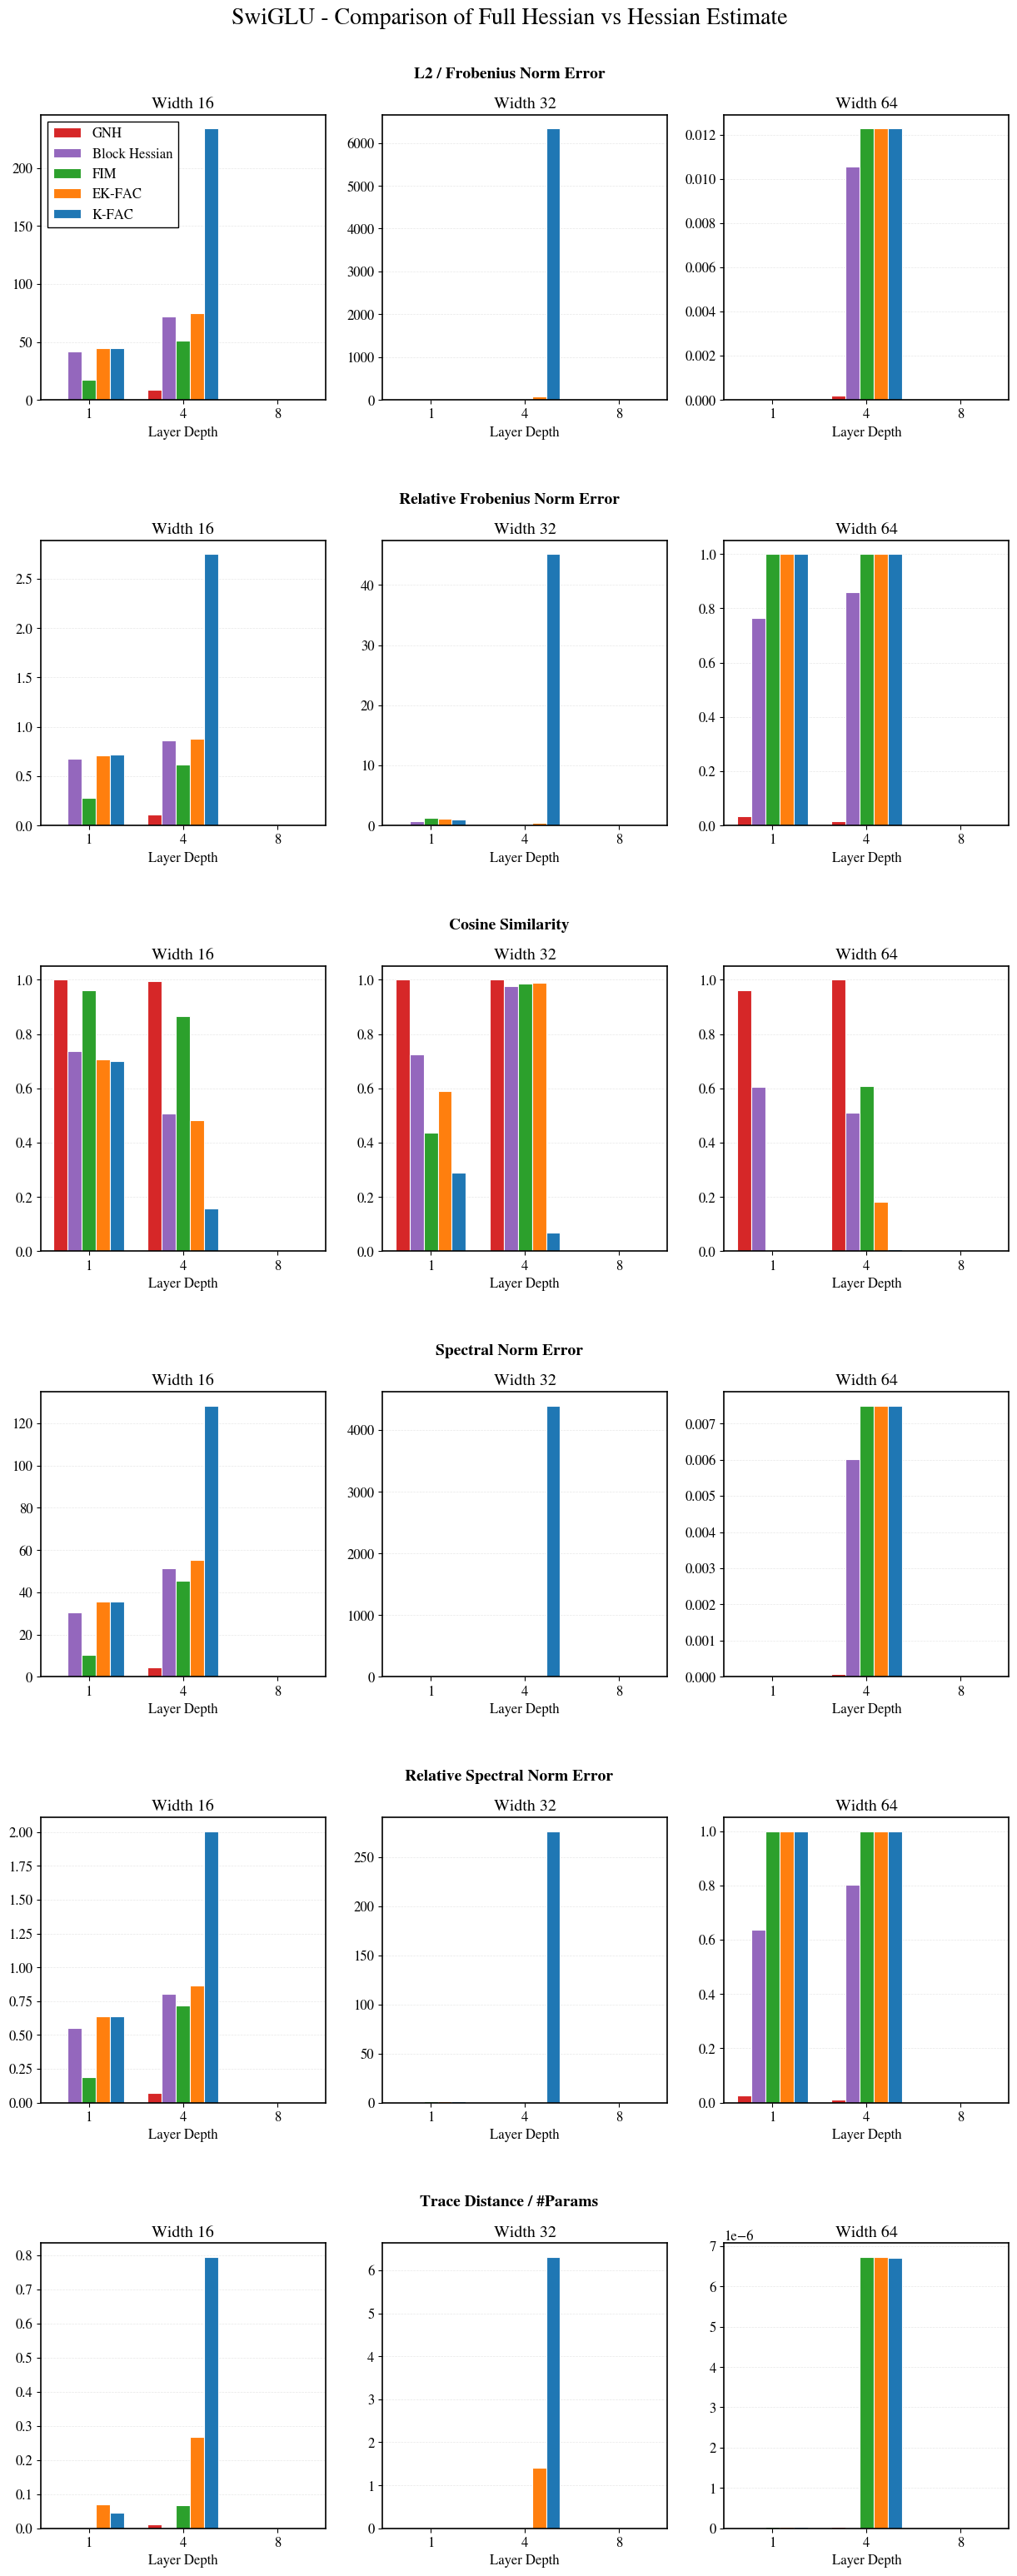

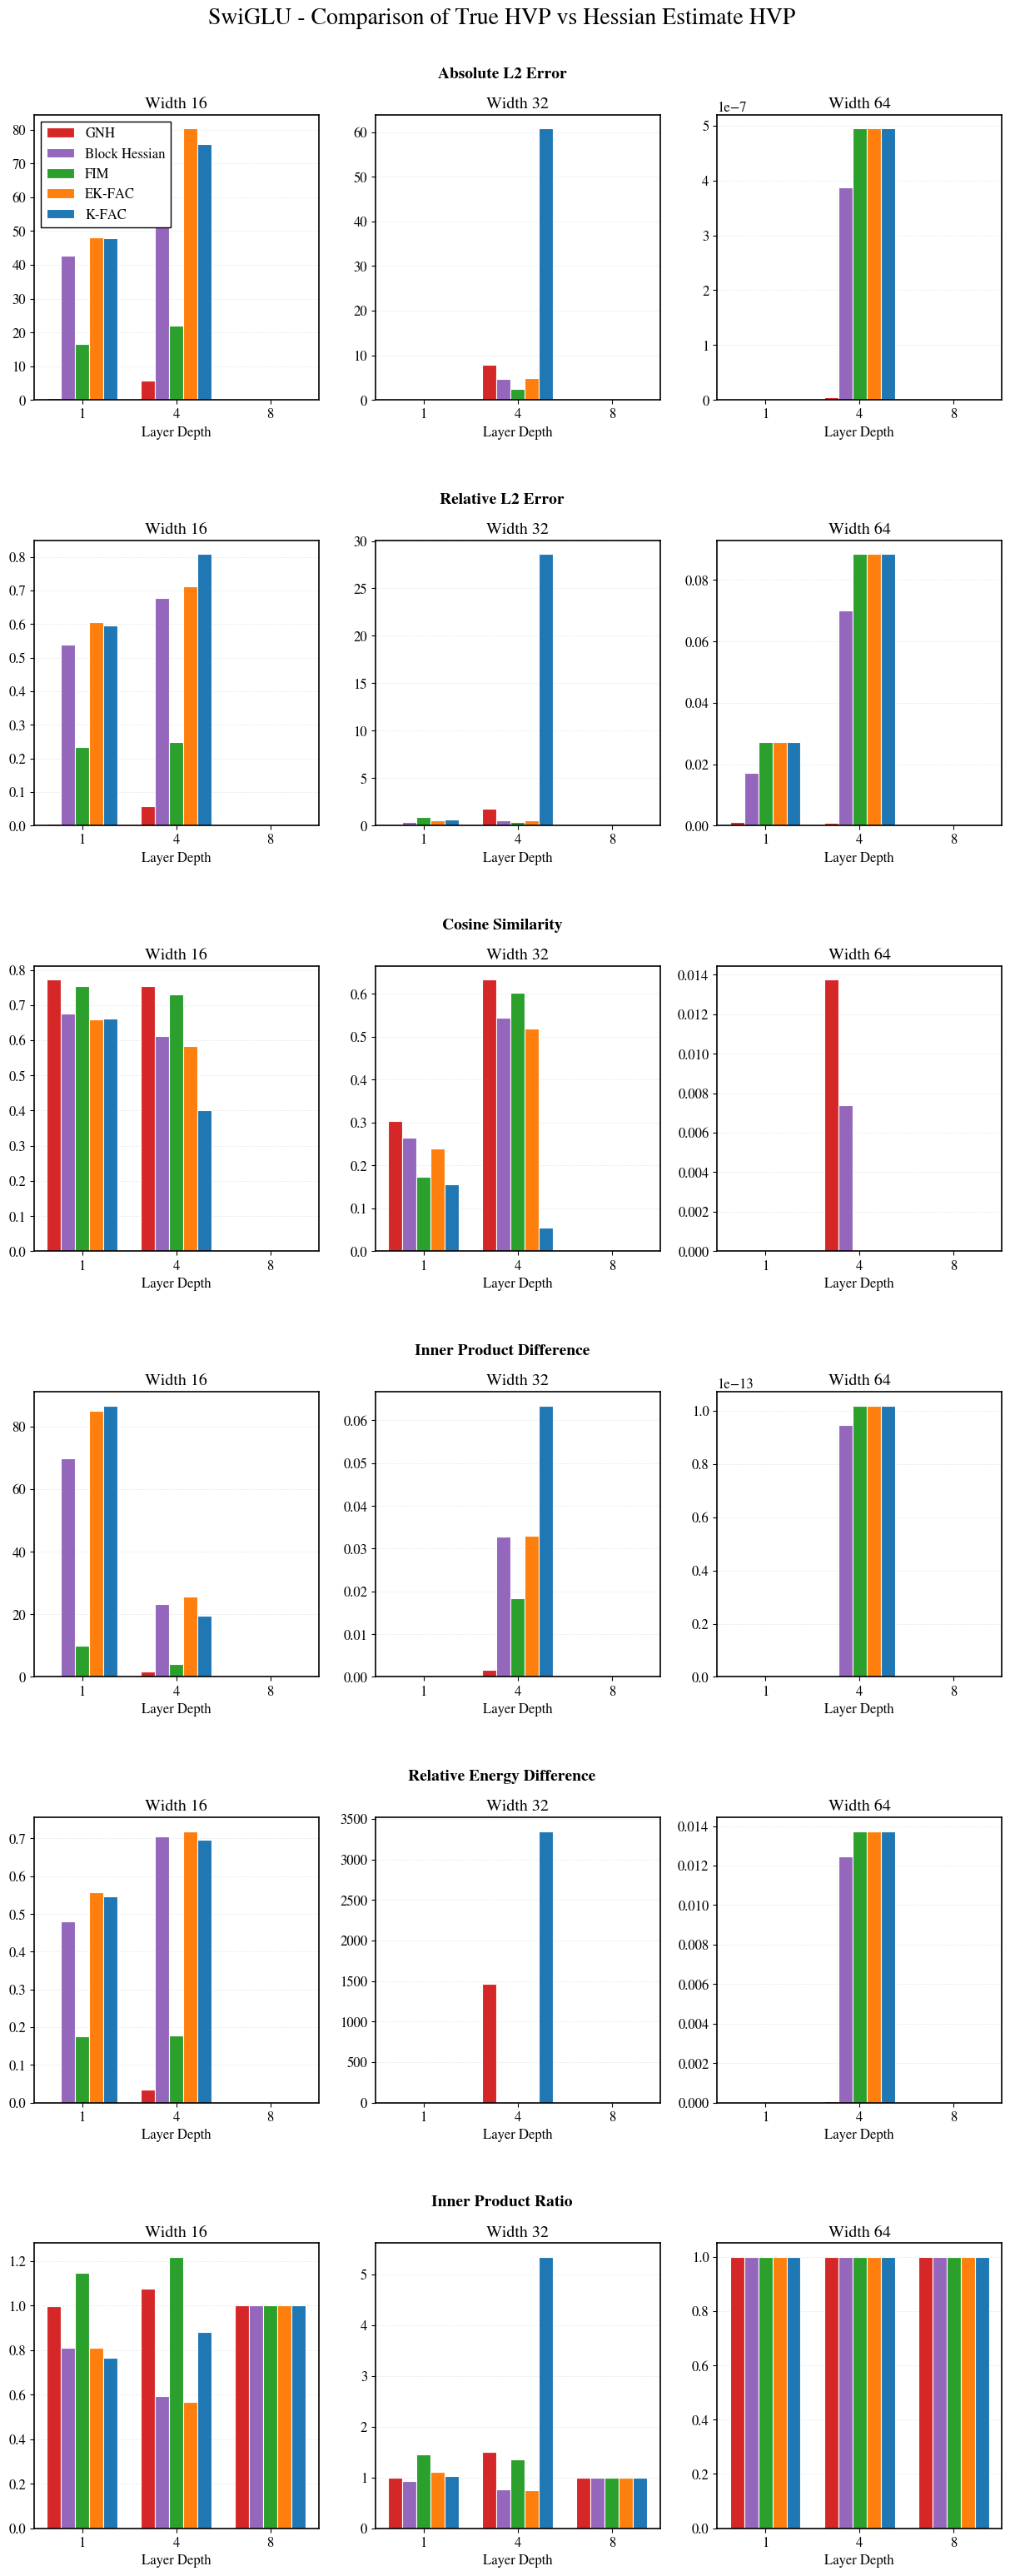

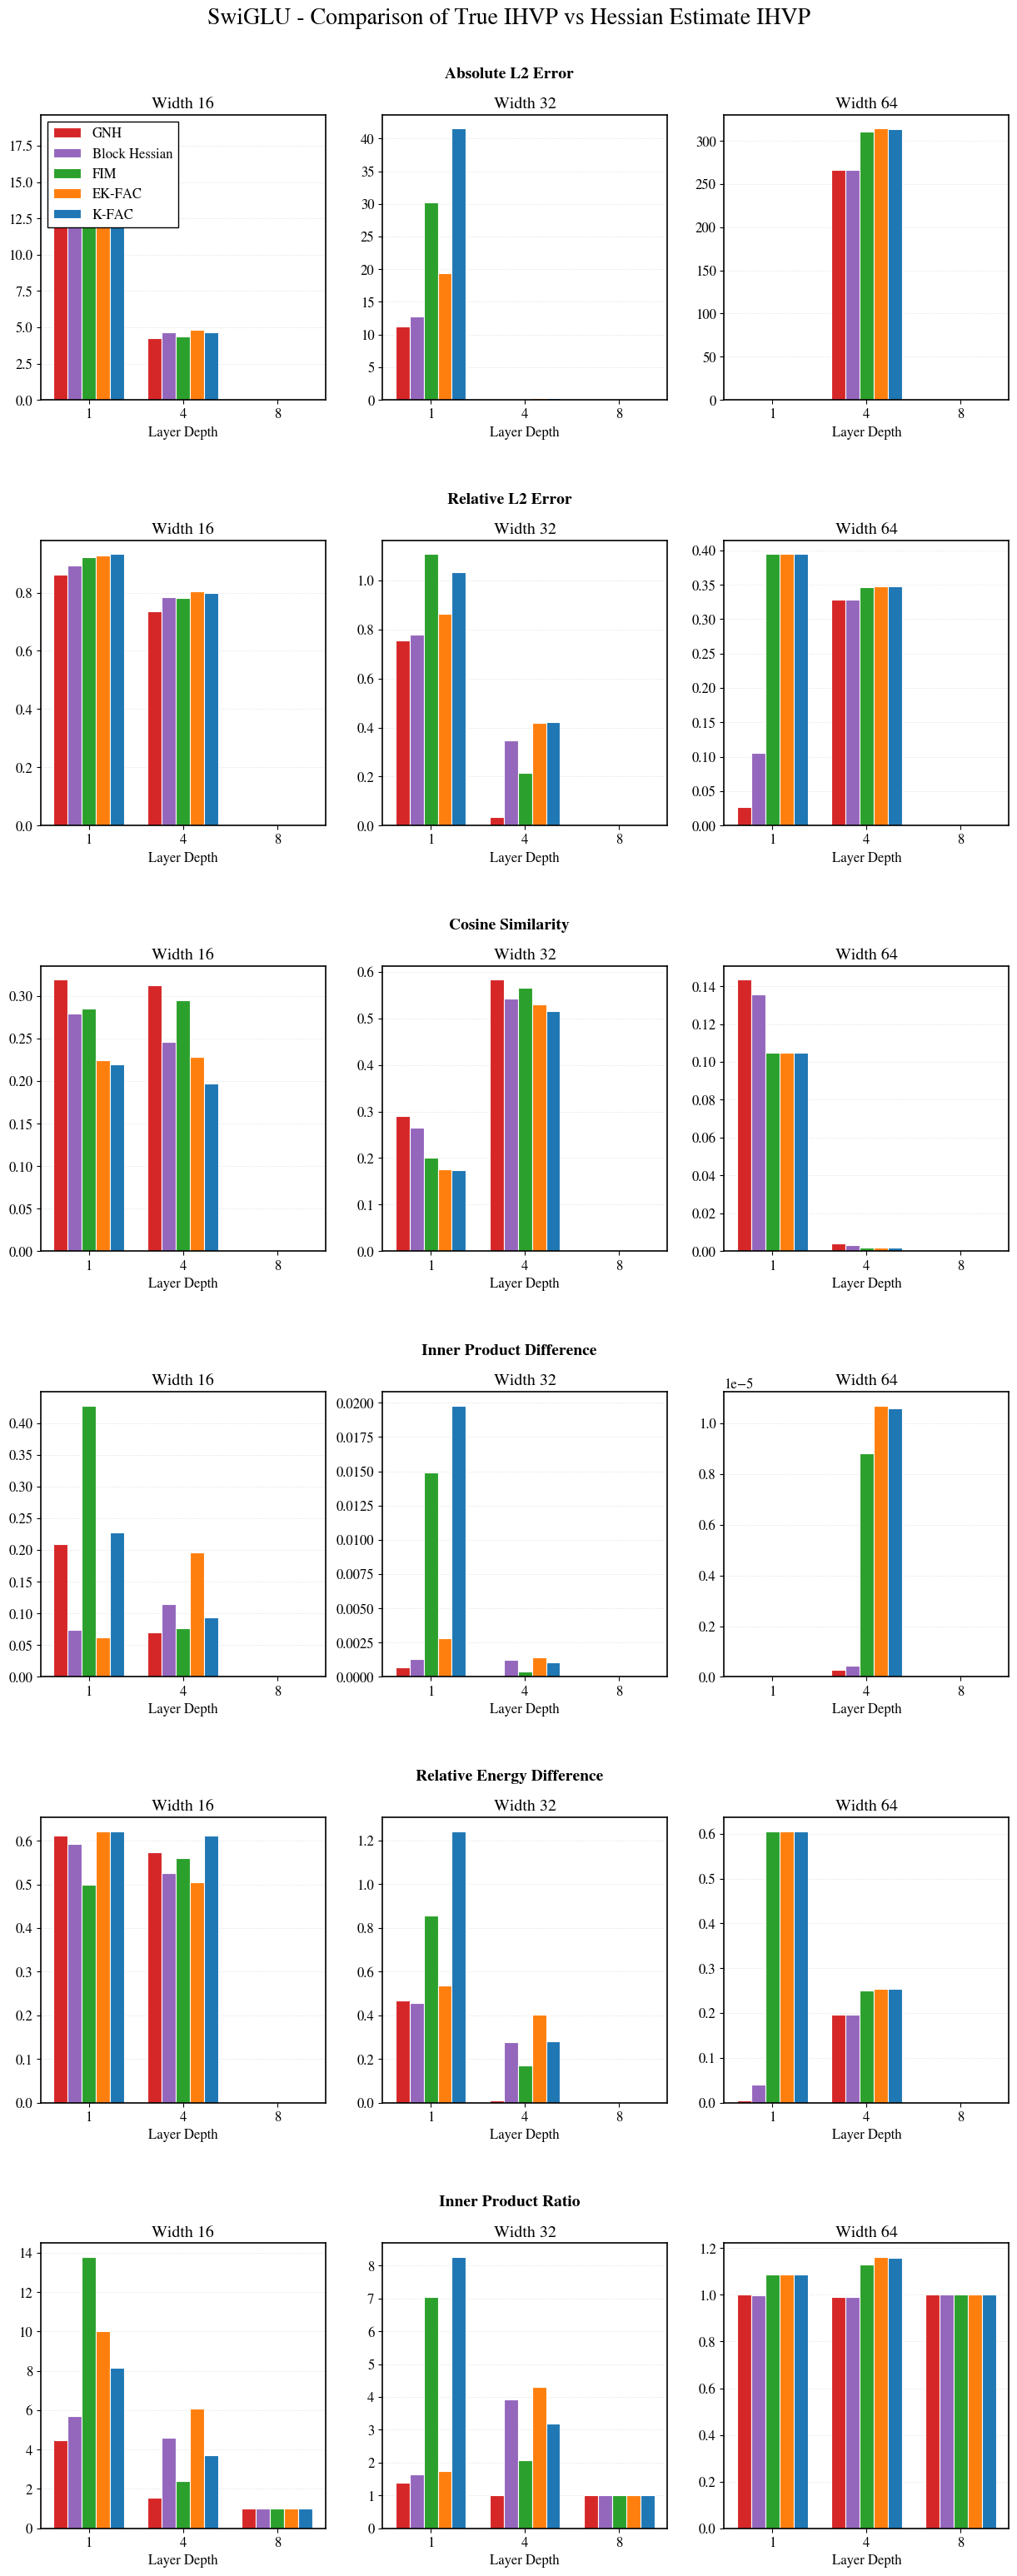

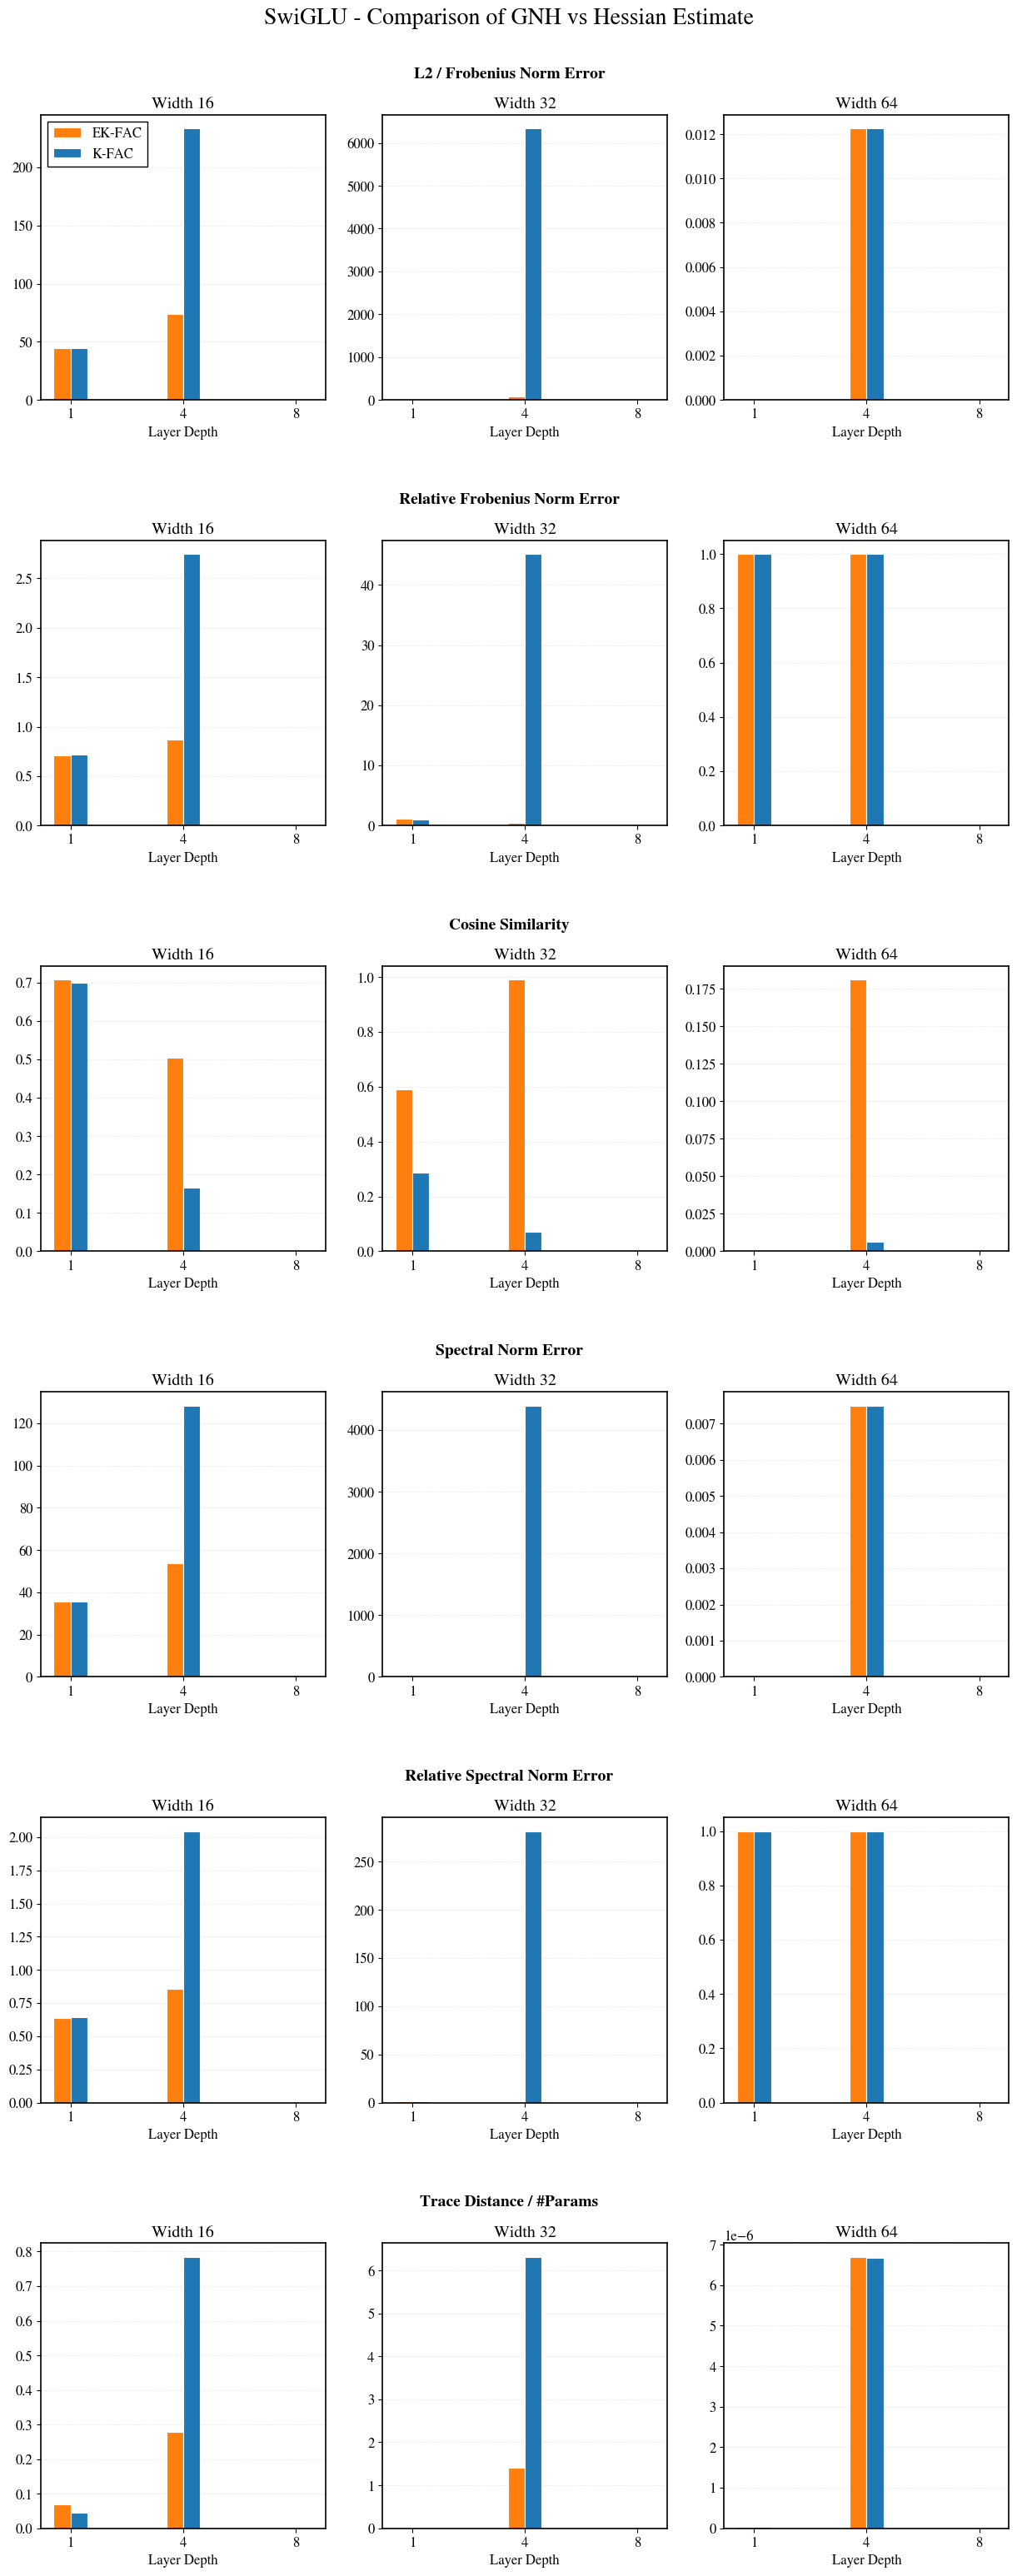

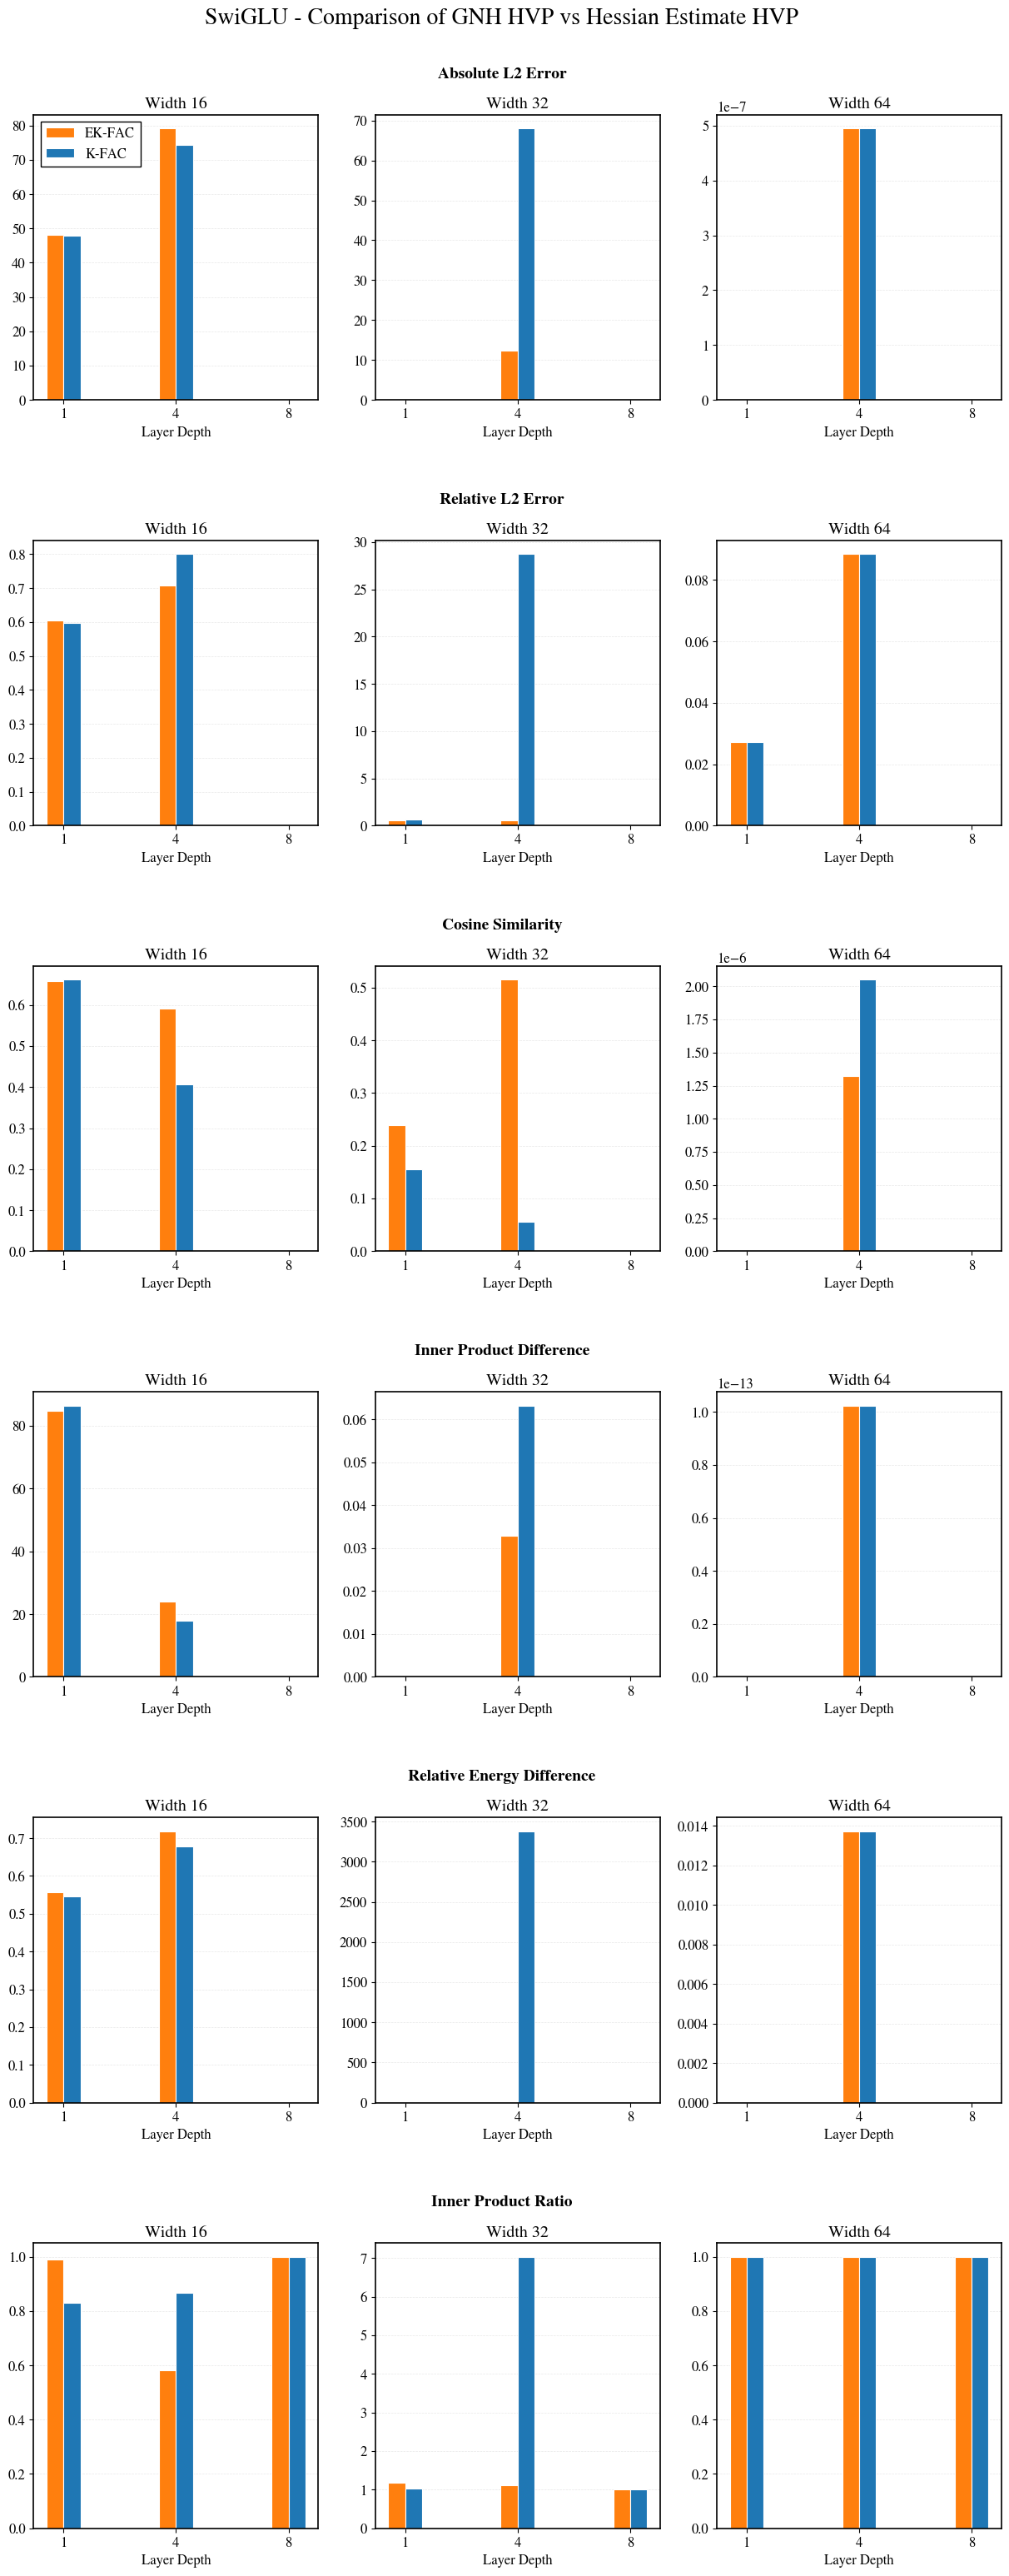

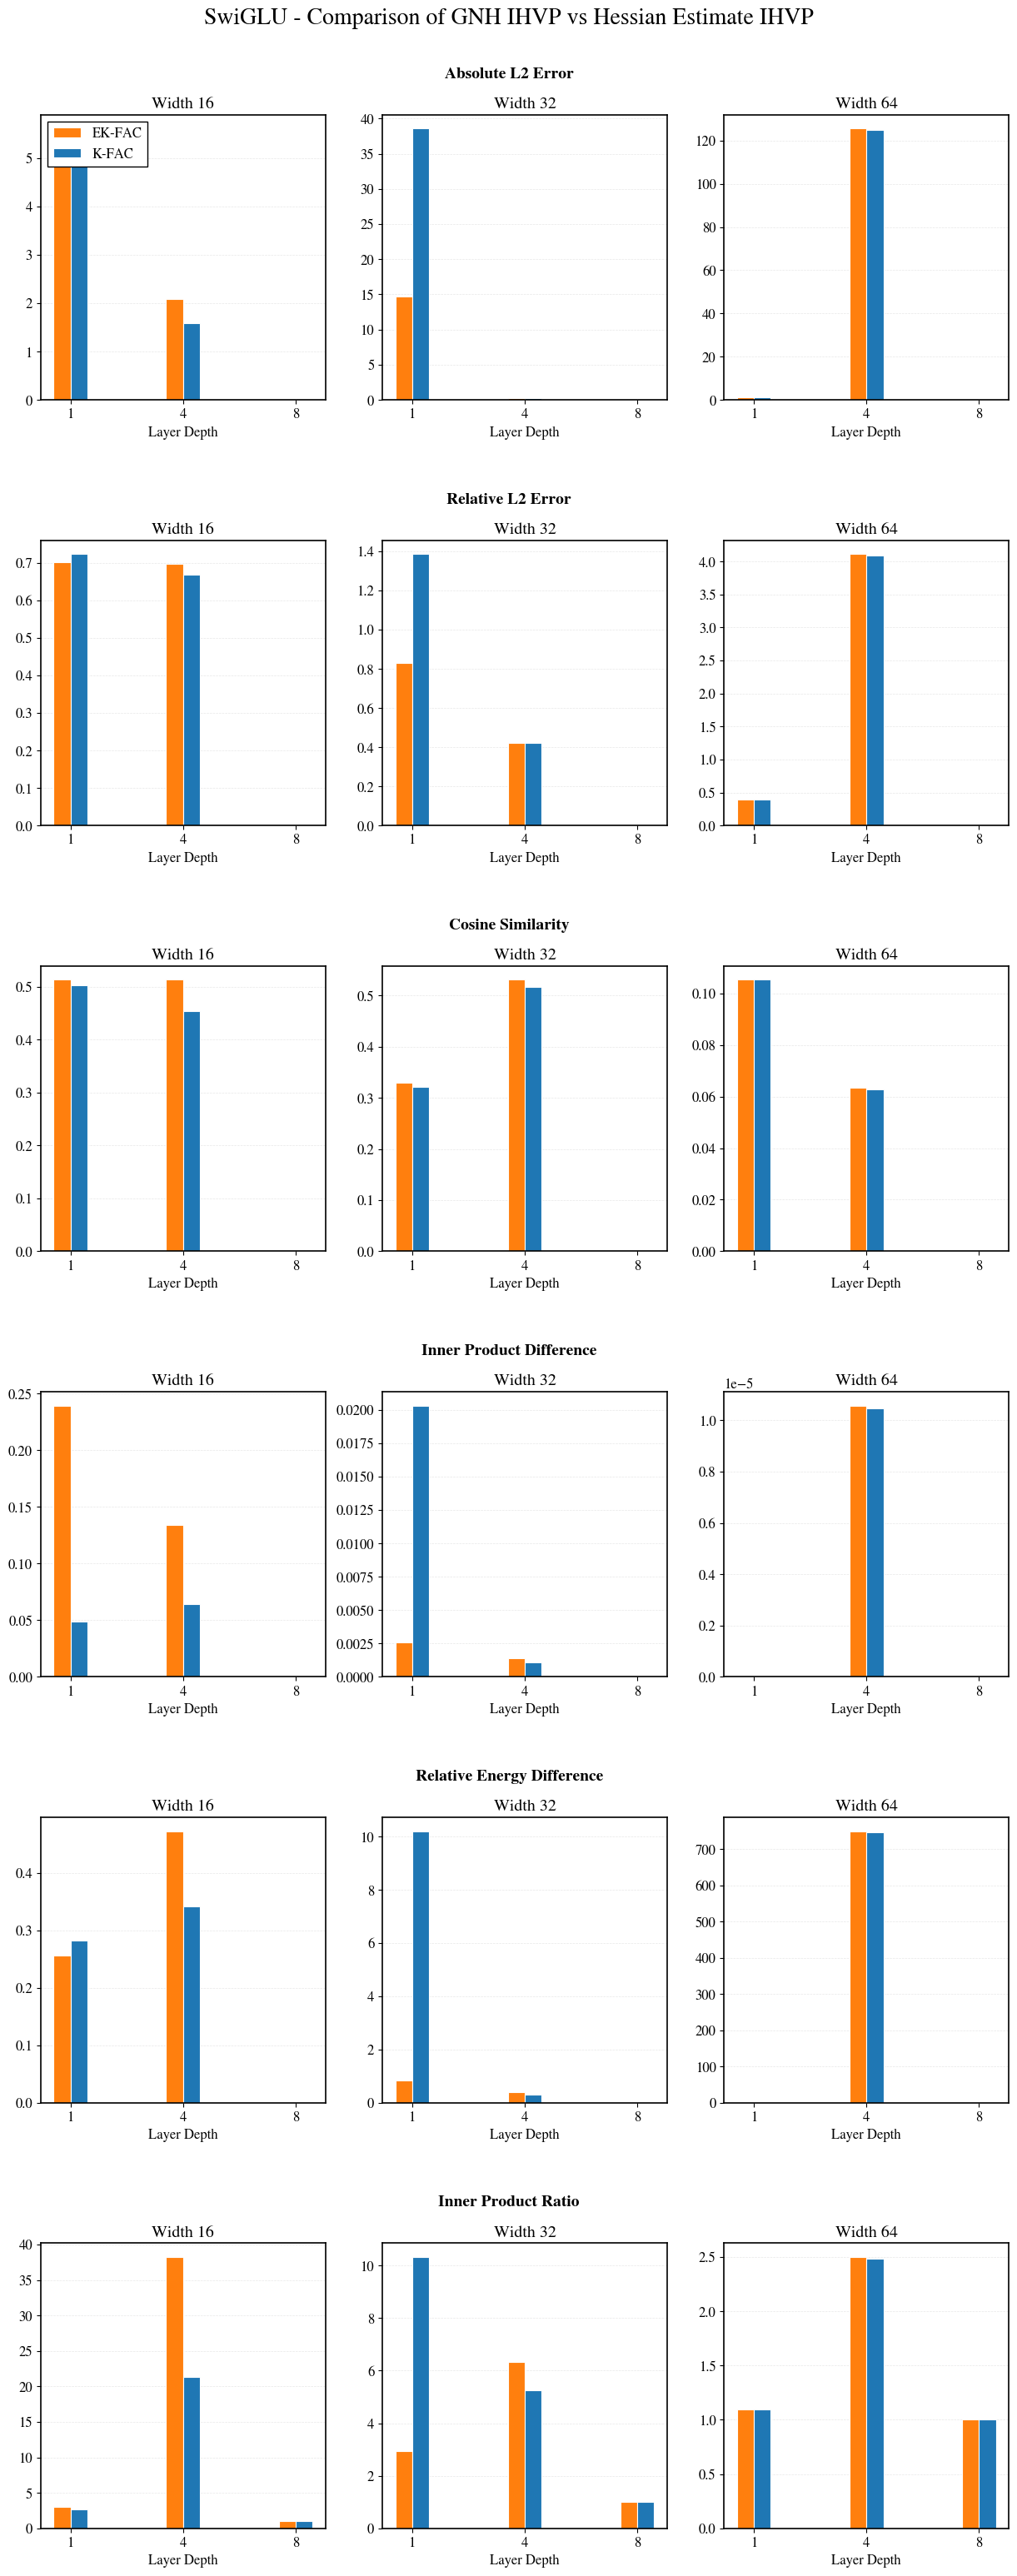

In [5]:
# =========================
# Hessian & IHVP Analysis (MLP + SwiGLU)
# =========================

# ------------------------------------------------------------
# Imports
# ------------------------------------------------------------
import json

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ------------------------------------------------------------
# Load experiment data
# ------------------------------------------------------------
with open("/Users/jgsi/Downloads/20260114-214233.json", "r") as f:
    data = json.load(f)

# ------------------------------------------------------------
# Global Matplotlib style
# ------------------------------------------------------------
plt.rcParams.update(
    {
        "font.size": 12,
        "font.family": "STIXGeneral",
        "mathtext.fontset": "stix",
        "text.usetex": False,
        "axes.linewidth": 1.2,
        "grid.linewidth": 0.5,
        "lines.linewidth": 2,
        "legend.frameon": True,
        "legend.fancybox": False,
        "legend.edgecolor": "black",
        "legend.framealpha": 1.0,
    }
)

# ------------------------------------------------------------
# Global config
# ------------------------------------------------------------
colors = {
    "kfac": "#1f77b4",
    "ekfac": "#ff7f0e",
    "gnh": "#d62728",
    "fim": "#2ca02c",
    "block_hessian": "#9467bd",
}

hessian_estimator_mapping = {
    "gnh": "GNH",
    "block_hessian": "Block Hessian",
    "fim": "FIM",
    "ekfac": "EK-FAC",
    "kfac": "K-FAC",
}

gnh_estimator_mapping = {
    "ekfac": "EK-FAC",
    "kfac": "K-FAC",
}

matrix_metrics = [
    ("frobenius", "L2 / Frobenius Norm Error"),
    ("relative_frobenius", "Relative Frobenius Norm Error"),
    ("cosine_similarity", "Cosine Similarity"),
    ("spectral", "Spectral Norm Error"),
    ("spectral_relative", "Relative Spectral Norm Error"),
    ("trace_distance", "Trace Distance / #Params"),
]

vector_metrics = [
    ("ABSOLUTE_L2_DIFF", "Absolute L2 Error"),
    ("RELATIVE_ERROR", "Relative L2 Error"),
    ("COSINE_SIMILARITY", "Cosine Similarity"),
    ("INNER_PRODUCT_DIFF", "Inner Product Difference"),
    ("RELATIVE_ENERGY_DIFF", "Relative Energy Difference"),
    ("INNER_PRODUCT_RATIO", "Inner Product Ratio"),
]

bar_width = 0.15


# ------------------------------------------------------------
# Helper: generic barplot routine
# ------------------------------------------------------------
def plot_block(
    results_cfg, metrics, comparison_key, reference_key, estimator_map, title
):
    fig = plt.figure(figsize=(15, 5 * len(metrics)))
    gs = GridSpec(
        len(metrics) * 2 - 1,
        1,
        figure=fig,
        height_ratios=[1 if i % 2 == 0 else 0.15 for i in range(len(metrics) * 2 - 1)],
    )

    for midx, (metric, metric_label) in enumerate(metrics):
        subfig = fig.add_subfigure(gs[midx * 2, 0])
        axs = subfig.subplots(1, 3)
        subfig.suptitle(metric_label, fontsize=14, fontweight="bold", y=1.01)

        for widx, (results, depths, wtitle) in enumerate(results_cfg):
            ax = axs[widx]
            single = [
                e["hessian_analysis"][comparison_key][metric][reference_key]
                for e in results
            ]

            x_pos = list(range(len(depths)))
            n_methods = len(estimator_map)

            for m, (method, label) in enumerate(estimator_map.items()):
                values = [s[method] for s in single]
                offsets = [
                    p - (n_methods - 1) * bar_width / 2 + m * bar_width for p in x_pos
                ]
                ax.bar(
                    offsets,
                    values,
                    width=bar_width,
                    label=label,
                    color=colors.get(method),
                    edgecolor="white",
                    linewidth=0.8,
                )

            ax.set_xticks(x_pos)
            ax.set_xticklabels(depths)
            ax.set_title(wtitle)
            ax.grid(True, axis="y", linestyle="--", alpha=0.3)
            ax.set_axisbelow(True)

            ax.set_xlabel("Layer Depth")
            if midx == 0 and widx == 0:
                ax.legend(loc="upper left")

    fig.suptitle(title, fontsize=20, y=1.025)
    plt.show()


# ------------------------------------------------------------
# Result extraction
# ------------------------------------------------------------
results_mlp = [e for e in data["results"] if e["model_config"]["architecture"] == "mlp"]
results_swiglu = [
    e for e in data["results"] if e["model_config"]["architecture"] == "mlp_swiglu"
]

mlp_cfg = [
    (
        [e for e in results_mlp if e["model_config"]["hidden_dim"][0] == 16],
        [1, 4, 8],
        "Width 16",
    ),
    (
        [e for e in results_mlp if e["model_config"]["hidden_dim"][0] == 32],
        [1, 4, 8],
        "Width 32",
    ),
    (
        [e for e in results_mlp if e["model_config"]["hidden_dim"][0] == 64],
        [1, 4, 8],
        "Width 64",
    ),
]

swiglu_cfg = [
    (
        [e for e in results_swiglu if e["model_config"]["hidden_dim"][0] == [5, 5, 5]],
        [1, 4, 8],
        "Width 16",
    ),
    (
        [
            e
            for e in results_swiglu
            if e["model_config"]["hidden_dim"][0] == [10, 10, 10]
        ],
        [1, 4, 8],
        "Width 32",
    ),
    (
        [
            e
            for e in results_swiglu
            if e["model_config"]["hidden_dim"][0] == [21, 21, 21]
        ],
        [1, 4, 8],
        "Width 64",
    ),
]

# ------------------------------------------------------------
# === MLP ===
# ------------------------------------------------------------
plot_block(
    results_cfg=mlp_cfg,
    metrics=matrix_metrics,
    comparison_key="matrix_comparisons",
    reference_key="exact",
    title="MLP - Comparison of Full Hessian vs Hessian Estimate",
    estimator_map=hessian_estimator_mapping,
)
plot_block(
    results_cfg=mlp_cfg,
    metrics=vector_metrics,
    comparison_key="hvp_comparisons",
    reference_key="exact",
    title="MLP - Comparison of True HVP vs Hessian Estimate HVP",
    estimator_map=hessian_estimator_mapping,
)
plot_block(
    results_cfg=mlp_cfg,
    metrics=vector_metrics,
    comparison_key="ihvp_comparisons",
    reference_key="exact",
    title="MLP - Comparison of True IHVP vs Hessian Estimate IHVP",
    estimator_map=hessian_estimator_mapping,
)

plot_block(
    results_cfg=mlp_cfg,
    metrics=matrix_metrics,
    comparison_key="matrix_comparisons",
    reference_key="gnh",
    title="MLP - Comparison of GNH vs Hessian Estimate",
    estimator_map=gnh_estimator_mapping,
)
plot_block(
    results_cfg=mlp_cfg,
    metrics=vector_metrics,
    comparison_key="hvp_comparisons",
    reference_key="gnh",
    title="MLP - Comparison of GNH HVP vs Hessian Estimate HVP",
    estimator_map=gnh_estimator_mapping,
)
plot_block(
    results_cfg=mlp_cfg,
    metrics=vector_metrics,
    comparison_key="ihvp_comparisons",
    reference_key="gnh",
    title="MLP - Comparison of GNH IHVP vs Hessian Estimate IHVP",
    estimator_map=gnh_estimator_mapping,
)

# ------------------------------------------------------------
# === SwiGLU ===
# ------------------------------------------------------------
plot_block(
    results_cfg=swiglu_cfg,
    metrics=matrix_metrics,
    comparison_key="matrix_comparisons",
    reference_key="exact",
    title="SwiGLU - Comparison of Full Hessian vs Hessian Estimate",
    estimator_map=hessian_estimator_mapping,
)
plot_block(
    results_cfg=swiglu_cfg,
    metrics=vector_metrics,
    comparison_key="hvp_comparisons",
    reference_key="exact",
    title="SwiGLU - Comparison of True HVP vs Hessian Estimate HVP",
    estimator_map=hessian_estimator_mapping,
)
plot_block(
    results_cfg=swiglu_cfg,
    metrics=vector_metrics,
    comparison_key="ihvp_comparisons",
    reference_key="exact",
    title="SwiGLU - Comparison of True IHVP vs Hessian Estimate IHVP",
    estimator_map=hessian_estimator_mapping,
)

plot_block(
    results_cfg=swiglu_cfg,
    metrics=matrix_metrics,
    comparison_key="matrix_comparisons",
    reference_key="gnh",
    title="SwiGLU - Comparison of GNH vs Hessian Estimate",
    estimator_map=gnh_estimator_mapping,
)
plot_block(
    results_cfg=swiglu_cfg,
    metrics=vector_metrics,
    comparison_key="hvp_comparisons",
    reference_key="gnh",
    title="SwiGLU - Comparison of GNH HVP vs Hessian Estimate HVP",
    estimator_map=gnh_estimator_mapping,
)
plot_block(
    results_cfg=swiglu_cfg,
    metrics=vector_metrics,
    comparison_key="ihvp_comparisons",
    reference_key="gnh",
    title="SwiGLU - Comparison of GNH IHVP vs Hessian Estimate IHVP",
    estimator_map=gnh_estimator_mapping,
)


## MLP Results

In [20]:
# MLP Results
results_mlp = [entry for entry in data["experiments"] if entry["model_type"] == "MLP"]

results_mlp_16 = [entry for entry in results_mlp if entry["hidden_layers"][0] == 16]
results_mlp_32 = [entry for entry in results_mlp if entry["hidden_layers"][0] == 32]
results_mlp_64 = [entry for entry in results_mlp if entry["hidden_layers"][0] == 64]
results_mlp_128 = [entry for entry in results_mlp if entry["hidden_layers"][0] == 128]

val_loss_16 = [
    entry["hyperparameter_search_summary"]["best_val_loss"] for entry in results_mlp_16
]
val_loss_32 = [
    entry["hyperparameter_search_summary"]["best_val_loss"] for entry in results_mlp_32
]
val_loss_64 = [
    entry["hyperparameter_search_summary"]["best_val_loss"] for entry in results_mlp_64
]
val_loss_128 = [
    entry["hyperparameter_search_summary"]["best_val_loss"] for entry in results_mlp_128
]

num_params_16 = [entry["num_params"] for entry in results_mlp_16]
num_params_32 = [entry["num_params"] for entry in results_mlp_32]
num_params_64 = [entry["num_params"] for entry in results_mlp_64]
num_params_128 = [entry["num_params"] for entry in results_mlp_128]

hessian_estimator_mapping = {
    "gnh": "GNH",
    "block_hessian": "Block Hessian",
    "fim": "FIM",
    "ekfac": "EK-FAC",
    "kfac": "K-FAC",
}

gnh_estimator_mapping = {
    "ekfac": "EK-FAC",
    "kfac": "K-FAC",
}

layer_depths_16 = [1, 4, 8]
layer_depths_32 = [1, 4, 8]
layer_depths_64 = [1, 4, 6]
layer_depths_128 = [1]

matrix_metrics_to_plot = [
    ("frobenius", "L2 Norm / Frobenius Norm Error"),
    ("relative_frobenius", "Relative L2 Norm / Relative Frobenius Norm Error"),
    ("cosine_similarity", "Cosine Similarity"),
    ("spectral", "Spectral Norm Error"),
    ("spectral_relative", "Relative Spectral Norm Error"),
    ("trace_distance", "Trace Distance (divided by number of parameters)"),
]

vector_metrics_to_plot = [
    ("ABSOLUTE_L2_DIFF", "Absolute L2 Norm Error"),
    ("RELATIVE_ERROR", "Relative L2 Norm Error"),
    ("COSINE_SIMILARITY", "Cosine Similarity"),
    ("INNER_PRODUCT_DIFF", "Inner Product Difference"),
    ("RELATIVE_ENERGY_DIFF", "Relative Energy Difference"),
    ("INNER_PRODUCT_RATIO", "Inner Product Ratio"),
]

### Comparison w/ True Hessian

#### Full Hessian

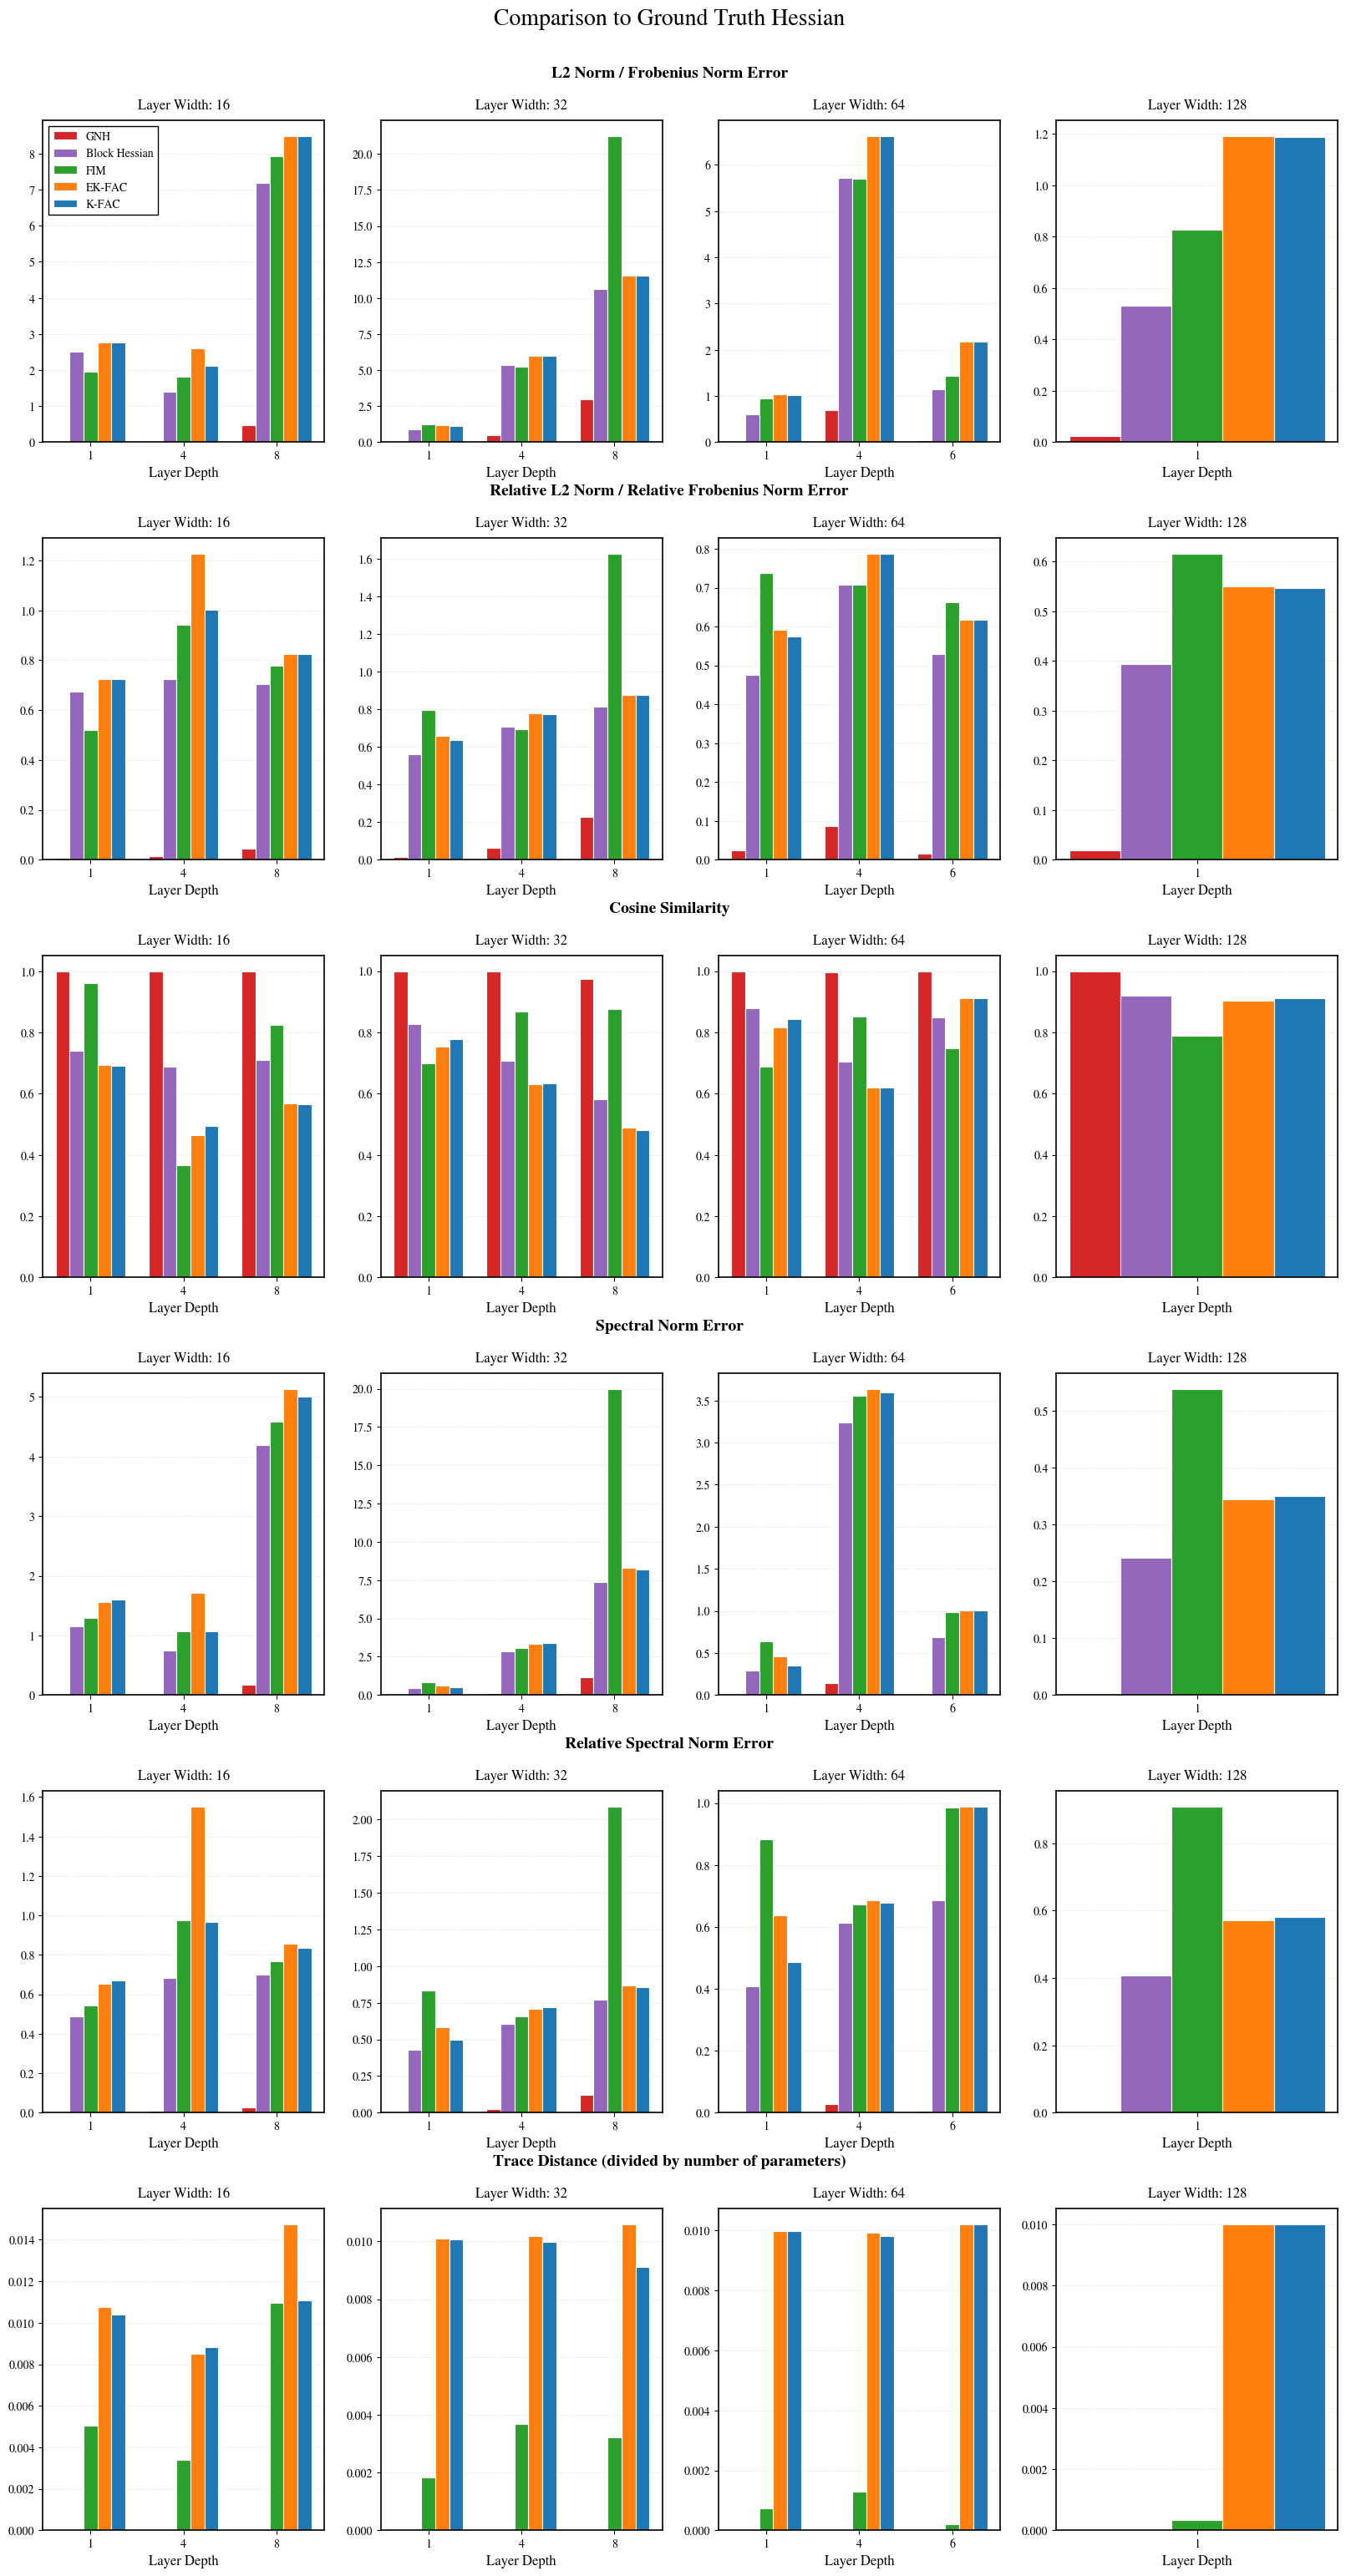

In [35]:
import matplotlib.pyplot as plt

# ---------- Matplotlib style ----------
plt.rcParams.update(
    {
        "font.size": 12,
        "font.family": "STIXGeneral",
        "mathtext.fontset": "stix",
        "text.usetex": False,
        "axes.linewidth": 1.2,
        "grid.linewidth": 0.5,
        "lines.linewidth": 2,
        "legend.frameon": True,
        "legend.fancybox": False,
        "legend.edgecolor": "black",
        "legend.framealpha": 1.0,
    }
)

# ---------- Consistent colors ----------
colors = {
    "kfac": "#1f77b4",
    "ekfac": "#ff7f0e",
    "gnh": "#d62728",
    "fim": "#2ca02c",
    "block_hessian": "#9467bd",
}

bar_width = 0.15

width_configs = [
    (results_mlp_16, layer_depths_16, "Layer Width: 16"),
    (results_mlp_32, layer_depths_32, "Layer Width: 32"),
    (results_mlp_64, layer_depths_64, "Layer Width: 64"),
    (results_mlp_128, layer_depths_128, "Layer Width: 128"),
]

n_metrics = len(matrix_metrics_to_plot)

# Create main figure with GridSpec for better control
fig = plt.figure(figsize=(20, 5 * n_metrics))
gs = GridSpec(n_metrics, 1, figure=fig, hspace=0.5)

for metric_idx, (metric, metric_label) in enumerate(matrix_metrics_to_plot):
    # Create subfigure for this metric
    subfig = fig.add_subfigure(gs[metric_idx, 0])

    # Create 1x4 subplots within this subfigure
    axs = subfig.subplots(1, 4)

    # Set the metric as suptitle for this subfigure with higher position
    subfig.suptitle(metric_label, fontsize=14, fontweight="bold", y=1.01)

    for width_idx, (multiple_results, layer_depths, width_title) in enumerate(
        width_configs
    ):
        ax = axs[width_idx]

        # extract per-model results
        single_results = [
            entry["hessian_analysis"]["matrix_comparisons"][metric]["exact"]
            for entry in multiple_results
        ]

        n_methods = len(hessian_estimator_mapping)

        # ---- categorical positions (constant spacing!) ----
        x_pos = list(range(len(layer_depths)))

        for m, (method, label) in enumerate(hessian_estimator_mapping.items()):
            values = [entry[method] for entry in single_results]

            offsets = [
                p - (n_methods - 1) * bar_width / 2 + m * bar_width for p in x_pos
            ]

            ax.bar(
                offsets,
                values,
                width=bar_width,
                label=label,
                color=colors.get(method),
                edgecolor="white",
                linewidth=0.8,
            )

        # ---------- Axis formatting ----------
        ax.set_xticks(x_pos)
        ax.set_xticklabels([str(d) for d in layer_depths], fontsize=11)

        # Only show x-label on bottom row
        ax.set_xlabel("Layer Depth", fontsize=12)

        # Show width title
        ax.set_title(width_title, fontsize=12, pad=10)

        # Grid & spines
        ax.grid(True, axis="y", alpha=0.3, linestyle="--")
        ax.set_axisbelow(True)

        for spine in ax.spines.values():
            spine.set_linewidth(1.2)
            spine.set_color("black")

        ax.tick_params(axis="both", which="major", labelsize=10)

        # Legend only in top-left
        if metric_idx == 0 and width_idx == 0:
            ax.legend(loc="upper left", fontsize=10)

# Overall title
fig.suptitle(r"Comparison to Ground Truth Hessian", fontsize=20, y=1.025)

plt.show()

#### HVPs

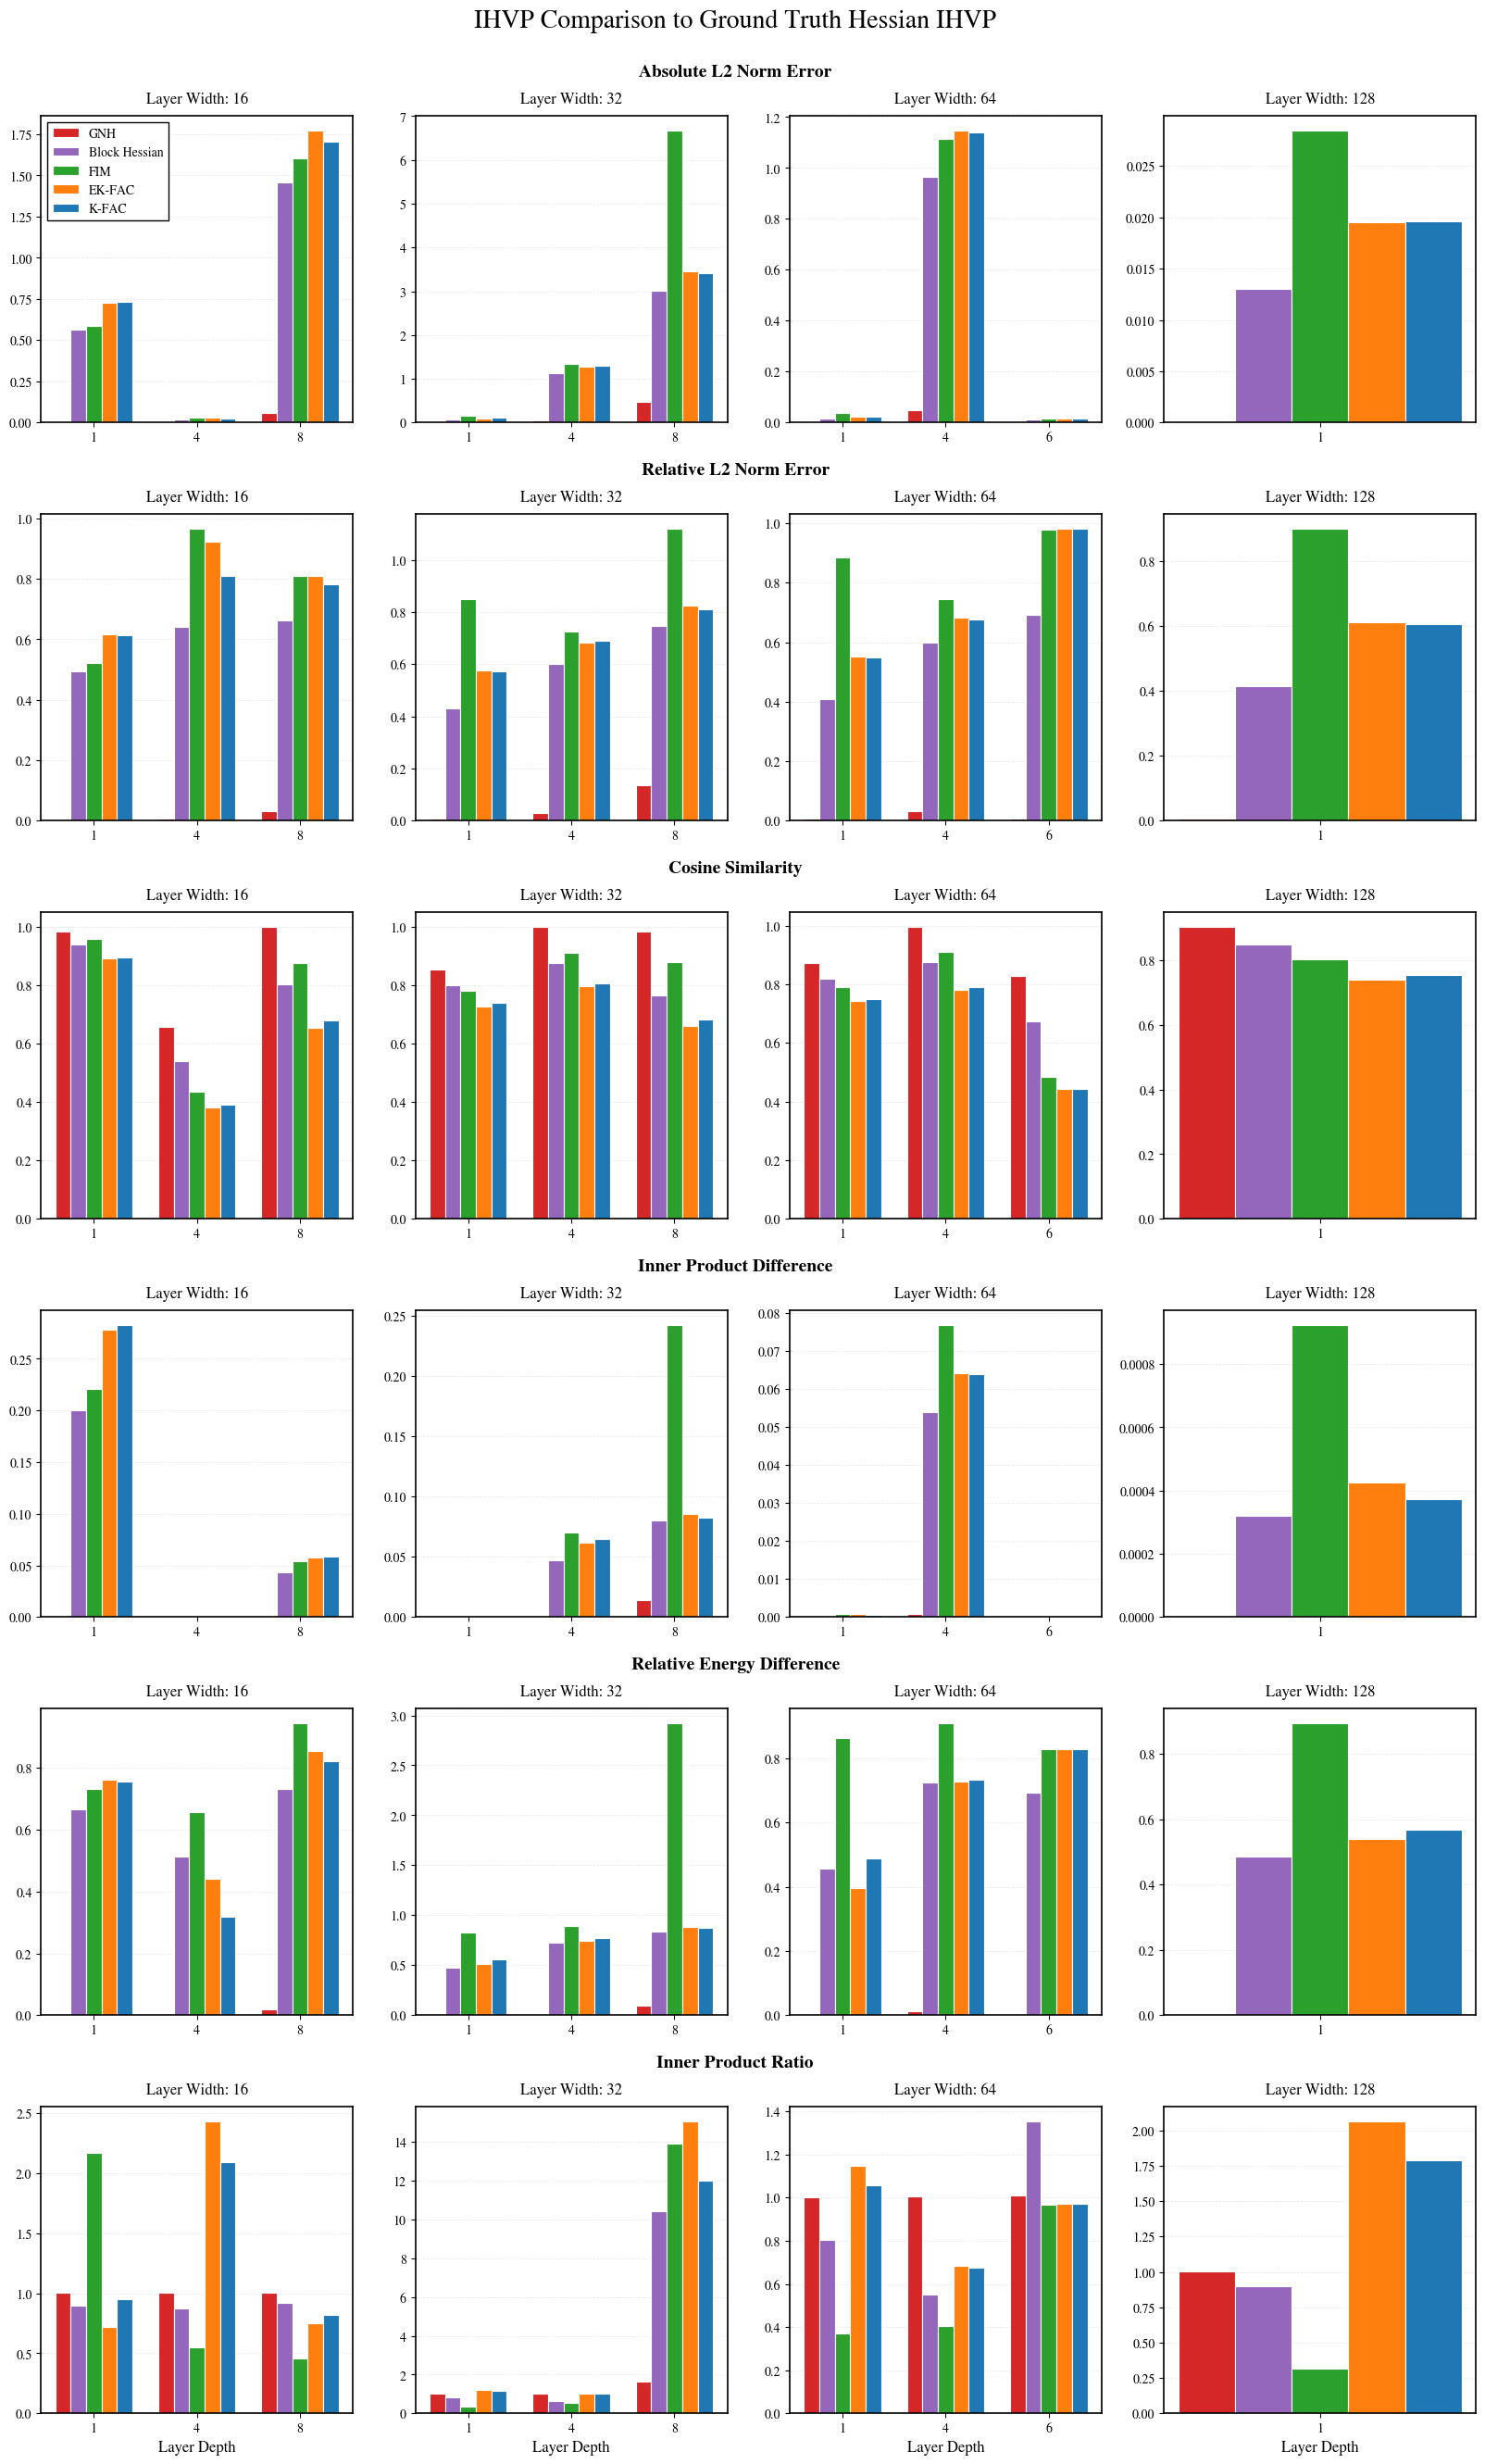

In [22]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ---------- Matplotlib style ----------
plt.rcParams.update(
    {
        "font.size": 12,
        "font.family": "STIXGeneral",
        "mathtext.fontset": "stix",
        "text.usetex": False,
        "axes.linewidth": 1.2,
        "grid.linewidth": 0.5,
        "lines.linewidth": 2,
        "legend.frameon": True,
        "legend.fancybox": False,
        "legend.edgecolor": "black",
        "legend.framealpha": 1.0,
    }
)

# ---------- Consistent colors ----------
colors = {
    "kfac": "#1f77b4",
    "ekfac": "#ff7f0e",
    "gnh": "#d62728",
    "fim": "#2ca02c",
    "block_hessian": "#9467bd",
}

bar_width = 0.15

width_configs = [
    (results_mlp_16, layer_depths_16, "Layer Width: 16"),
    (results_mlp_32, layer_depths_32, "Layer Width: 32"),
    (results_mlp_64, layer_depths_64, "Layer Width: 64"),
    (results_mlp_128, layer_depths_128, "Layer Width: 128"),
]

n_metrics = len(matrix_metrics_to_plot)

# Create main figure with GridSpec for better control
fig = plt.figure(figsize=(20, 4.3 * n_metrics))
gs = GridSpec(n_metrics, 1, figure=fig, hspace=0.5)

for metric_idx, (metric, metric_label) in enumerate(vector_metrics_to_plot):
    # Create subfigure for this metric
    subfig = fig.add_subfigure(gs[metric_idx, 0])

    # Create 1x4 subplots within this subfigure
    axs = subfig.subplots(1, 4)

    # Set the metric as suptitle for this subfigure with higher position
    subfig.suptitle(metric_label, fontsize=14, fontweight="bold", y=1.01)

    for width_idx, (multiple_results, layer_depths, width_title) in enumerate(
        width_configs
    ):
        ax = axs[width_idx]

        # extract per-model results
        single_results = [
            entry["hessian_analysis"]["hvp_comparisons"][metric]["exact"]
            for entry in multiple_results
        ]

        n_methods = len(hessian_estimator_mapping)

        # ---- categorical positions (constant spacing!) ----
        x_pos = list(range(len(layer_depths)))

        for m, (method, label) in enumerate(hessian_estimator_mapping.items()):
            values = [entry[method] for entry in single_results]

            offsets = [
                p - (n_methods - 1) * bar_width / 2 + m * bar_width for p in x_pos
            ]

            ax.bar(
                offsets,
                values,
                width=bar_width,
                label=label,
                color=colors.get(method),
                edgecolor="white",
                linewidth=0.8,
            )

        # ---------- Axis formatting ----------
        ax.set_xticks(x_pos)
        ax.set_xticklabels([str(d) for d in layer_depths], fontsize=11)

        # Only show x-label on bottom row
        if metric_idx == n_metrics - 1:
            ax.set_xlabel("Layer Depth", fontsize=12)

        # Show width title
        ax.set_title(width_title, fontsize=12, pad=10)

        # Grid & spines
        ax.grid(True, axis="y", alpha=0.3, linestyle="--")
        ax.set_axisbelow(True)

        for spine in ax.spines.values():
            spine.set_linewidth(1.2)
            spine.set_color("black")

        ax.tick_params(axis="both", which="major", labelsize=10)

        # Legend only in top-left
        if metric_idx == 0 and width_idx == 0:
            ax.legend(loc="upper left", fontsize=10)

# Overall title
fig.suptitle(r"IHVP Comparison to Ground Truth Hessian IHVP", fontsize=20, y=1.025)

plt.show()

#### IHVPs

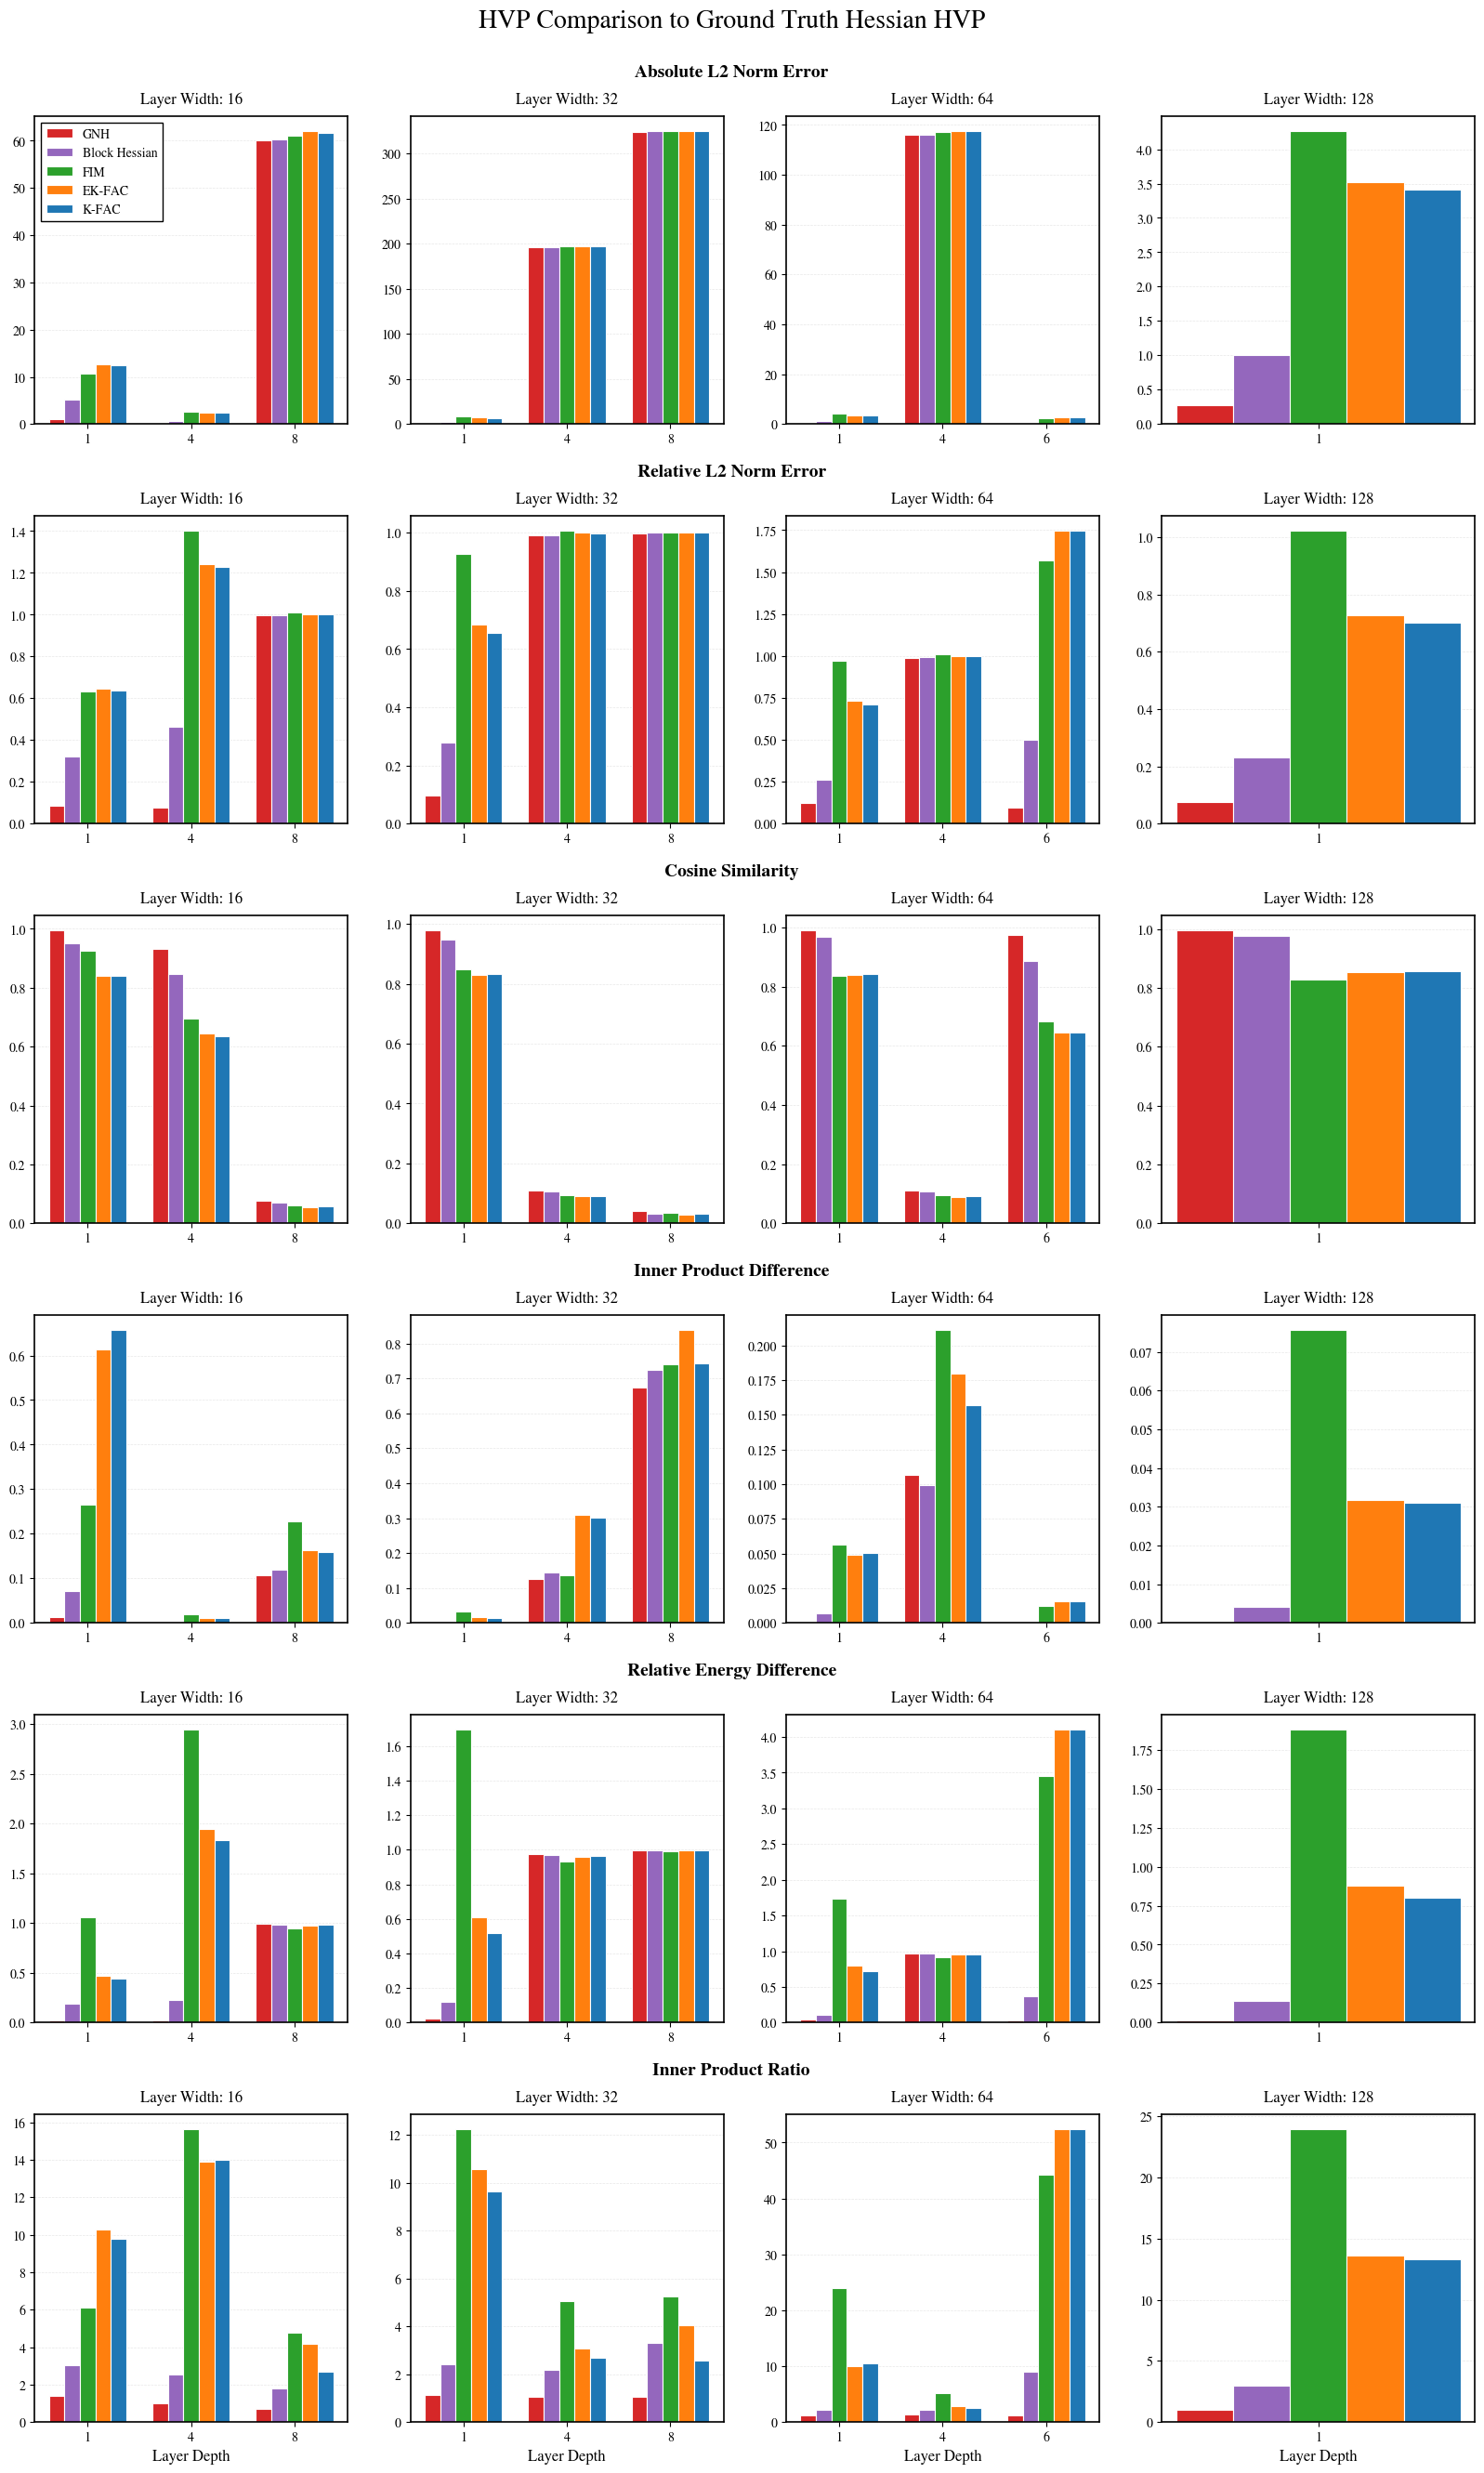

In [23]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ---------- Matplotlib style ----------
plt.rcParams.update(
    {
        "font.size": 12,
        "font.family": "STIXGeneral",
        "mathtext.fontset": "stix",
        "text.usetex": False,
        "axes.linewidth": 1.2,
        "grid.linewidth": 0.5,
        "lines.linewidth": 2,
        "legend.frameon": True,
        "legend.fancybox": False,
        "legend.edgecolor": "black",
        "legend.framealpha": 1.0,
    }
)

# ---------- Consistent colors ----------
colors = {
    "kfac": "#1f77b4",
    "ekfac": "#ff7f0e",
    "gnh": "#d62728",
    "fim": "#2ca02c",
    "block_hessian": "#9467bd",
}

bar_width = 0.15

width_configs = [
    (results_mlp_16, layer_depths_16, "Layer Width: 16"),
    (results_mlp_32, layer_depths_32, "Layer Width: 32"),
    (results_mlp_64, layer_depths_64, "Layer Width: 64"),
    (results_mlp_128, layer_depths_128, "Layer Width: 128"),
]

n_metrics = len(matrix_metrics_to_plot)

# Create main figure with GridSpec for better control
fig = plt.figure(figsize=(20, 4.3 * n_metrics))
gs = GridSpec(n_metrics, 1, figure=fig, hspace=0.5)

for metric_idx, (metric, metric_label) in enumerate(vector_metrics_to_plot):
    # Create subfigure for this metric
    subfig = fig.add_subfigure(gs[metric_idx, 0])

    # Create 1x4 subplots within this subfigure
    axs = subfig.subplots(1, 4)

    # Set the metric as suptitle for this subfigure with higher position
    subfig.suptitle(metric_label, fontsize=14, fontweight="bold", y=1.01)

    for width_idx, (multiple_results, layer_depths, width_title) in enumerate(
        width_configs
    ):
        ax = axs[width_idx]

        # extract per-model results
        single_results = [
            entry["hessian_analysis"]["ihvp_comparisons"][metric]["exact"]
            for entry in multiple_results
        ]

        n_methods = len(hessian_estimator_mapping)

        # ---- categorical positions (constant spacing!) ----
        x_pos = list(range(len(layer_depths)))

        for m, (method, label) in enumerate(hessian_estimator_mapping.items()):
            values = [entry[method] for entry in single_results]

            offsets = [
                p - (n_methods - 1) * bar_width / 2 + m * bar_width for p in x_pos
            ]

            ax.bar(
                offsets,
                values,
                width=bar_width,
                label=label,
                color=colors.get(method),
                edgecolor="white",
                linewidth=0.8,
            )

        # ---------- Axis formatting ----------
        ax.set_xticks(x_pos)
        ax.set_xticklabels([str(d) for d in layer_depths], fontsize=11)

        # Only show x-label on bottom row
        if metric_idx == n_metrics - 1:
            ax.set_xlabel("Layer Depth", fontsize=12)

        # Show width title
        ax.set_title(width_title, fontsize=12, pad=10)

        # Grid & spines
        ax.grid(True, axis="y", alpha=0.3, linestyle="--")
        ax.set_axisbelow(True)

        for spine in ax.spines.values():
            spine.set_linewidth(1.2)
            spine.set_color("black")

        ax.tick_params(axis="both", which="major", labelsize=10)

        # Legend only in top-left
        if metric_idx == 0 and width_idx == 0:
            ax.legend(loc="upper left", fontsize=10)

# Overall title
fig.suptitle(r"HVP Comparison to Ground Truth Hessian HVP", fontsize=20, y=1.025)

plt.show()

### Comparison with GNH

#### Full GNH

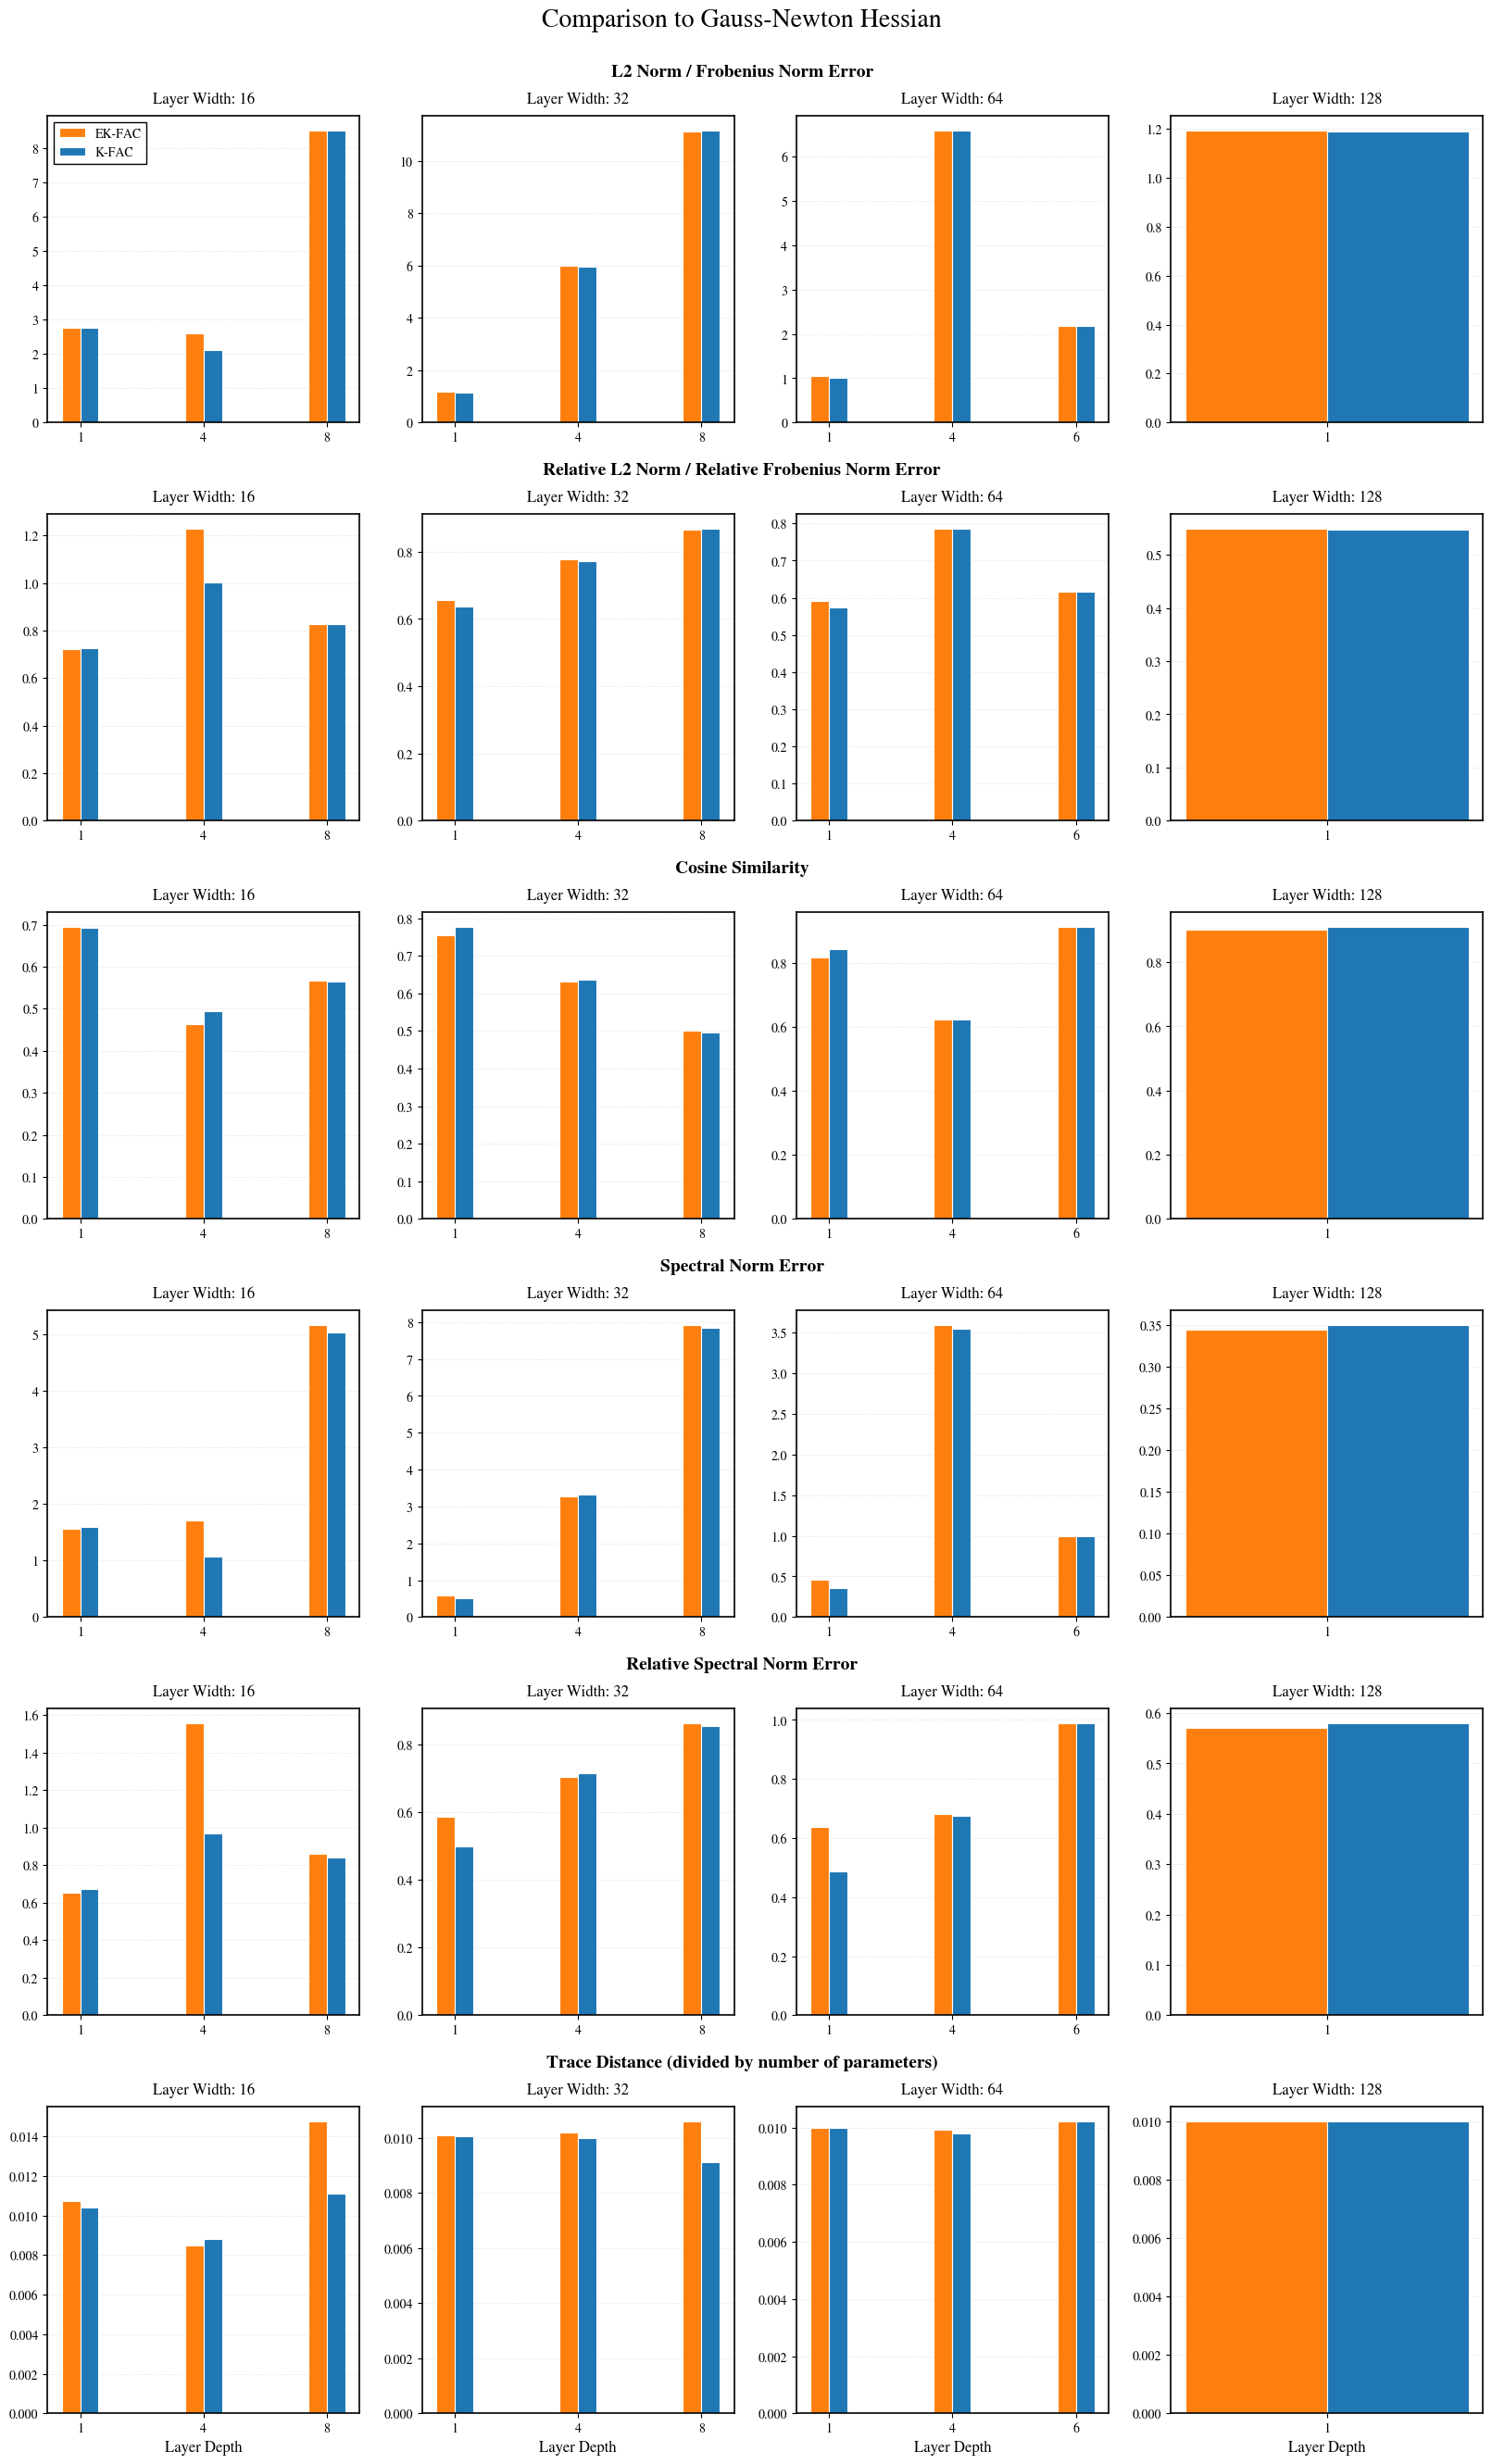

In [24]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ---------- Matplotlib style ----------
plt.rcParams.update(
    {
        "font.size": 12,
        "font.family": "STIXGeneral",
        "mathtext.fontset": "stix",
        "text.usetex": False,
        "axes.linewidth": 1.2,
        "grid.linewidth": 0.5,
        "lines.linewidth": 2,
        "legend.frameon": True,
        "legend.fancybox": False,
        "legend.edgecolor": "black",
        "legend.framealpha": 1.0,
    }
)

# ---------- Consistent colors ----------
colors = {
    "kfac": "#1f77b4",
    "ekfac": "#ff7f0e",
    "gnh": "#d62728",
    "fim": "#2ca02c",
    "block_hessian": "#9467bd",
}

bar_width = 0.15

width_configs = [
    (results_mlp_16, layer_depths_16, "Layer Width: 16"),
    (results_mlp_32, layer_depths_32, "Layer Width: 32"),
    (results_mlp_64, layer_depths_64, "Layer Width: 64"),
    (results_mlp_128, layer_depths_128, "Layer Width: 128"),
]

n_metrics = len(matrix_metrics_to_plot)

# Create main figure with GridSpec for better control
fig = plt.figure(figsize=(20, 4.3 * n_metrics))
gs = GridSpec(n_metrics, 1, figure=fig, hspace=0.5)

for metric_idx, (metric, metric_label) in enumerate(matrix_metrics_to_plot):
    # Create subfigure for this metric
    subfig = fig.add_subfigure(gs[metric_idx, 0])

    # Create 1x4 subplots within this subfigure
    axs = subfig.subplots(1, 4)

    # Set the metric as suptitle for this subfigure with higher position
    subfig.suptitle(metric_label, fontsize=14, fontweight="bold", y=1.01)

    for width_idx, (multiple_results, layer_depths, width_title) in enumerate(
        width_configs
    ):
        ax = axs[width_idx]

        # extract per-model results
        single_results = [
            entry["hessian_analysis"]["matrix_comparisons"][metric]["gnh"]
            for entry in multiple_results
        ]

        n_methods = len(gnh_estimator_mapping)

        # ---- categorical positions (constant spacing!) ----
        x_pos = list(range(len(layer_depths)))

        for m, (method, label) in enumerate(gnh_estimator_mapping.items()):
            values = [entry[method] for entry in single_results]

            offsets = [
                p - (n_methods - 1) * bar_width / 2 + m * bar_width for p in x_pos
            ]

            ax.bar(
                offsets,
                values,
                width=bar_width,
                label=label,
                color=colors.get(method),
                edgecolor="white",
                linewidth=0.8,
            )

        # ---------- Axis formatting ----------
        ax.set_xticks(x_pos)
        ax.set_xticklabels([str(d) for d in layer_depths], fontsize=11)

        # Only show x-label on bottom row
        if metric_idx == n_metrics - 1:
            ax.set_xlabel("Layer Depth", fontsize=12)

        # Show width title
        ax.set_title(width_title, fontsize=12, pad=10)

        # Grid & spines
        ax.grid(True, axis="y", alpha=0.3, linestyle="--")
        ax.set_axisbelow(True)

        for spine in ax.spines.values():
            spine.set_linewidth(1.2)
            spine.set_color("black")

        ax.tick_params(axis="both", which="major", labelsize=10)

        # Legend only in top-left
        if metric_idx == 0 and width_idx == 0:
            ax.legend(loc="upper left", fontsize=10)

# Overall title
fig.suptitle(r"Comparison to Gauss-Newton Hessian", fontsize=20, y=1.025)

plt.show()

#### HVPs

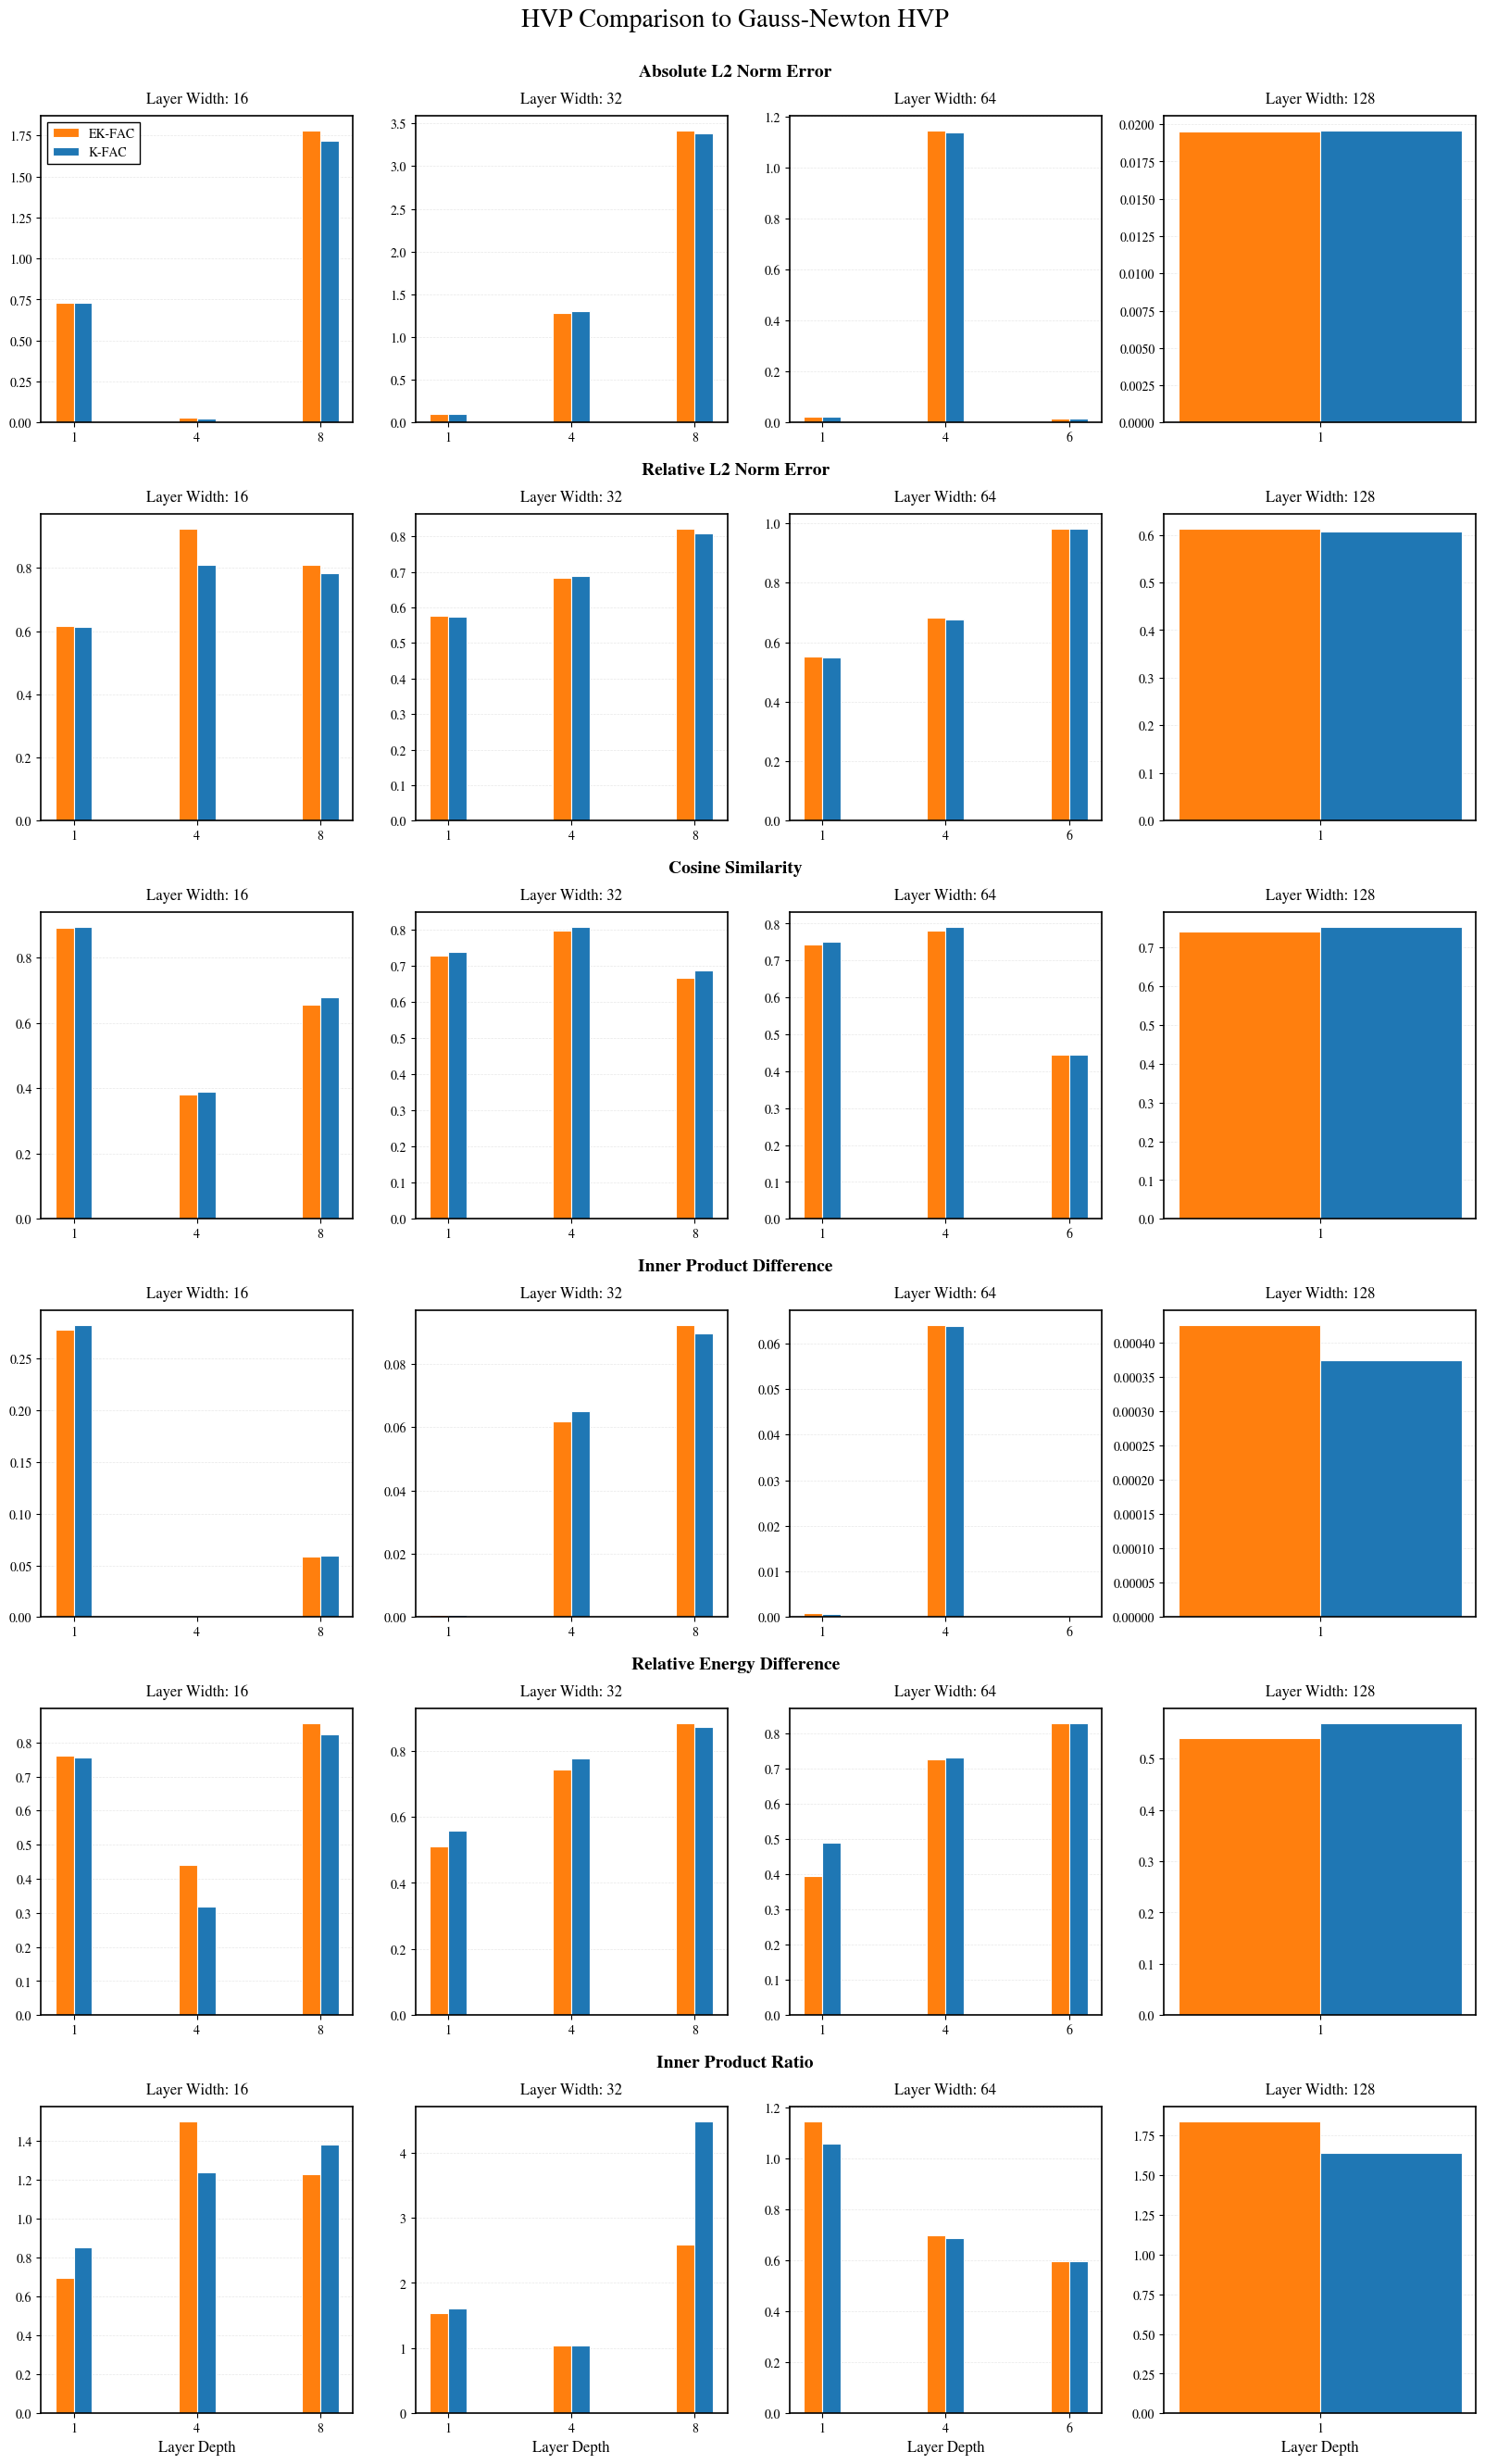

In [25]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ---------- Matplotlib style ----------
plt.rcParams.update(
    {
        "font.size": 12,
        "font.family": "STIXGeneral",
        "mathtext.fontset": "stix",
        "text.usetex": False,
        "axes.linewidth": 1.2,
        "grid.linewidth": 0.5,
        "lines.linewidth": 2,
        "legend.frameon": True,
        "legend.fancybox": False,
        "legend.edgecolor": "black",
        "legend.framealpha": 1.0,
    }
)

# ---------- Consistent colors ----------
colors = {
    "kfac": "#1f77b4",
    "ekfac": "#ff7f0e",
    "gnh": "#d62728",
    "fim": "#2ca02c",
    "block_hessian": "#9467bd",
}

bar_width = 0.15

width_configs = [
    (results_mlp_16, layer_depths_16, "Layer Width: 16"),
    (results_mlp_32, layer_depths_32, "Layer Width: 32"),
    (results_mlp_64, layer_depths_64, "Layer Width: 64"),
    (results_mlp_128, layer_depths_128, "Layer Width: 128"),
]

n_metrics = len(matrix_metrics_to_plot)

# Create main figure with GridSpec for better control
fig = plt.figure(figsize=(20, 4.3 * n_metrics))
gs = GridSpec(n_metrics, 1, figure=fig, hspace=0.5)

for metric_idx, (metric, metric_label) in enumerate(vector_metrics_to_plot):
    # Create subfigure for this metric
    subfig = fig.add_subfigure(gs[metric_idx, 0])

    # Create 1x4 subplots within this subfigure
    axs = subfig.subplots(1, 4)

    # Set the metric as suptitle for this subfigure with higher position
    subfig.suptitle(metric_label, fontsize=14, fontweight="bold", y=1.01)

    for width_idx, (multiple_results, layer_depths, width_title) in enumerate(
        width_configs
    ):
        ax = axs[width_idx]

        # extract per-model results
        single_results = [
            entry["hessian_analysis"]["hvp_comparisons"][metric]["gnh"]
            for entry in multiple_results
        ]

        n_methods = len(gnh_estimator_mapping)

        # ---- categorical positions (constant spacing!) ----
        x_pos = list(range(len(layer_depths)))

        for m, (method, label) in enumerate(gnh_estimator_mapping.items()):
            values = [entry[method] for entry in single_results]

            offsets = [
                p - (n_methods - 1) * bar_width / 2 + m * bar_width for p in x_pos
            ]

            ax.bar(
                offsets,
                values,
                width=bar_width,
                label=label,
                color=colors.get(method),
                edgecolor="white",
                linewidth=0.8,
            )

        # ---------- Axis formatting ----------
        ax.set_xticks(x_pos)
        ax.set_xticklabels([str(d) for d in layer_depths], fontsize=11)

        # Only show x-label on bottom row
        if metric_idx == n_metrics - 1:
            ax.set_xlabel("Layer Depth", fontsize=12)

        # Show width title
        ax.set_title(width_title, fontsize=12, pad=10)

        # Grid & spines
        ax.grid(True, axis="y", alpha=0.3, linestyle="--")
        ax.set_axisbelow(True)

        for spine in ax.spines.values():
            spine.set_linewidth(1.2)
            spine.set_color("black")

        ax.tick_params(axis="both", which="major", labelsize=10)

        # Legend only in top-left
        if metric_idx == 0 and width_idx == 0:
            ax.legend(loc="upper left", fontsize=10)

# Overall title
fig.suptitle(r"HVP Comparison to Gauss-Newton HVP", fontsize=20, y=1.025)

plt.show()

#### IHVPs

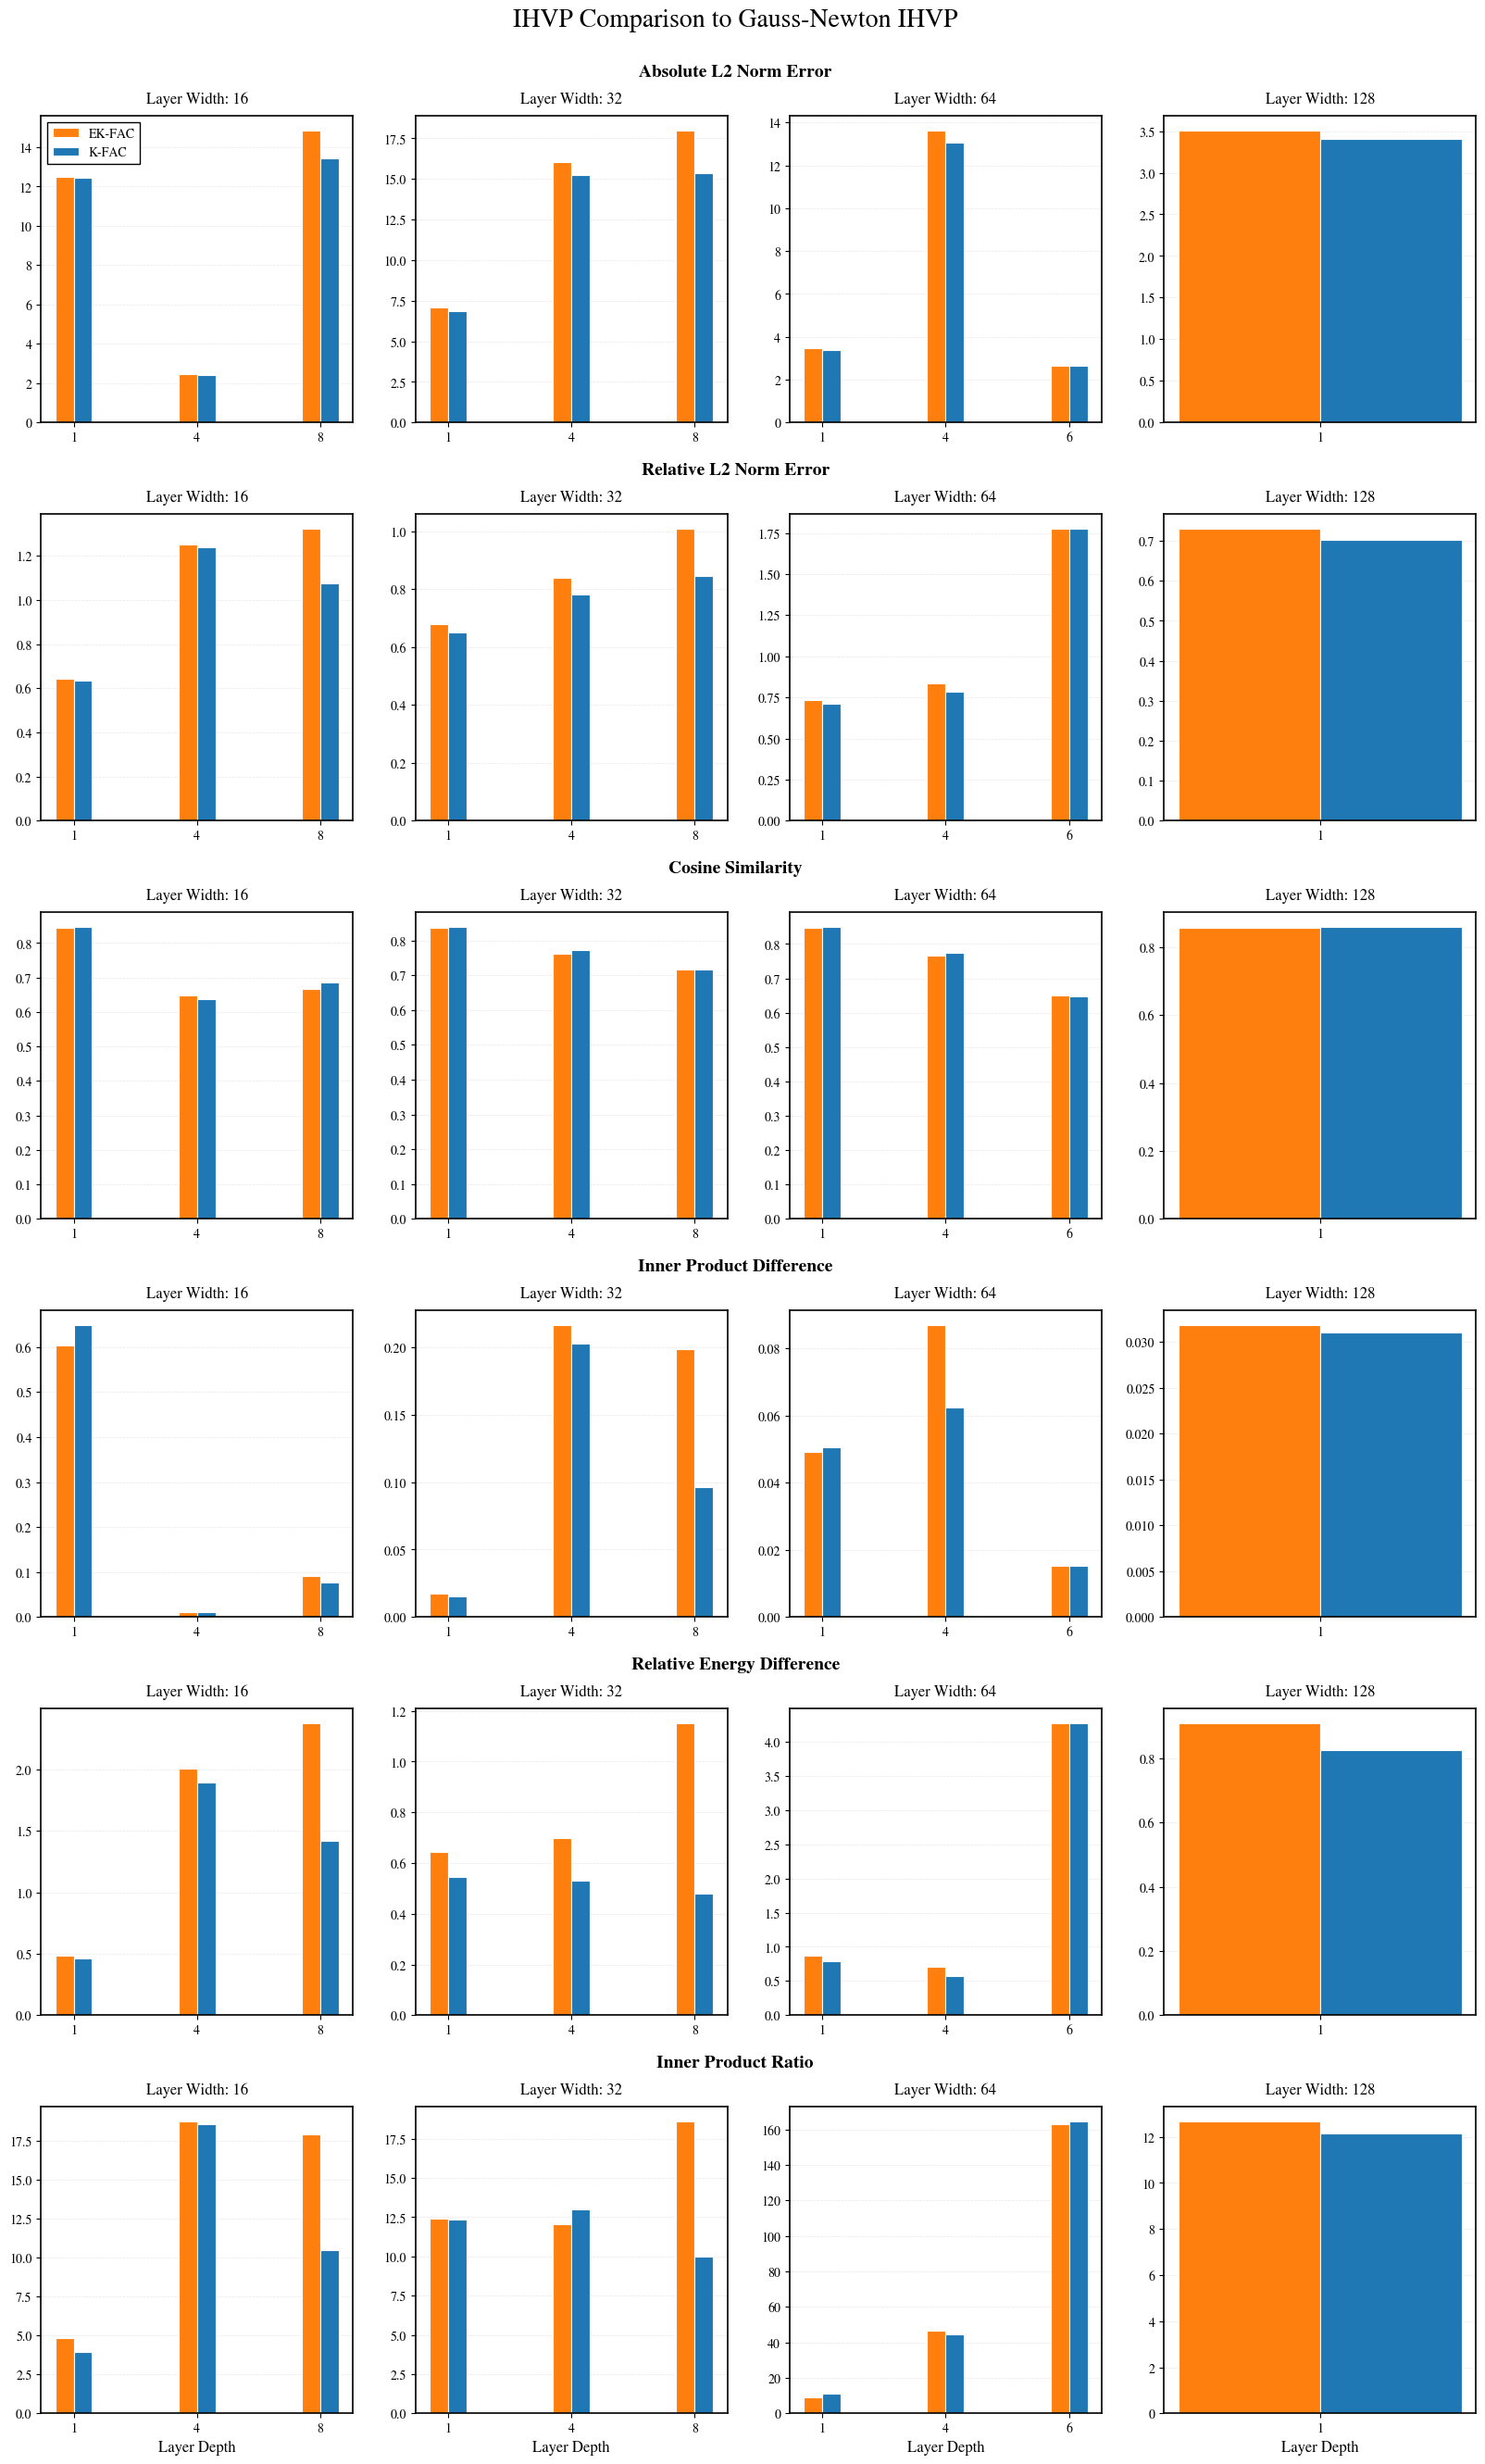

In [26]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ---------- Matplotlib style ----------
plt.rcParams.update(
    {
        "font.size": 12,
        "font.family": "STIXGeneral",
        "mathtext.fontset": "stix",
        "text.usetex": False,
        "axes.linewidth": 1.2,
        "grid.linewidth": 0.5,
        "lines.linewidth": 2,
        "legend.frameon": True,
        "legend.fancybox": False,
        "legend.edgecolor": "black",
        "legend.framealpha": 1.0,
    }
)

# ---------- Consistent colors ----------
colors = {
    "kfac": "#1f77b4",
    "ekfac": "#ff7f0e",
    "gnh": "#d62728",
    "fim": "#2ca02c",
    "block_hessian": "#9467bd",
}

bar_width = 0.15

width_configs = [
    (results_mlp_16, layer_depths_16, "Layer Width: 16"),
    (results_mlp_32, layer_depths_32, "Layer Width: 32"),
    (results_mlp_64, layer_depths_64, "Layer Width: 64"),
    (results_mlp_128, layer_depths_128, "Layer Width: 128"),
]

n_metrics = len(matrix_metrics_to_plot)

# Create main figure with GridSpec for better control
fig = plt.figure(figsize=(20, 4.3 * n_metrics))
gs = GridSpec(n_metrics, 1, figure=fig, hspace=0.5)

for metric_idx, (metric, metric_label) in enumerate(vector_metrics_to_plot):
    # Create subfigure for this metric
    subfig = fig.add_subfigure(gs[metric_idx, 0])

    # Create 1x4 subplots within this subfigure
    axs = subfig.subplots(1, 4)

    # Set the metric as suptitle for this subfigure with higher position
    subfig.suptitle(metric_label, fontsize=14, fontweight="bold", y=1.01)

    for width_idx, (multiple_results, layer_depths, width_title) in enumerate(
        width_configs
    ):
        ax = axs[width_idx]

        # extract per-model results
        single_results = [
            entry["hessian_analysis"]["ihvp_comparisons"][metric]["gnh"]
            for entry in multiple_results
        ]

        n_methods = len(gnh_estimator_mapping)

        # ---- categorical positions (constant spacing!) ----
        x_pos = list(range(len(layer_depths)))

        for m, (method, label) in enumerate(gnh_estimator_mapping.items()):
            values = [entry[method] for entry in single_results]

            offsets = [
                p - (n_methods - 1) * bar_width / 2 + m * bar_width for p in x_pos
            ]

            ax.bar(
                offsets,
                values,
                width=bar_width,
                label=label,
                color=colors.get(method),
                edgecolor="white",
                linewidth=0.8,
            )

        # ---------- Axis formatting ----------
        ax.set_xticks(x_pos)
        ax.set_xticklabels([str(d) for d in layer_depths], fontsize=11)

        # Only show x-label on bottom row
        if metric_idx == n_metrics - 1:
            ax.set_xlabel("Layer Depth", fontsize=12)

        # Show width title
        ax.set_title(width_title, fontsize=12, pad=10)

        # Grid & spines
        ax.grid(True, axis="y", alpha=0.3, linestyle="--")
        ax.set_axisbelow(True)

        for spine in ax.spines.values():
            spine.set_linewidth(1.2)
            spine.set_color("black")

        ax.tick_params(axis="both", which="major", labelsize=10)

        # Legend only in top-left
        if metric_idx == 0 and width_idx == 0:
            ax.legend(loc="upper left", fontsize=10)

# Overall title
fig.suptitle(r"IHVP Comparison to Gauss-Newton IHVP", fontsize=20, y=1.025)

plt.show()

## SwiGLU

In [27]:
# Swiglu Results
results_swiglu = [
    entry for entry in data["experiments"] if entry["model_type"] == "MLPSwiGLU"
]


results_swiglu_16 = [
    entry for entry in results_swiglu if entry["hidden_layers"][0] == [5, 5, 6]
]
results_swiglu_32 = [
    entry for entry in results_swiglu if entry["hidden_layers"][0] == [11, 11, 10]
]
results_swiglu_64 = [
    entry for entry in results_swiglu if entry["hidden_layers"][0] == [21, 21, 22]
]
results_swiglu_128 = [
    entry for entry in results_swiglu if entry["hidden_layers"][0] == [43, 43, 42]
]

val_loss_16 = [
    entry["hyperparameter_search_summary"]["best_val_loss"]
    for entry in results_swiglu_16
]
val_loss_32 = [
    entry["hyperparameter_search_summary"]["best_val_loss"]
    for entry in results_swiglu_32
]
val_loss_64 = [
    entry["hyperparameter_search_summary"]["best_val_loss"]
    for entry in results_swiglu_64
]
val_loss_128 = [
    entry["hyperparameter_search_summary"]["best_val_loss"]
    for entry in results_swiglu_128
]

num_params_16 = [entry["num_params"] for entry in results_swiglu_16]
num_params_32 = [entry["num_params"] for entry in results_swiglu_32]
num_params_64 = [entry["num_params"] for entry in results_swiglu_64]
num_params_128 = [entry["num_params"] for entry in results_swiglu_128]


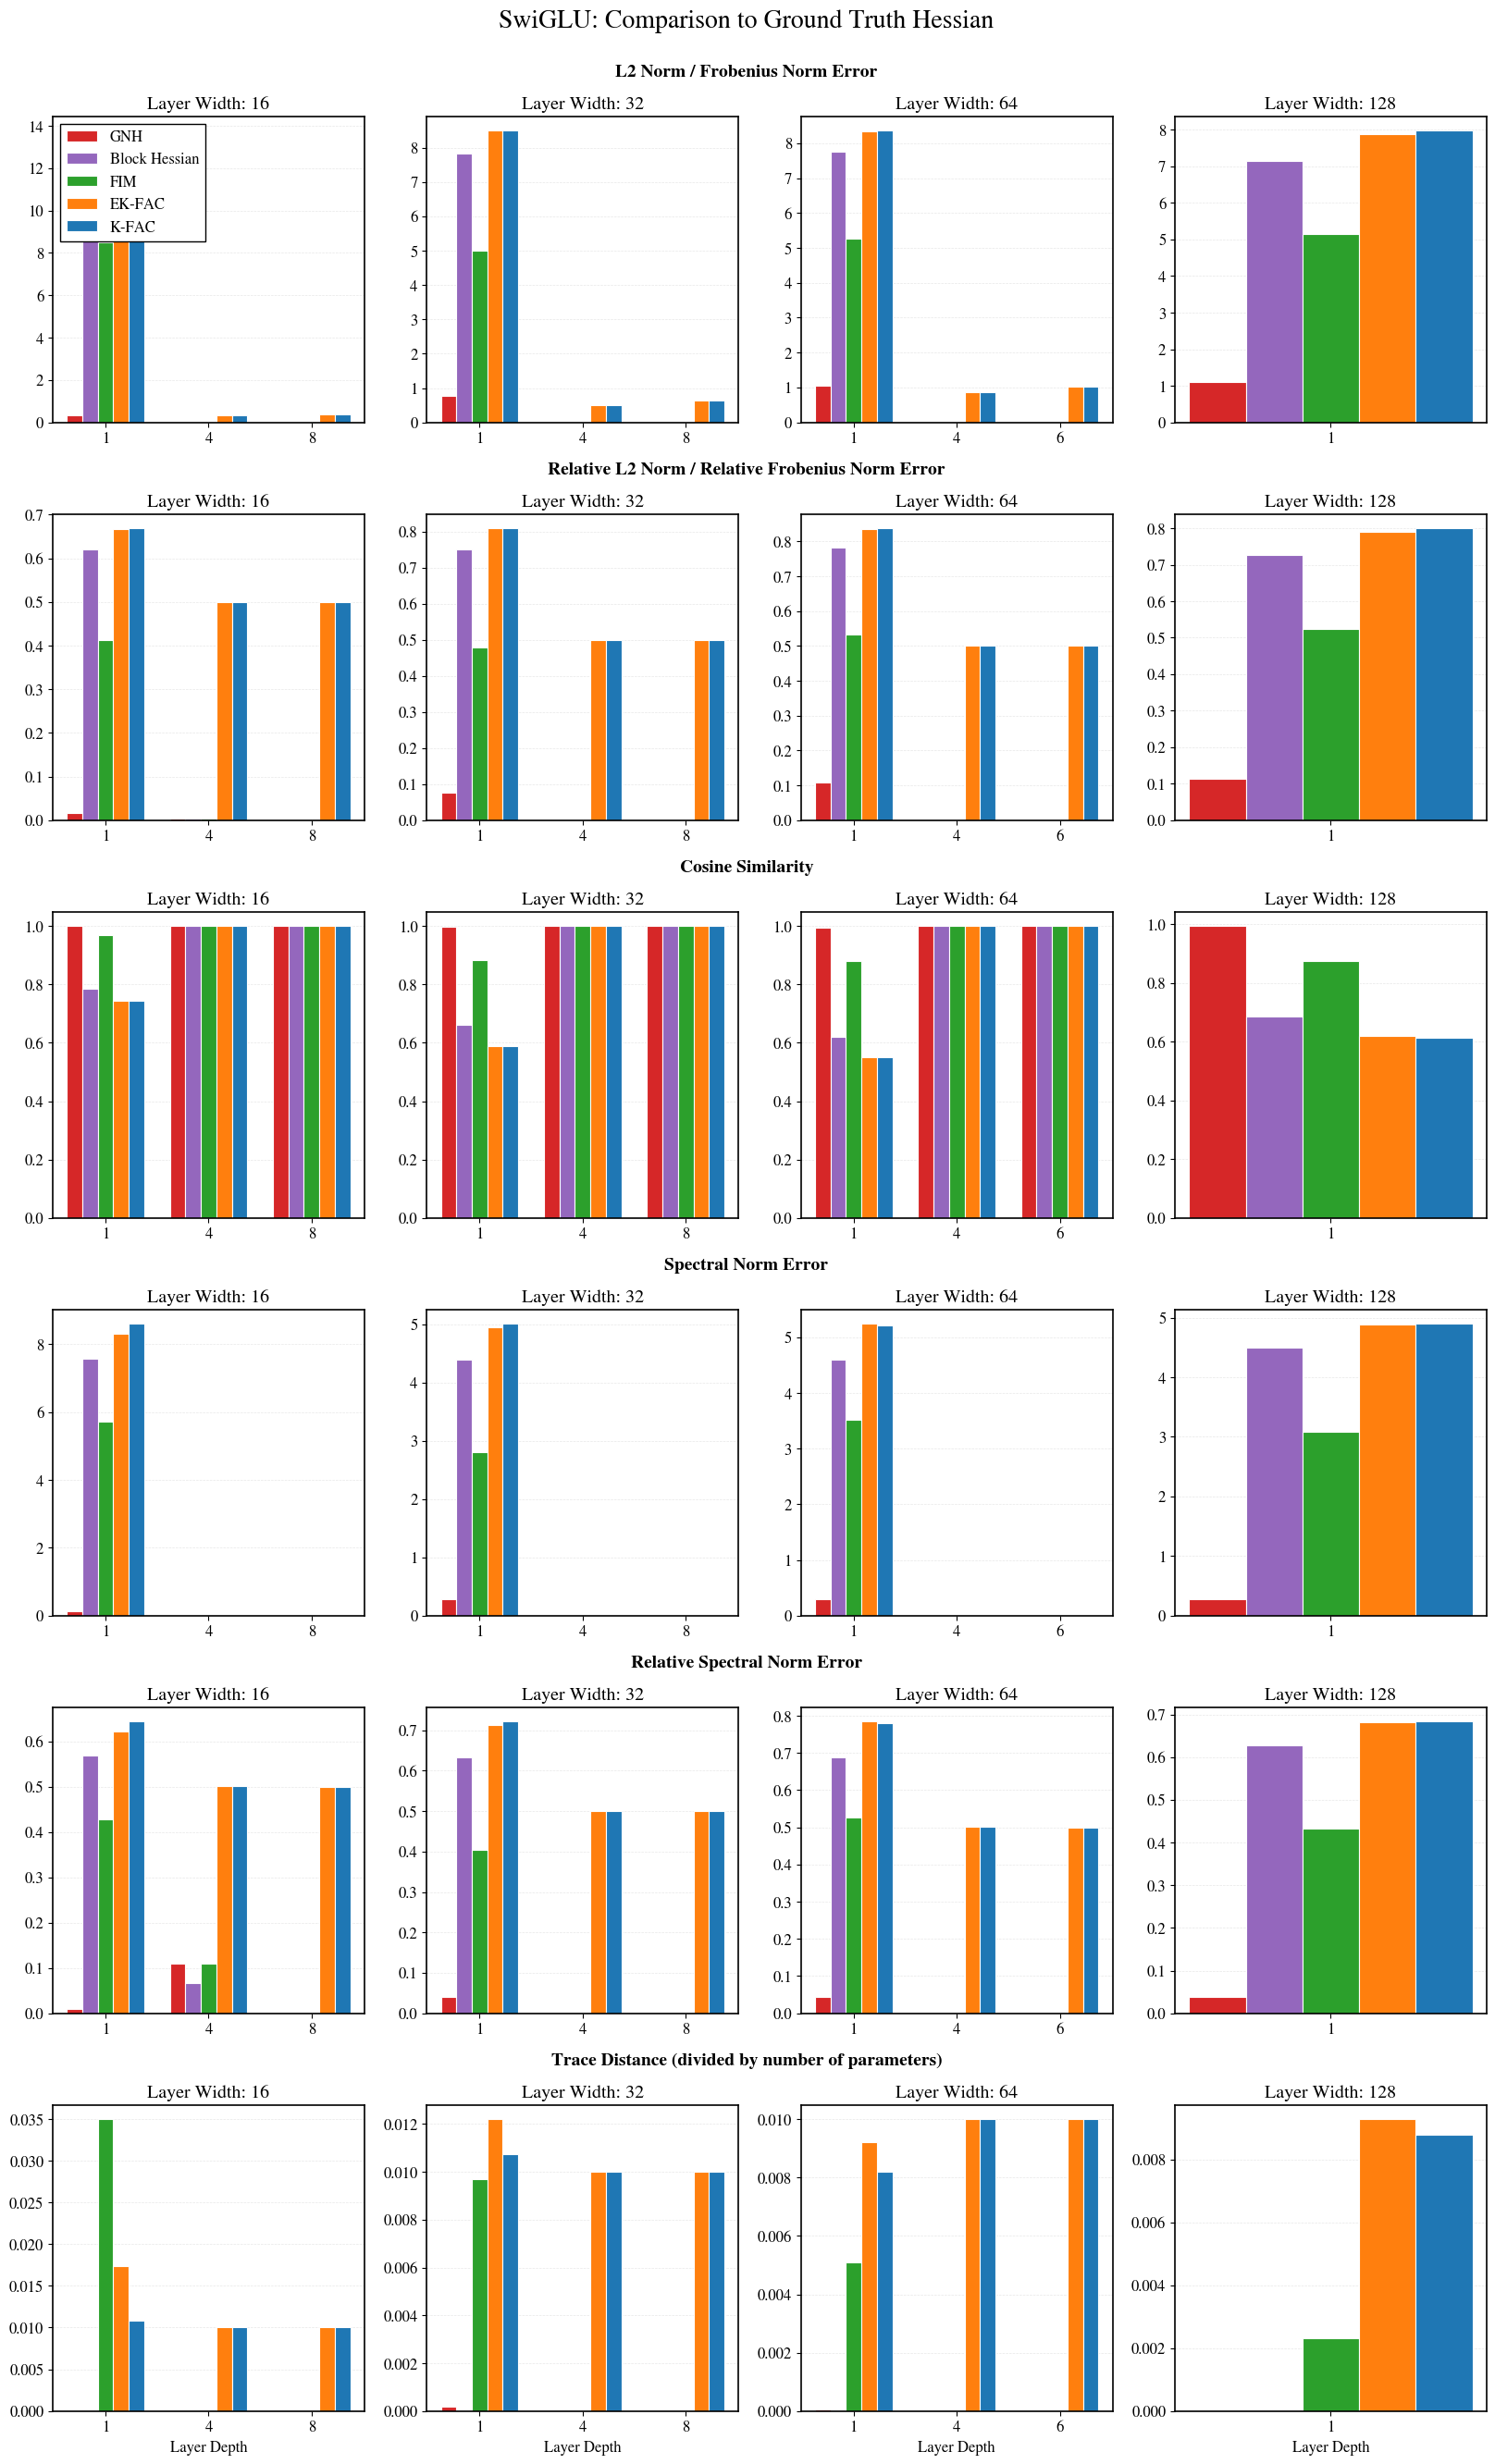

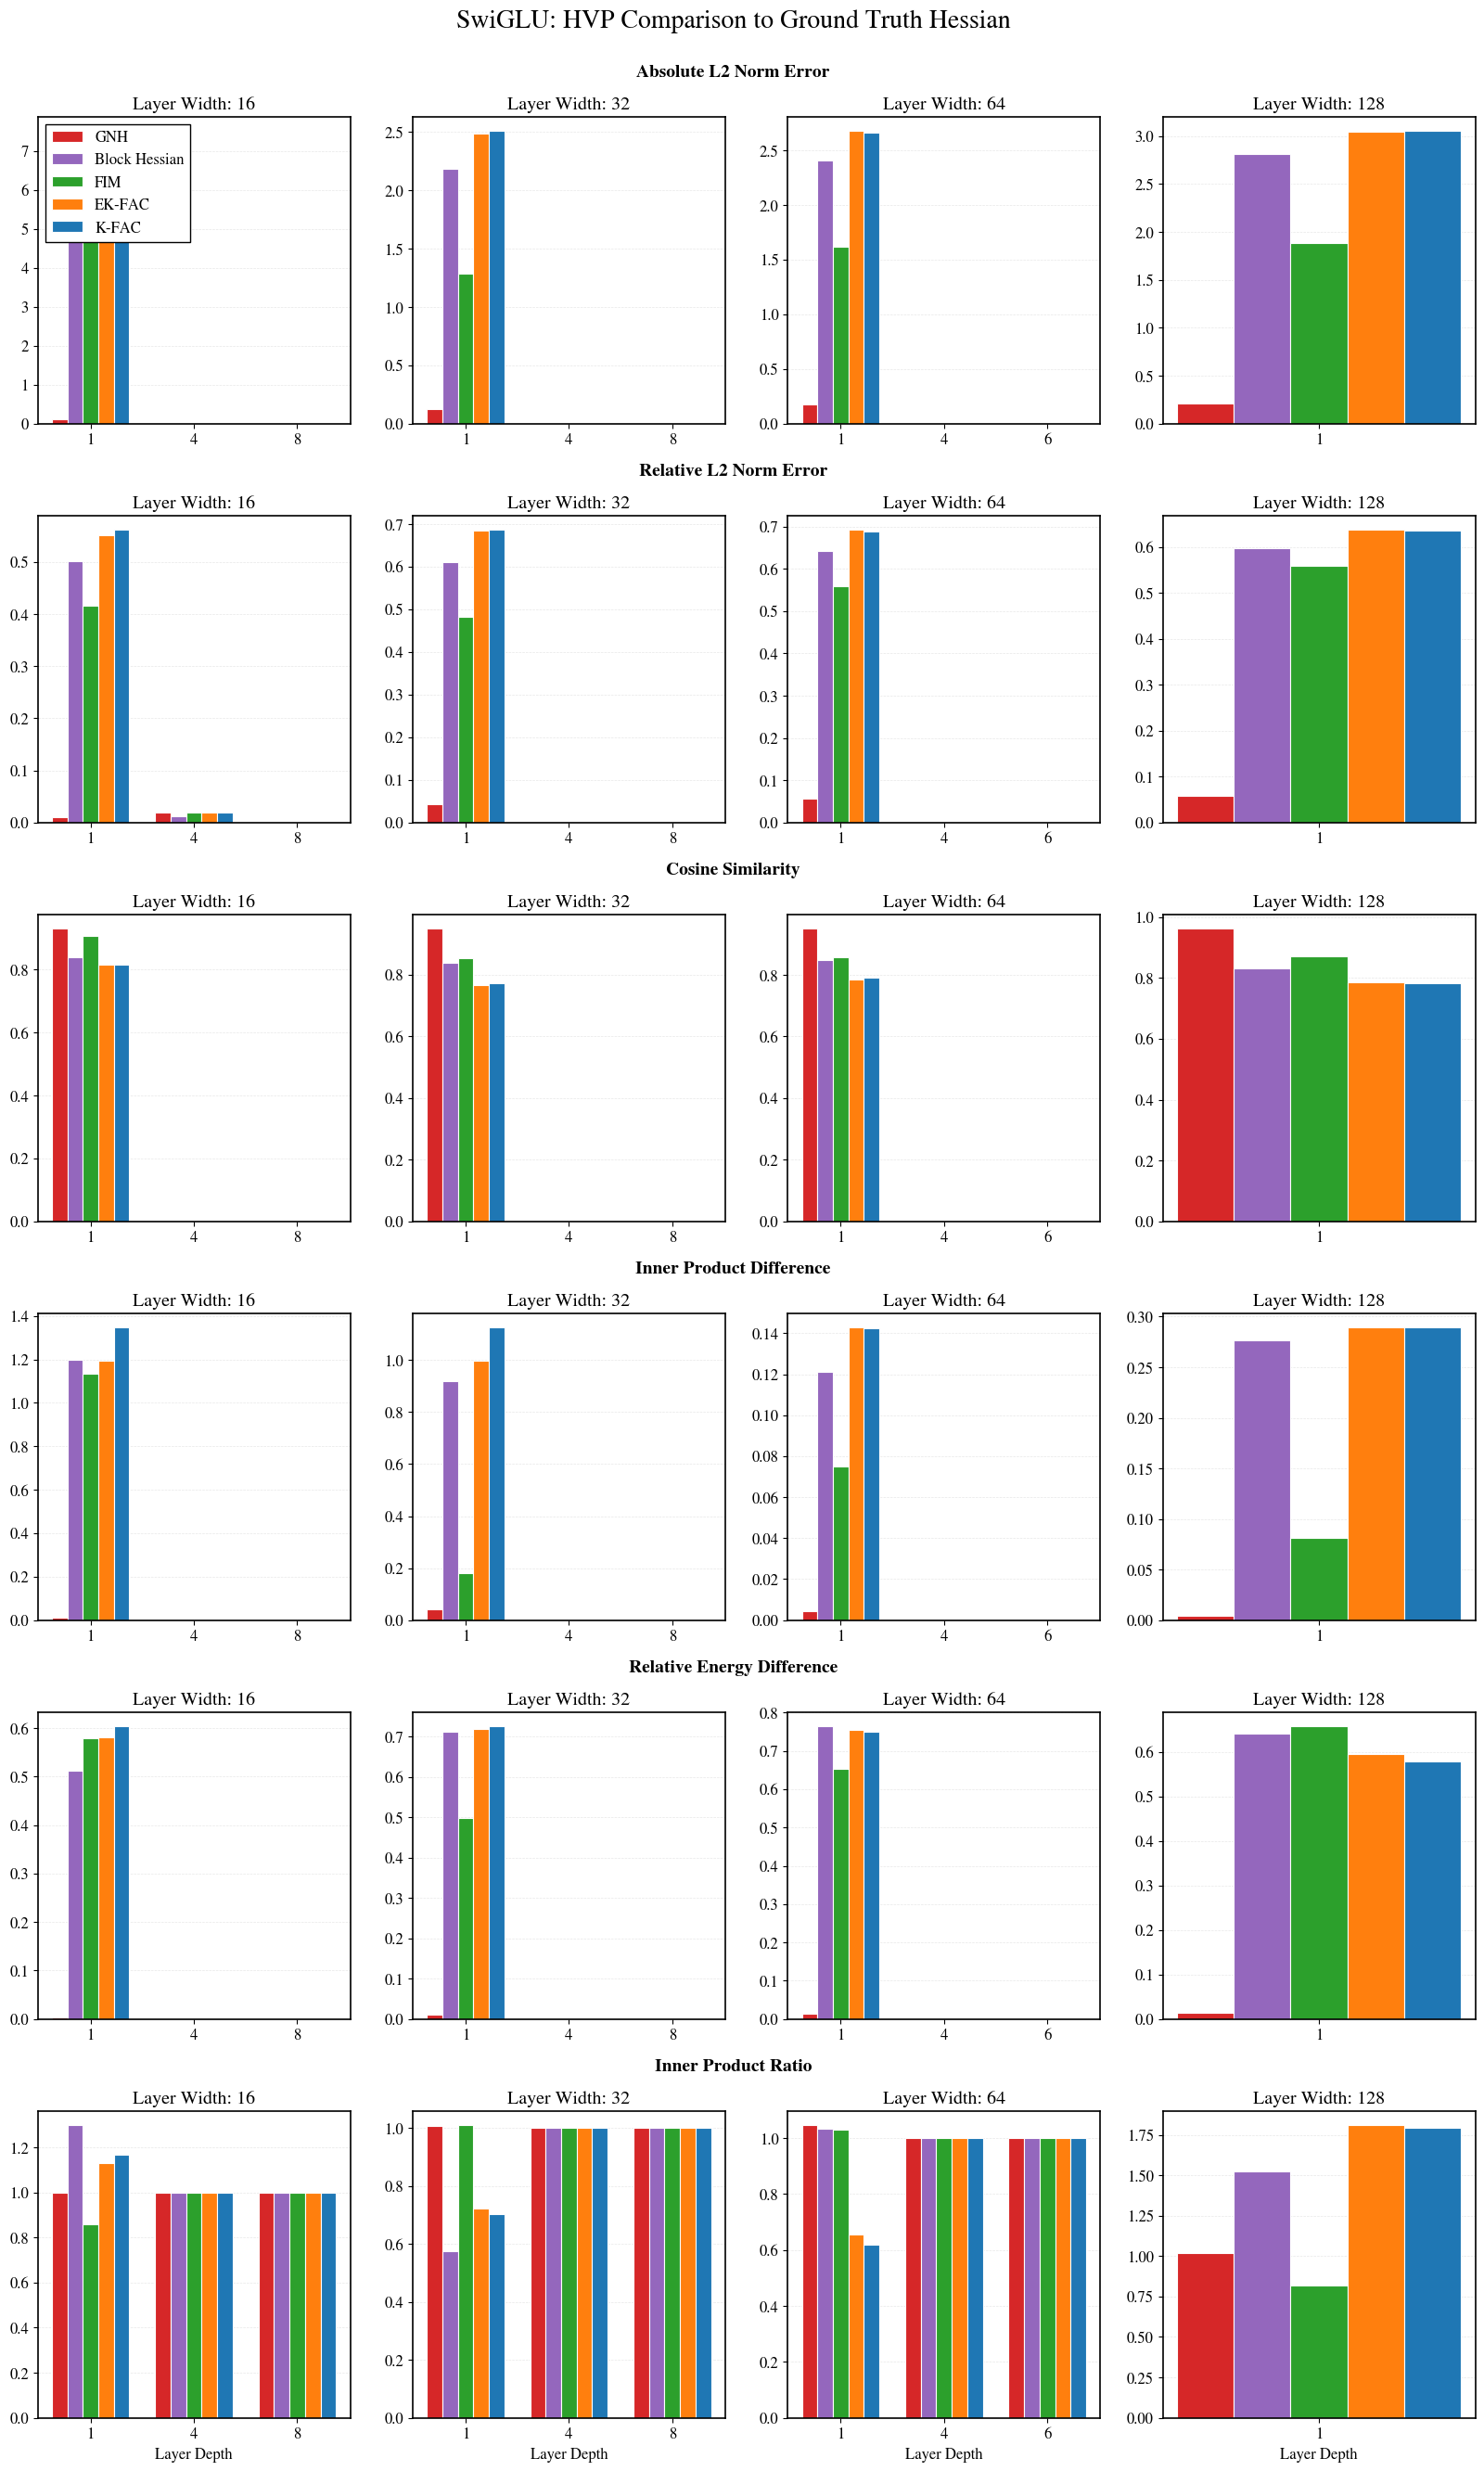

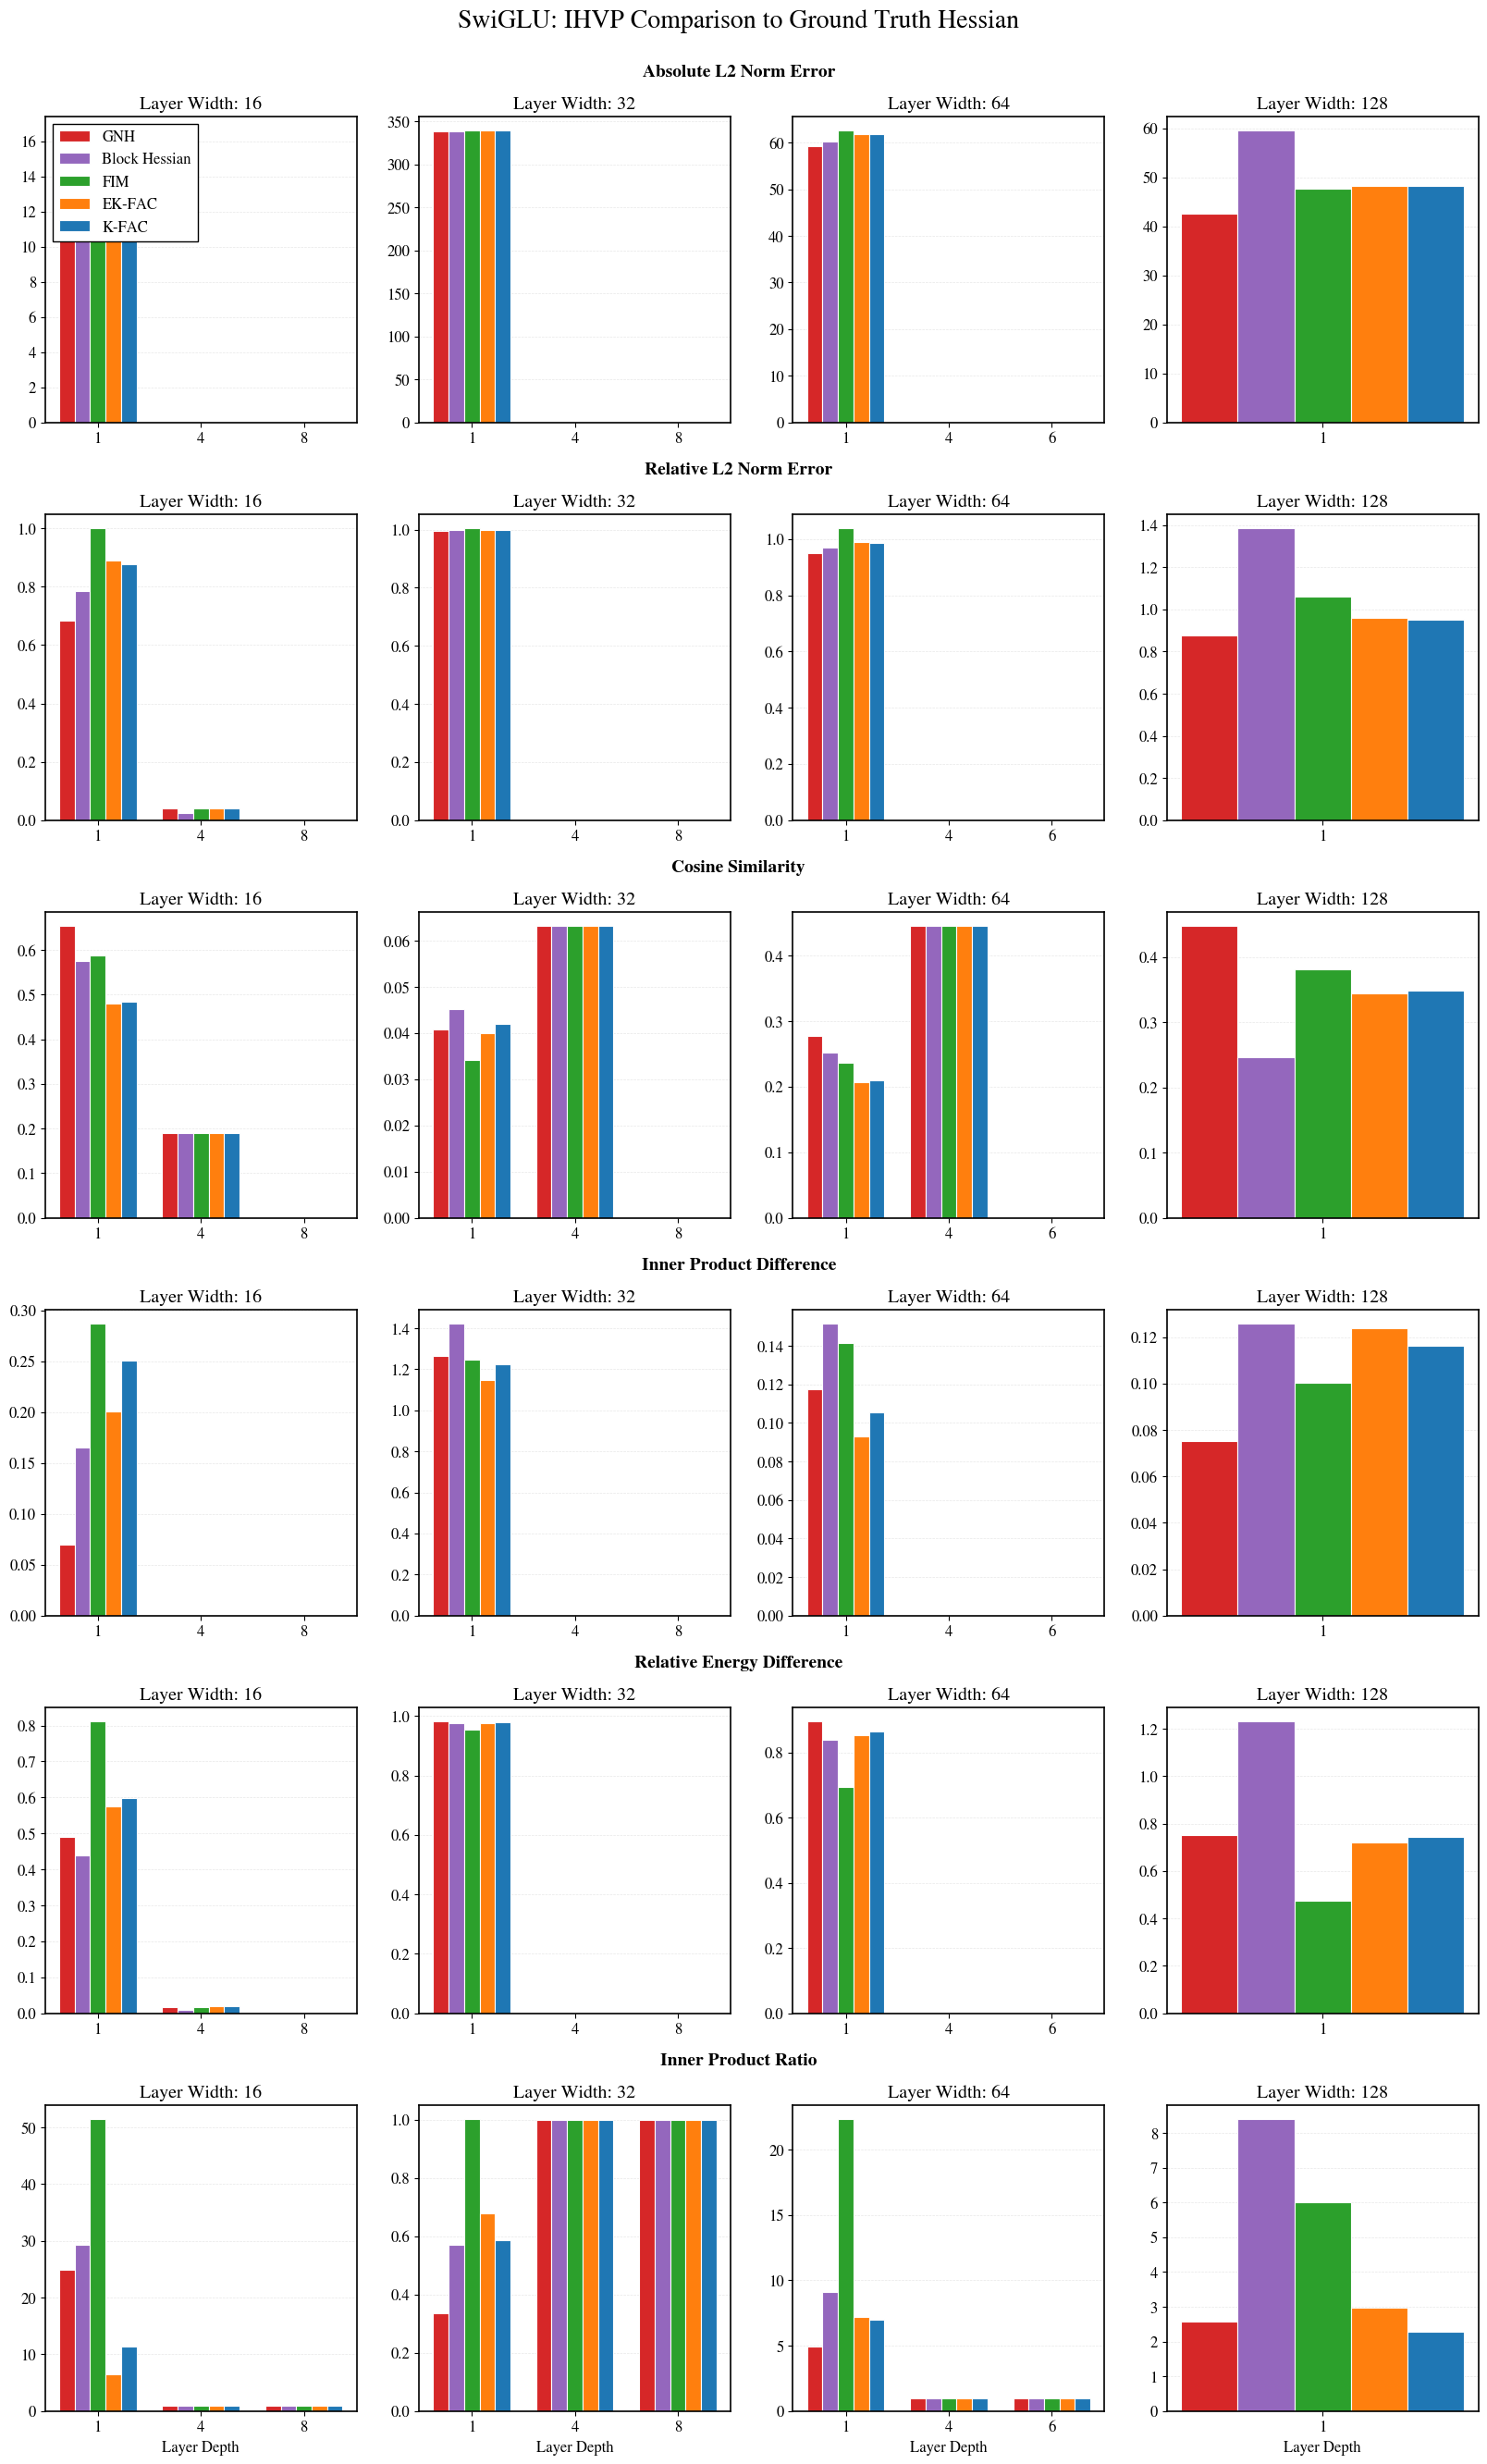

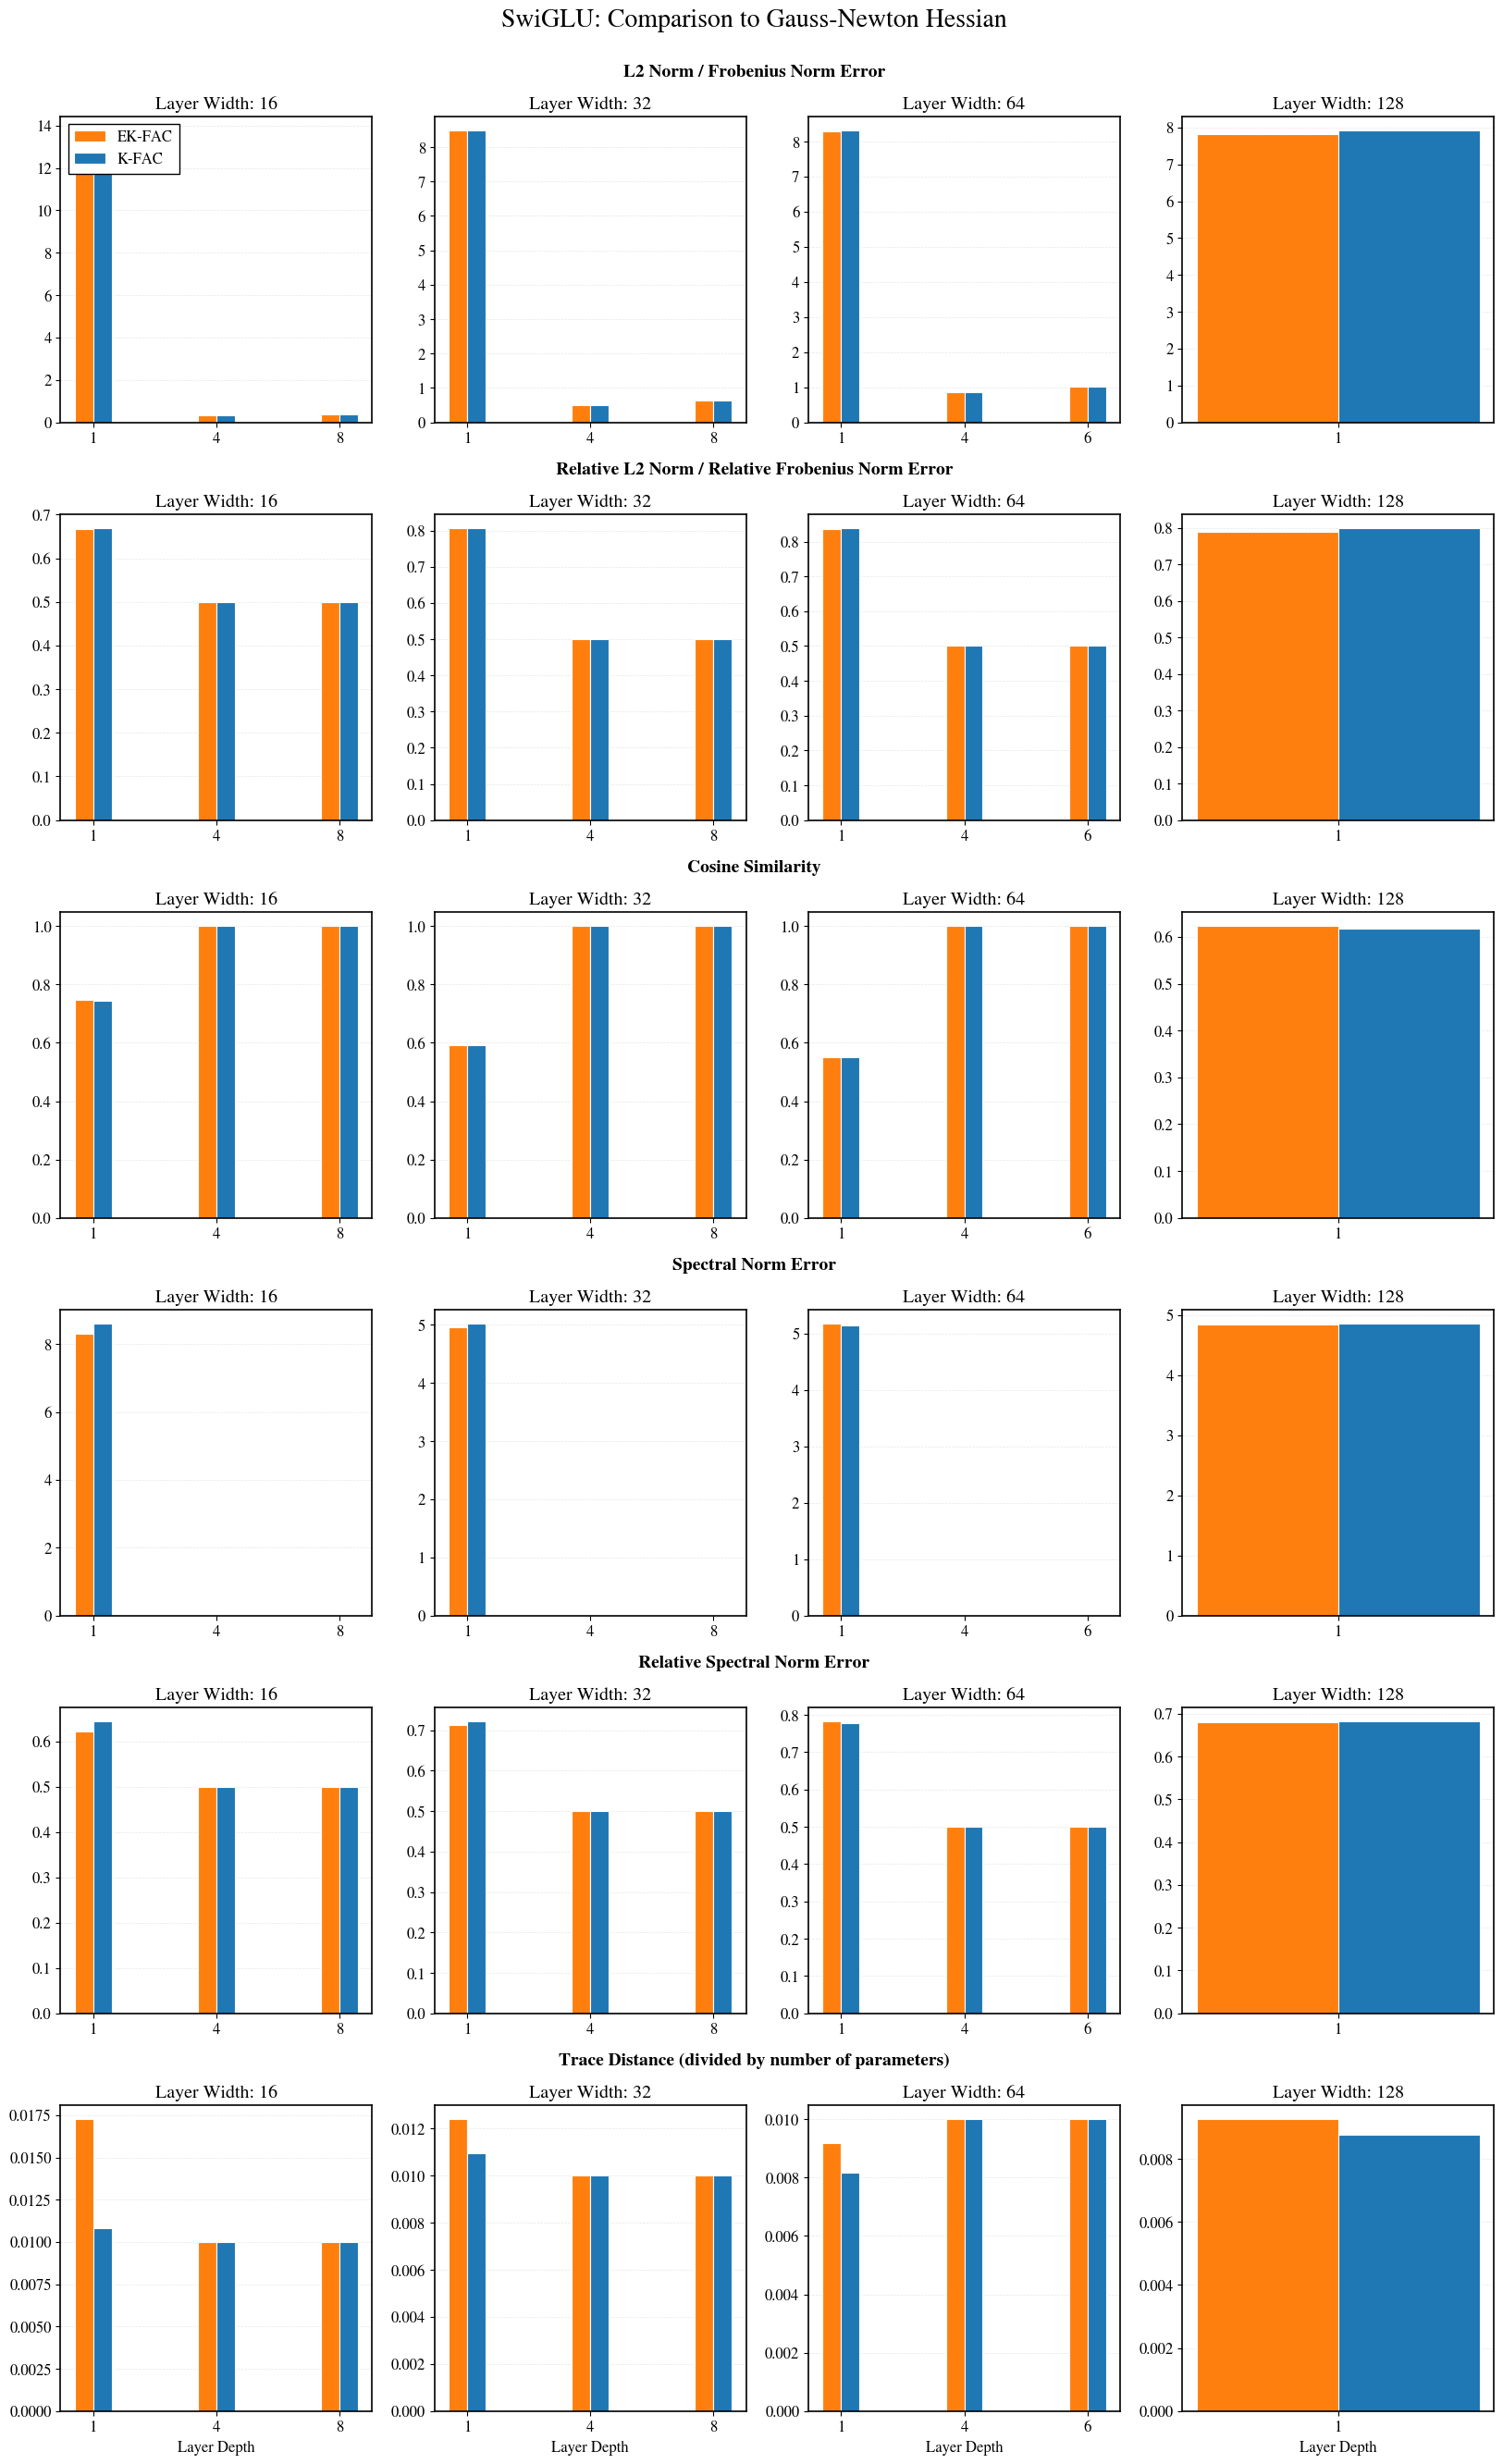

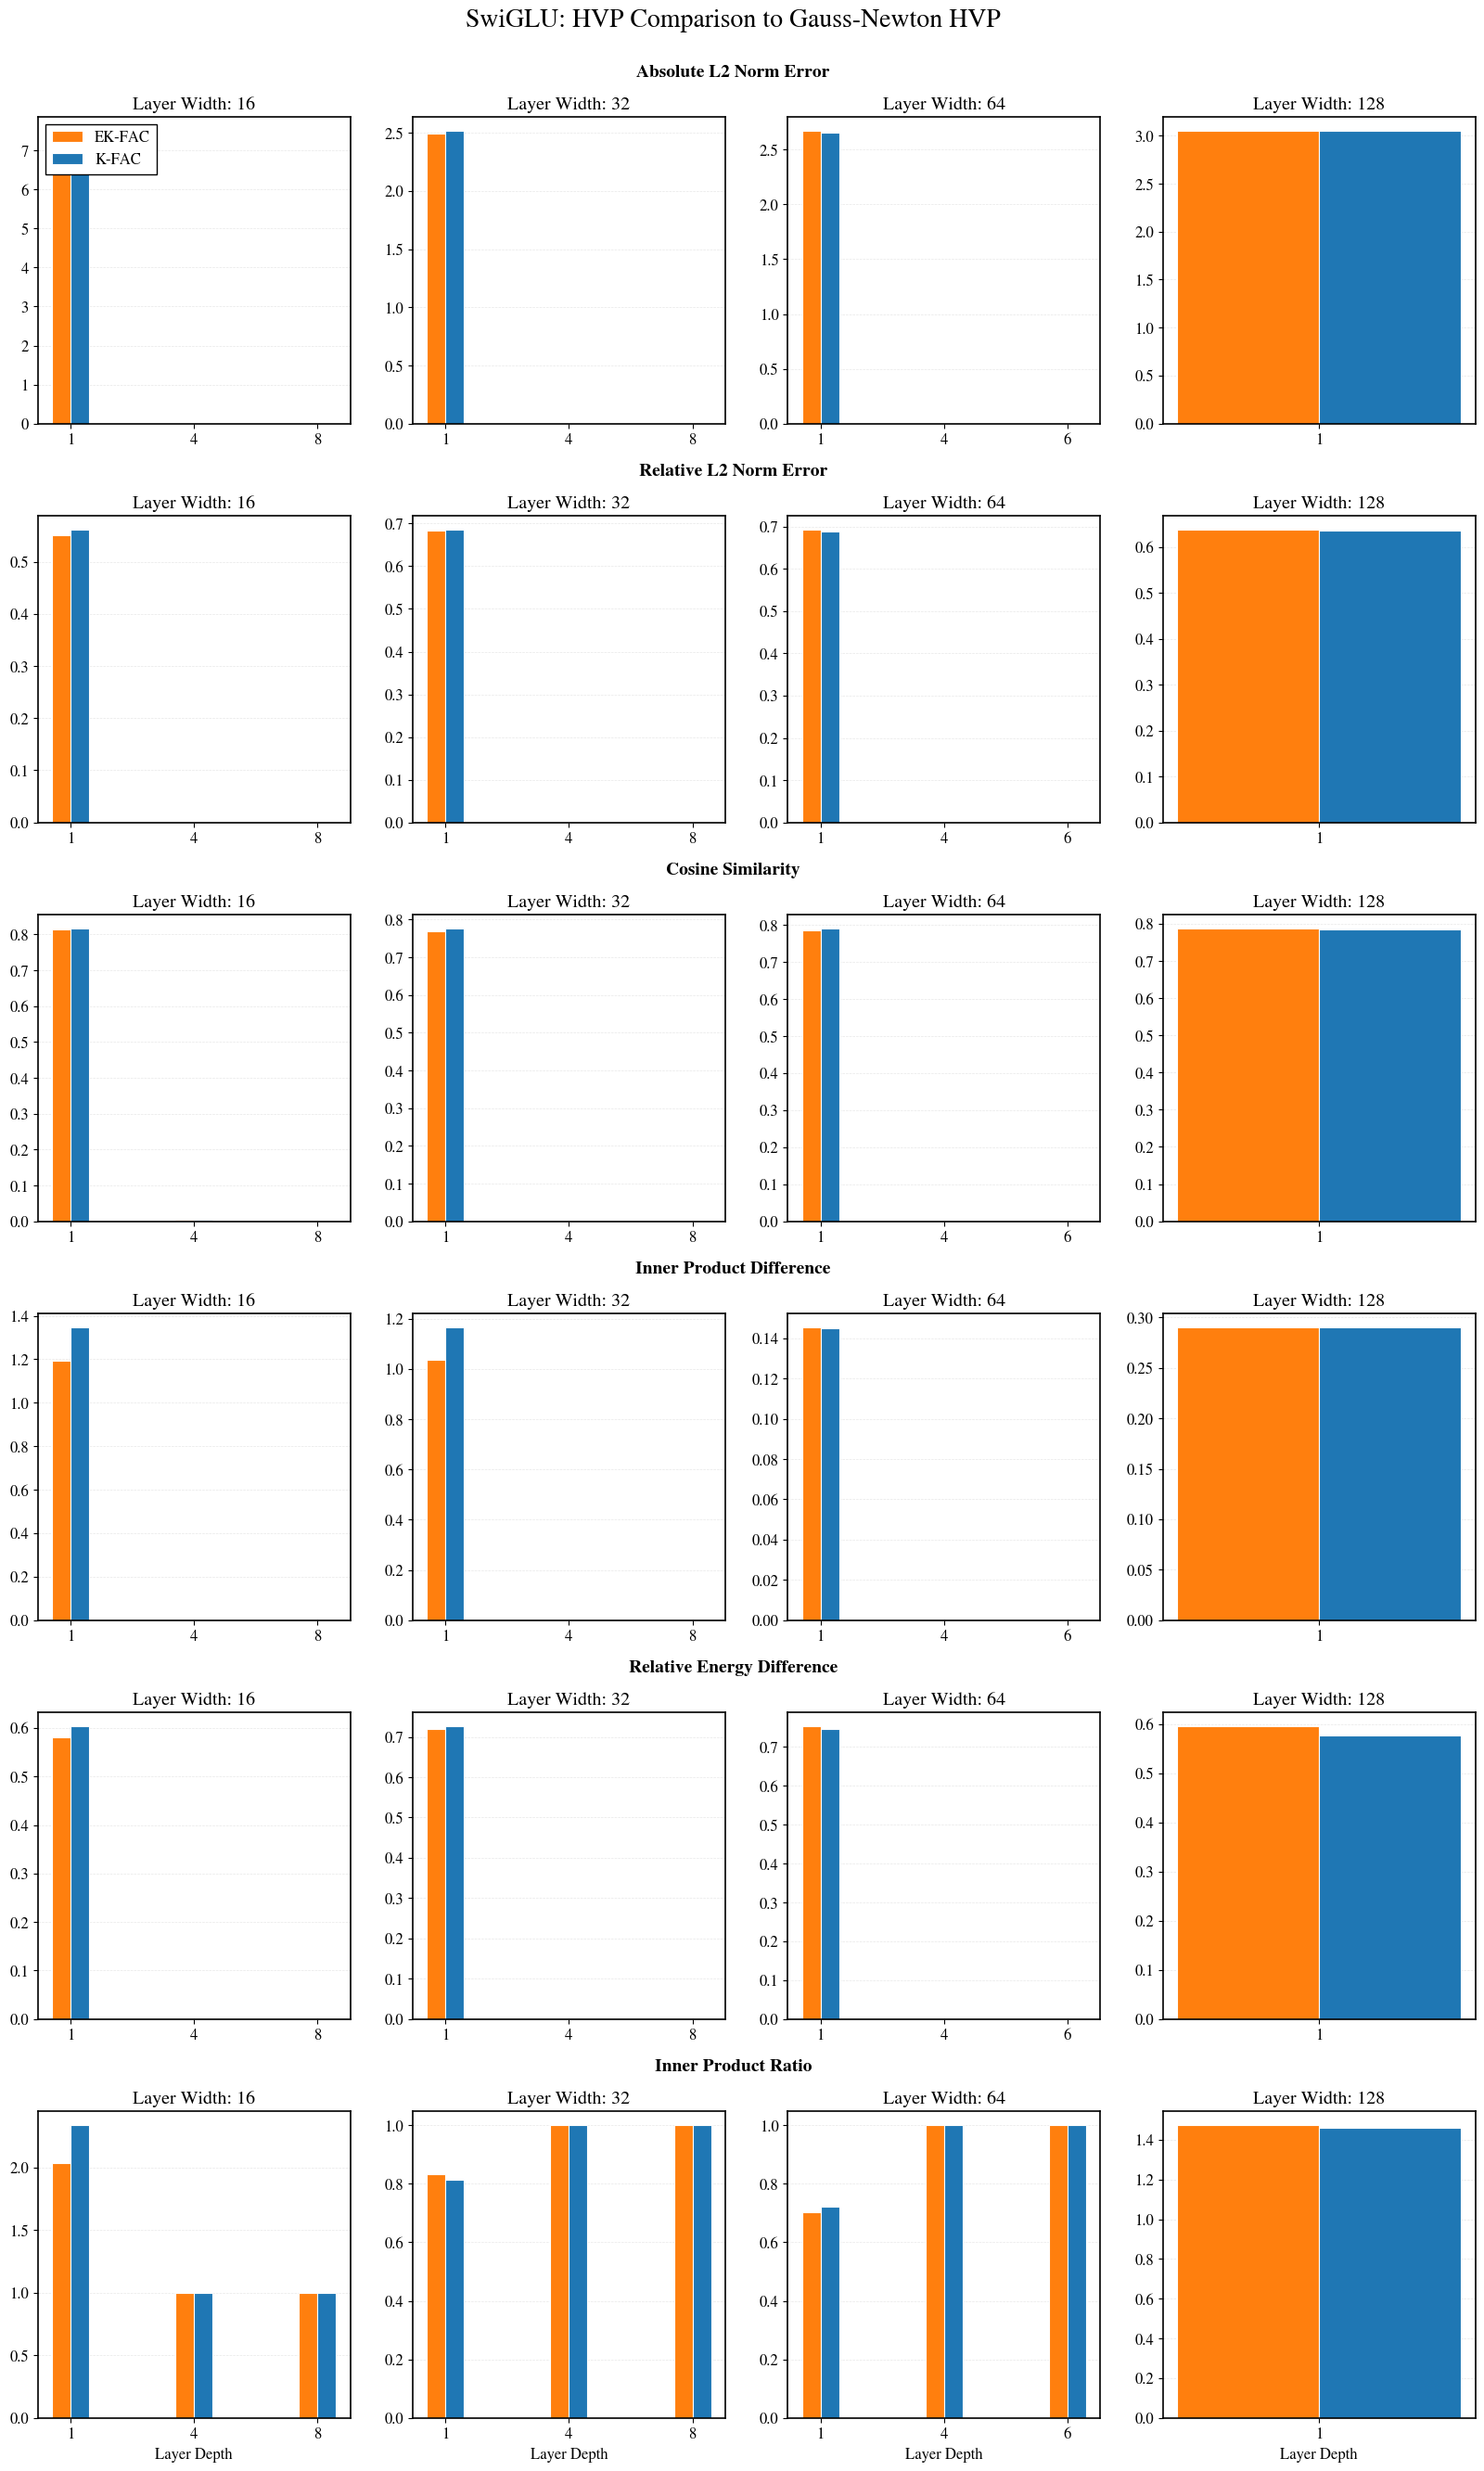

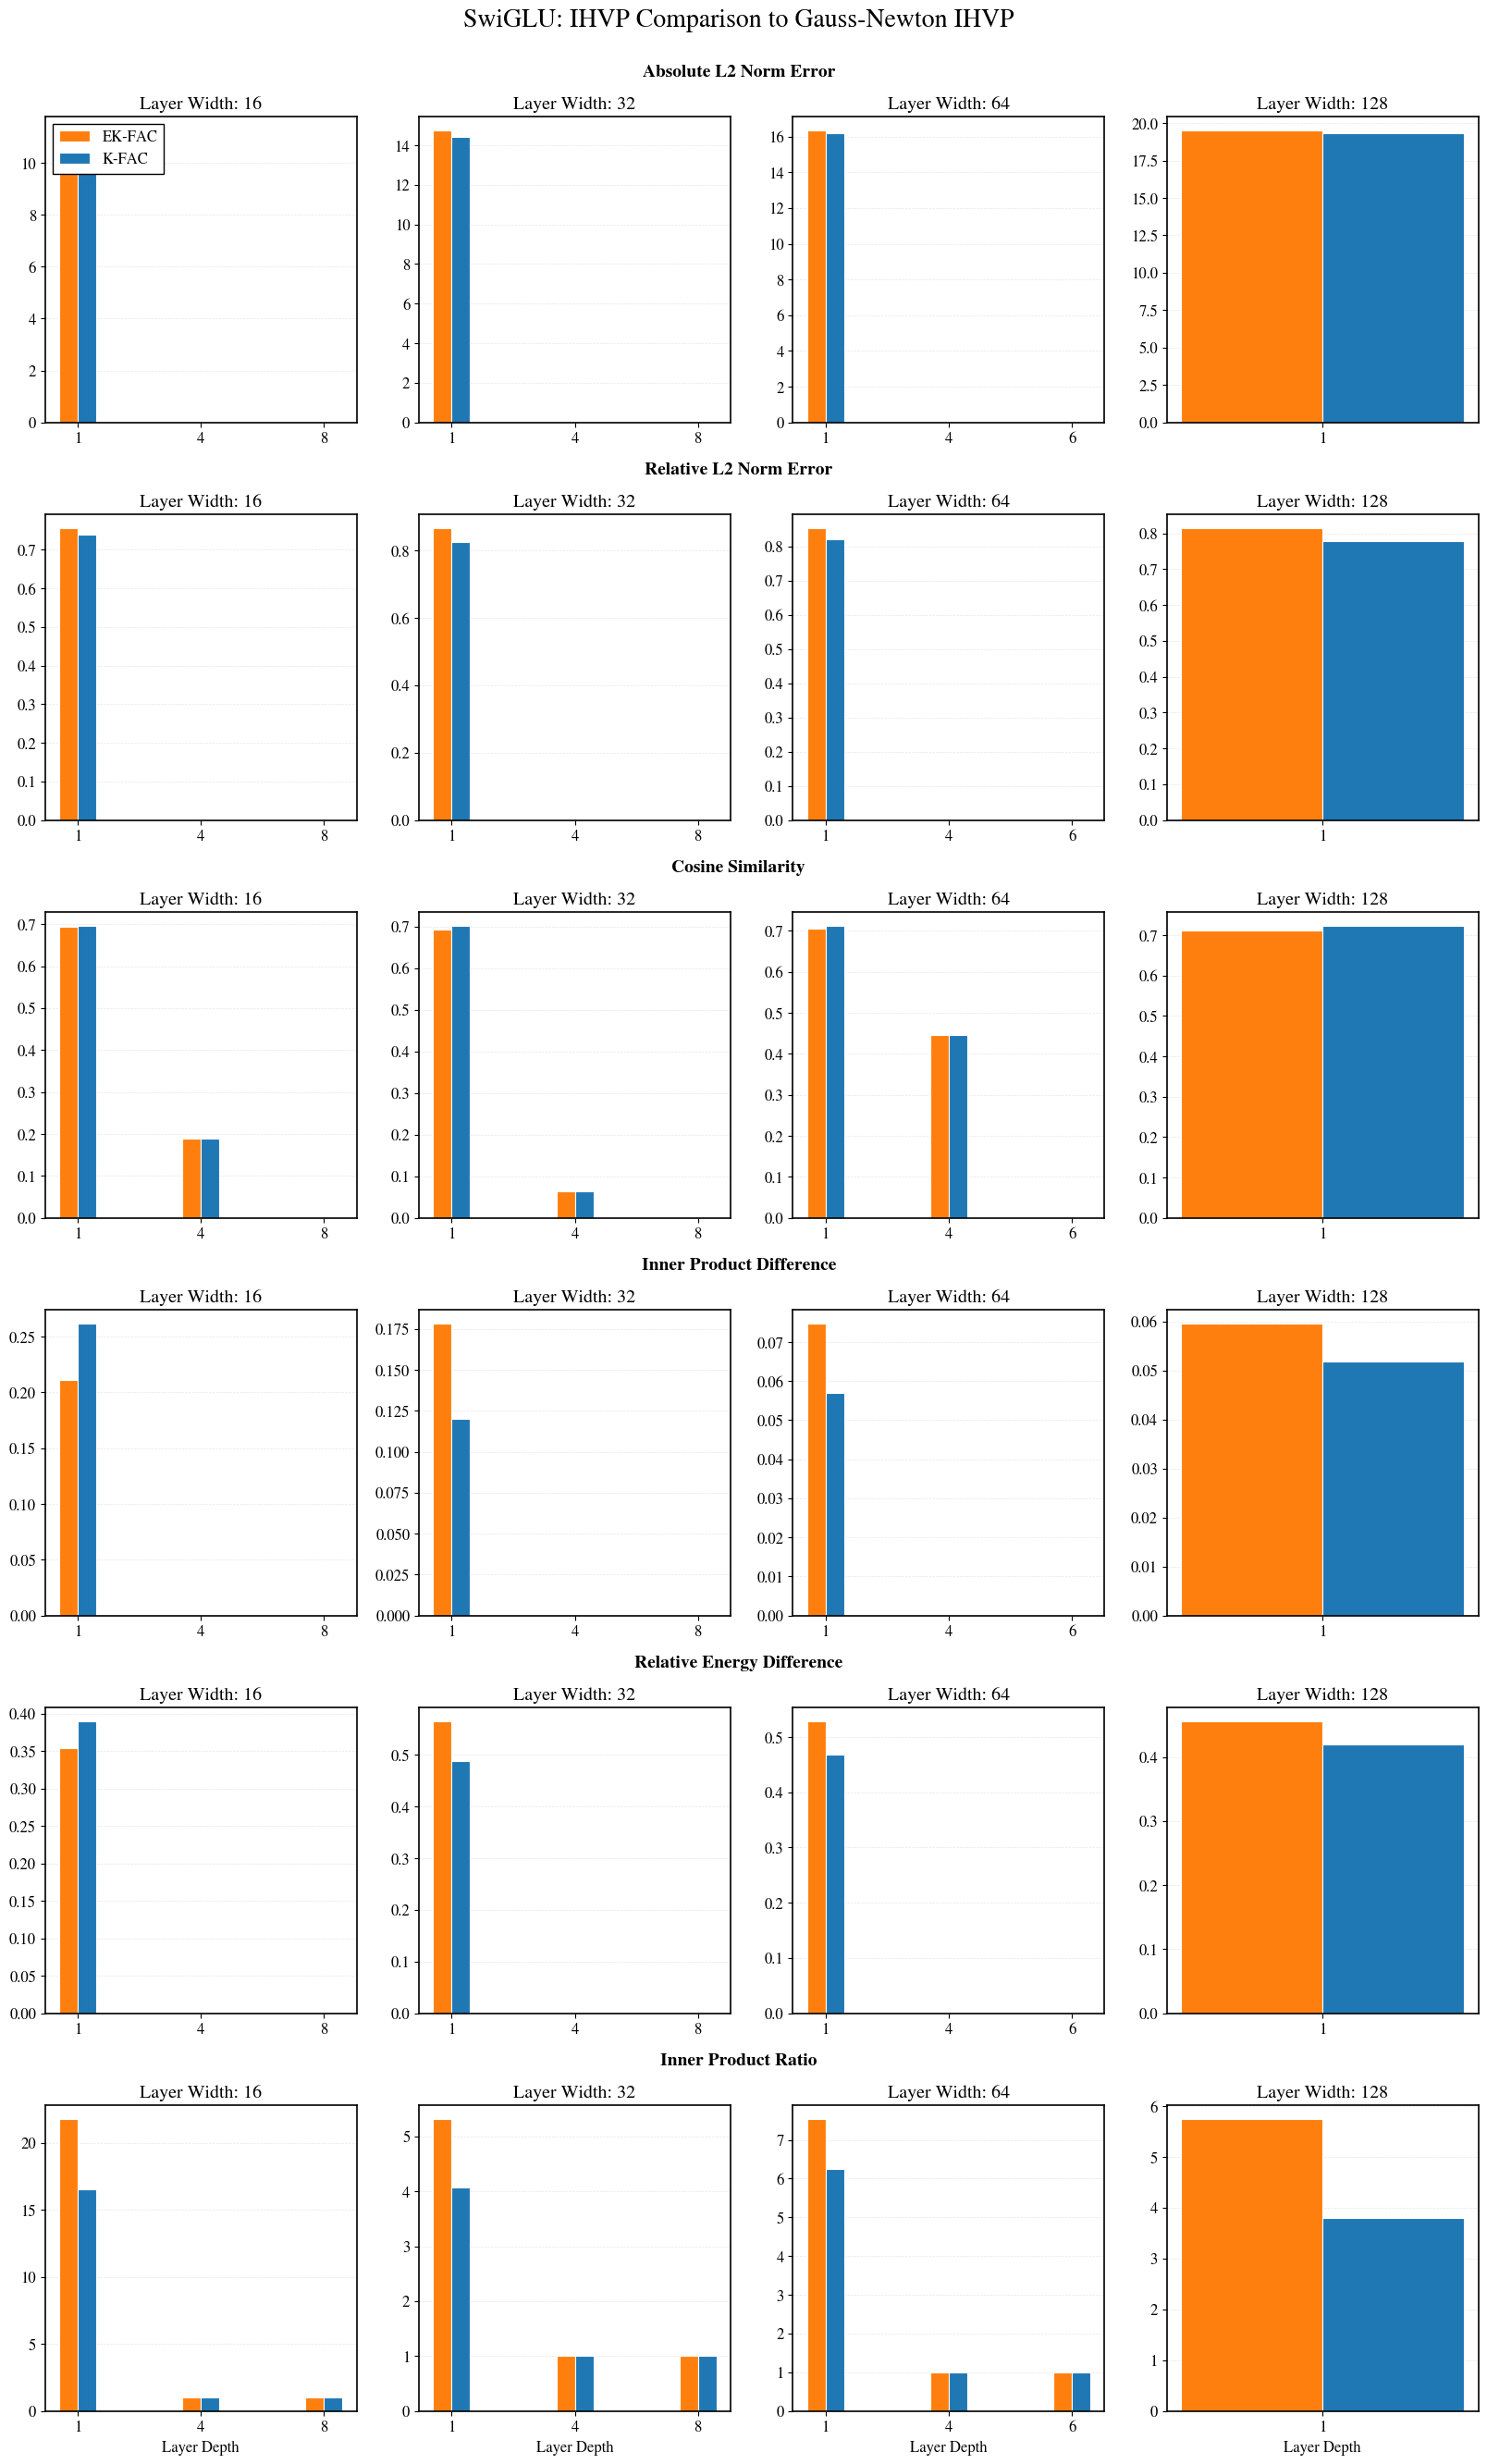

In [29]:
# =========================
# SwiGLU Hessian Analysis
# =========================

# Layer depths (identical to MLP setup)
layer_depths_16 = [1, 4, 8]
layer_depths_32 = [1, 4, 8]
layer_depths_64 = [1, 4, 6]
layer_depths_128 = [1]

width_configs_swiglu = [
    (results_swiglu_16, layer_depths_16, "Layer Width: 16"),
    (results_swiglu_32, layer_depths_32, "Layer Width: 32"),
    (results_swiglu_64, layer_depths_64, "Layer Width: 64"),
    (results_swiglu_128, layer_depths_128, "Layer Width: 128"),
]

# =========================
# Comparison w/ True Hessian
# =========================

# ---------- Full Hessian ----------
fig = plt.figure(figsize=(20, 4.3 * len(matrix_metrics_to_plot)))
gs = GridSpec(len(matrix_metrics_to_plot), 1, figure=fig, hspace=0.5)

for metric_idx, (metric, metric_label) in enumerate(matrix_metrics_to_plot):
    subfig = fig.add_subfigure(gs[metric_idx, 0])
    axs = subfig.subplots(1, 4)
    subfig.suptitle(metric_label, fontsize=14, fontweight="bold", y=1.01)

    for width_idx, (multiple_results, layer_depths, width_title) in enumerate(
        width_configs_swiglu
    ):
        ax = axs[width_idx]

        single_results = [
            entry["hessian_analysis"]["matrix_comparisons"][metric]["exact"]
            for entry in multiple_results
        ]

        x_pos = list(range(len(layer_depths)))
        n_methods = len(hessian_estimator_mapping)

        for m, (method, label) in enumerate(hessian_estimator_mapping.items()):
            values = [entry[method] for entry in single_results]
            offsets = [
                p - (n_methods - 1) * bar_width / 2 + m * bar_width for p in x_pos
            ]

            ax.bar(
                offsets,
                values,
                width=bar_width,
                label=label,
                color=colors.get(method),
                edgecolor="white",
                linewidth=0.8,
            )

        ax.set_xticks(x_pos)
        ax.set_xticklabels(layer_depths)
        ax.set_title(width_title)
        ax.grid(True, axis="y", linestyle="--", alpha=0.3)
        ax.set_axisbelow(True)

        if metric_idx == len(matrix_metrics_to_plot) - 1:
            ax.set_xlabel("Layer Depth")

        if metric_idx == 0 and width_idx == 0:
            ax.legend(loc="upper left")

fig.suptitle(r"SwiGLU: Comparison to Ground Truth Hessian", fontsize=20, y=1.025)
plt.show()

# ---------- HVPs ----------
fig = plt.figure(figsize=(20, 4.3 * len(vector_metrics_to_plot)))
gs = GridSpec(len(vector_metrics_to_plot), 1, figure=fig, hspace=0.5)

for metric_idx, (metric, metric_label) in enumerate(vector_metrics_to_plot):
    subfig = fig.add_subfigure(gs[metric_idx, 0])
    axs = subfig.subplots(1, 4)
    subfig.suptitle(metric_label, fontsize=14, fontweight="bold", y=1.01)

    for width_idx, (multiple_results, layer_depths, width_title) in enumerate(
        width_configs_swiglu
    ):
        ax = axs[width_idx]

        single_results = [
            entry["hessian_analysis"]["hvp_comparisons"][metric]["exact"]
            for entry in multiple_results
        ]

        x_pos = list(range(len(layer_depths)))
        n_methods = len(hessian_estimator_mapping)

        for m, (method, label) in enumerate(hessian_estimator_mapping.items()):
            values = [entry[method] for entry in single_results]
            offsets = [
                p - (n_methods - 1) * bar_width / 2 + m * bar_width for p in x_pos
            ]

            ax.bar(
                offsets,
                values,
                width=bar_width,
                label=label,
                color=colors.get(method),
                edgecolor="white",
                linewidth=0.8,
            )

        ax.set_xticks(x_pos)
        ax.set_xticklabels(layer_depths)
        ax.set_title(width_title)
        ax.grid(True, axis="y", linestyle="--", alpha=0.3)
        ax.set_axisbelow(True)

        if metric_idx == len(vector_metrics_to_plot) - 1:
            ax.set_xlabel("Layer Depth")

        if metric_idx == 0 and width_idx == 0:
            ax.legend(loc="upper left")

fig.suptitle(r"SwiGLU: HVP Comparison to Ground Truth Hessian", fontsize=20, y=1.025)
plt.show()

# ---------- IHVPs ----------
fig = plt.figure(figsize=(20, 4.3 * len(vector_metrics_to_plot)))
gs = GridSpec(len(vector_metrics_to_plot), 1, figure=fig, hspace=0.5)

for metric_idx, (metric, metric_label) in enumerate(vector_metrics_to_plot):
    subfig = fig.add_subfigure(gs[metric_idx, 0])
    axs = subfig.subplots(1, 4)
    subfig.suptitle(metric_label, fontsize=14, fontweight="bold", y=1.01)

    for width_idx, (multiple_results, layer_depths, width_title) in enumerate(
        width_configs_swiglu
    ):
        ax = axs[width_idx]

        single_results = [
            entry["hessian_analysis"]["ihvp_comparisons"][metric]["exact"]
            for entry in multiple_results
        ]

        x_pos = list(range(len(layer_depths)))
        n_methods = len(hessian_estimator_mapping)

        for m, (method, label) in enumerate(hessian_estimator_mapping.items()):
            values = [entry[method] for entry in single_results]
            offsets = [
                p - (n_methods - 1) * bar_width / 2 + m * bar_width for p in x_pos
            ]

            ax.bar(
                offsets,
                values,
                width=bar_width,
                label=label,
                color=colors.get(method),
                edgecolor="white",
                linewidth=0.8,
            )

        ax.set_xticks(x_pos)
        ax.set_xticklabels(layer_depths)
        ax.set_title(width_title)
        ax.grid(True, axis="y", linestyle="--", alpha=0.3)
        ax.set_axisbelow(True)

        if metric_idx == len(vector_metrics_to_plot) - 1:
            ax.set_xlabel("Layer Depth")

        if metric_idx == 0 and width_idx == 0:
            ax.legend(loc="upper left")

fig.suptitle(r"SwiGLU: IHVP Comparison to Ground Truth Hessian", fontsize=20, y=1.025)
plt.show()

# =========================
# Comparison with GNH
# =========================

# ---------- Full GNH ----------
fig = plt.figure(figsize=(20, 4.3 * len(matrix_metrics_to_plot)))
gs = GridSpec(len(matrix_metrics_to_plot), 1, figure=fig, hspace=0.5)

for metric_idx, (metric, metric_label) in enumerate(matrix_metrics_to_plot):
    subfig = fig.add_subfigure(gs[metric_idx, 0])
    axs = subfig.subplots(1, 4)
    subfig.suptitle(metric_label, fontsize=14, fontweight="bold", y=1.01)

    for width_idx, (multiple_results, layer_depths, width_title) in enumerate(
        width_configs_swiglu
    ):
        ax = axs[width_idx]

        single_results = [
            entry["hessian_analysis"]["matrix_comparisons"][metric]["gnh"]
            for entry in multiple_results
        ]

        x_pos = list(range(len(layer_depths)))
        n_methods = len(gnh_estimator_mapping)

        for m, (method, label) in enumerate(gnh_estimator_mapping.items()):
            values = [entry[method] for entry in single_results]
            offsets = [
                p - (n_methods - 1) * bar_width / 2 + m * bar_width for p in x_pos
            ]

            ax.bar(
                offsets,
                values,
                width=bar_width,
                label=label,
                color=colors.get(method),
                edgecolor="white",
                linewidth=0.8,
            )

        ax.set_xticks(x_pos)
        ax.set_xticklabels(layer_depths)
        ax.set_title(width_title)
        ax.grid(True, axis="y", linestyle="--", alpha=0.3)
        ax.set_axisbelow(True)

        if metric_idx == len(matrix_metrics_to_plot) - 1:
            ax.set_xlabel("Layer Depth")

        if metric_idx == 0 and width_idx == 0:
            ax.legend(loc="upper left")

fig.suptitle(r"SwiGLU: Comparison to Gauss-Newton Hessian", fontsize=20, y=1.025)
plt.show()

# ---------- HVPs (GNH) ----------
fig = plt.figure(figsize=(20, 4.3 * len(vector_metrics_to_plot)))
gs = GridSpec(len(vector_metrics_to_plot), 1, figure=fig, hspace=0.5)

for metric_idx, (metric, metric_label) in enumerate(vector_metrics_to_plot):
    subfig = fig.add_subfigure(gs[metric_idx, 0])
    axs = subfig.subplots(1, 4)
    subfig.suptitle(metric_label, fontsize=14, fontweight="bold", y=1.01)

    for width_idx, (multiple_results, layer_depths, width_title) in enumerate(
        width_configs_swiglu
    ):
        ax = axs[width_idx]

        single_results = [
            entry["hessian_analysis"]["hvp_comparisons"][metric]["gnh"]
            for entry in multiple_results
        ]

        x_pos = list(range(len(layer_depths)))
        n_methods = len(gnh_estimator_mapping)

        for m, (method, label) in enumerate(gnh_estimator_mapping.items()):
            values = [entry[method] for entry in single_results]
            offsets = [
                p - (n_methods - 1) * bar_width / 2 + m * bar_width for p in x_pos
            ]

            ax.bar(
                offsets,
                values,
                width=bar_width,
                label=label,
                color=colors.get(method),
                edgecolor="white",
                linewidth=0.8,
            )

        ax.set_xticks(x_pos)
        ax.set_xticklabels(layer_depths)
        ax.set_title(width_title)
        ax.grid(True, axis="y", linestyle="--", alpha=0.3)
        ax.set_axisbelow(True)

        if metric_idx == len(vector_metrics_to_plot) - 1:
            ax.set_xlabel("Layer Depth")

        if metric_idx == 0 and width_idx == 0:
            ax.legend(loc="upper left")

fig.suptitle(r"SwiGLU: HVP Comparison to Gauss-Newton HVP", fontsize=20, y=1.025)
plt.show()

# ---------- IHVPs (GNH) ----------
fig = plt.figure(figsize=(20, 4.3 * len(vector_metrics_to_plot)))
gs = GridSpec(len(vector_metrics_to_plot), 1, figure=fig, hspace=0.5)

for metric_idx, (metric, metric_label) in enumerate(vector_metrics_to_plot):
    subfig = fig.add_subfigure(gs[metric_idx, 0])
    axs = subfig.subplots(1, 4)
    subfig.suptitle(metric_label, fontsize=14, fontweight="bold", y=1.01)

    for width_idx, (multiple_results, layer_depths, width_title) in enumerate(
        width_configs_swiglu
    ):
        ax = axs[width_idx]

        single_results = [
            entry["hessian_analysis"]["ihvp_comparisons"][metric]["gnh"]
            for entry in multiple_results
        ]

        x_pos = list(range(len(layer_depths)))
        n_methods = len(gnh_estimator_mapping)

        for m, (method, label) in enumerate(gnh_estimator_mapping.items()):
            values = [entry[method] for entry in single_results]
            offsets = [
                p - (n_methods - 1) * bar_width / 2 + m * bar_width for p in x_pos
            ]

            ax.bar(
                offsets,
                values,
                width=bar_width,
                label=label,
                color=colors.get(method),
                edgecolor="white",
                linewidth=0.8,
            )

        ax.set_xticks(x_pos)
        ax.set_xticklabels(layer_depths)
        ax.set_title(width_title)
        ax.grid(True, axis="y", linestyle="--", alpha=0.3)
        ax.set_axisbelow(True)

        if metric_idx == len(vector_metrics_to_plot) - 1:
            ax.set_xlabel("Layer Depth")

        if metric_idx == 0 and width_idx == 0:
            ax.legend(loc="upper left")

fig.suptitle(r"SwiGLU: IHVP Comparison to Gauss-Newton IHVP", fontsize=20, y=1.025)
plt.show()
